In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
print(torch.__version__)

2.5.1+cu124


In [ ]:
!pip install prettytable

In [ ]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# **Vanilla - RNN**

In [ ]:
dataset = []
with open('/content/drive/MyDrive/QML-Research/Data/fb_hi_cg_train2.txt', 'r') as f:
  sent, tags = [], []
  for line in f:
    line = line.strip()
    if line and not line.startswith('.'):
      word_tokens = line.split()
      sent.append(word_tokens[0])
      tags.append(word_tokens[-1])
    else:
      if sent:
        dataset.append((sent, tags))
        sent, tags = [], []

In [ ]:
word_counter = Counter()
tag_counter = Counter()

for sent, tags in dataset:
  word_counter.update(sent)
  tag_counter.update(tags)


word2idx = {word:idx for idx, (word, _) in enumerate(word_counter.most_common(), start = 1)}
tag2idx = {tag:idx for idx, (tag, _) in enumerate(tag_counter.most_common(), start = 1)}
idx2tag = {idx:tag for tag, idx in tag2idx.items()}

word2idx["<PAD>"] = 0
tag2idx["<PAD>"] = -1

def encode(sentence, tags):
  word_indices = [word2idx[word] for word in sentence]
  tag_indices = [tag2idx[tag] for tag in tags]
  return word_indices, tag_indices

In [ ]:
tag_counter.most_common()

[('G_N', 4185),
 ('G_V', 3788),
 ('G_PRP', 2008),
 ('PSP', 1894),
 ('G_X', 1506),
 ('DT', 1247),
 ('G_J', 1184),
 ('G_R', 1088),
 ('G_PRT', 766),
 ('CC', 671),
 ('G_SYM', 153)]

In [ ]:
encoded_data = [encode(sentence, tags) for sentence, tags in dataset]
for sent_encoded, tag_encoded in encoded_data[:5]:
  print(sent_encoded)
  print(tag_encoded)
  print()

[1757, 1758, 1759]
[11, 7, 2]

[1760, 1761, 760, 388, 564, 1762]
[7, 1, 9, 1, 10, 1]

[1763, 1081, 133, 1082, 1764, 449]
[3, 9, 3, 7, 2, 2]

[450, 4, 1083, 760, 343, 50, 565, 20, 1084, 8, 3, 1085, 20, 46, 98, 1086, 1087, 1088, 1089]
[2, 9, 1, 9, 1, 5, 4, 5, 1, 4, 6, 1, 5, 5, 6, 1, 1, 1, 1]

[1, 1090, 5]
[3, 2, 6]



In [ ]:
vocab_size = len(word2idx)
target_size = len(tag2idx)
embedding_dims = 16
hidden_dims = 32

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(VanillaRNN, self).__init__()
    self.embedding_layer = nn.Embedding(vocab_size, embedding_dims)

    self.Wi = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.Wo = nn.Parameter(torch.randn(hidden_dims, target_size) * 0.01)

    self.bh = nn.Parameter(torch.zeros(hidden_dims))
    self.bo = nn.Parameter(torch.zeros(target_size))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeddings = self.embedding_layer(x)
    for time_step in range(seq_len):
      x_t = embeddings[:, time_step]
      h = torch.tanh(x_t @ self.Wi + h @ self.Wh + self.bh)
      o_t = h @ self.Wo + self.bo
      ops.append(o_t)

    return torch.stack(ops, dim = 1)

In [ ]:
max_len_seq = max(len(seq) for seq, _ in encoded_data)

def padding(seq, pad_idx, maxlen):
  return seq + [pad_idx] * (maxlen - len(seq))

X_train = torch.tensor([padding(seq, 0, max_len_seq) for seq, _ in encoded_data])
y_train = torch.tensor([padding(tags, -1, max_len_seq) for _, tags in encoded_data])

In [ ]:
print(X_train[0], len(X_train[0]))
print(y_train[0], len(y_train[0]))

tensor([1757, 1758, 1759,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]) 80
tensor([11,  7,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1]) 80


In [ ]:
VRNN = VanillaRNN(vocab_size, embedding_dims, hidden_dims, target_size)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
opt = optim.SGD(VRNN.parameters(), lr=0.1)

In [ ]:
epochs = 200
#training loop
for epoch in tqdm(range(epochs)):
  opt.zero_grad()
  logits = VRNN(X_train)
  loss = criterion(logits.view(-1, target_size), y_train.view(-1))
  loss.backward()
  opt.step()

  predictions = logits.argmax(dim=-1)
  mask = (y_train != -1)
  correct = ((predictions == y_train) & mask).sum().item()
  total = mask.sum().item()
  accuracy = correct / total if total > 0 else 0


  if epoch%10 ==0:
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, accuracy: {accuracy*100:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.4847, accuracy: 9.5241
Epoch: 10, Loss: 2.4343, accuracy: 22.6339
Epoch: 20, Loss: 2.3921, accuracy: 22.6339
Epoch: 30, Loss: 2.3568, accuracy: 22.6339
Epoch: 40, Loss: 2.3276, accuracy: 22.6339
Epoch: 50, Loss: 2.3033, accuracy: 22.6339
Epoch: 60, Loss: 2.2831, accuracy: 22.6339
Epoch: 70, Loss: 2.2663, accuracy: 22.6339
Epoch: 80, Loss: 2.2519, accuracy: 22.6339
Epoch: 90, Loss: 2.2395, accuracy: 22.6339
Epoch: 100, Loss: 2.2284, accuracy: 22.6339
Epoch: 110, Loss: 2.2182, accuracy: 22.6339
Epoch: 120, Loss: 2.2085, accuracy: 22.6339
Epoch: 130, Loss: 2.1990, accuracy: 22.6339
Epoch: 140, Loss: 2.1893, accuracy: 22.6339
Epoch: 150, Loss: 2.1793, accuracy: 22.6447
Epoch: 160, Loss: 2.1688, accuracy: 23.3694
Epoch: 170, Loss: 2.1577, accuracy: 23.4559
Epoch: 180, Loss: 2.1461, accuracy: 23.8453
Epoch: 190, Loss: 2.1341, accuracy: 23.8453


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
VRNN.eval()
with torch.no_grad():
  logits = VRNN(X_test)
  predictions = torch.argmax(logits, dim=-1)
  mask = (y_test != -1)
  correct = ((predictions == y_test) & mask).sum().item()
  total = mask.sum().item()
  accuracy = correct / total if total>0 else 0
  print(f"Test accuracy: {accuracy*100:.4f}")

  for i in range(5):
    words = [list(word2idx.keys())[list(word2idx.values()).index(idx)] for idx in X_test[i] if idx > 0]
    true_tags = [idx2tag[idx.item()] for idx in y_test[i] if idx.item() != -1]
    pred_tags = [idx2tag[idx.item()] for idx in predictions[i] if idx.item() != -1]
    pred_tags = pred_tags[:len(true_tags)]
    print(f"Words: {' '.join(words)}\nTrue Tags: {' '.join(true_tags)}\nPredicted Tags: {' '.join(pred_tags)}\n")

Test accuracy: 26.9583
Words: insti politics koi nayi baat nahi hai bhai , my sympathies wid u
True Tags: G_N G_N G_PRP G_J G_V G_PRT G_V G_N G_X DT G_N PSP G_PRP
Predicted Tags: G_N G_N G_N G_N G_N G_V G_N G_N G_V G_N G_N G_N G_N

Words: The ego on this one
True Tags: DT G_N PSP G_PRP G_SYM
Predicted Tags: G_N G_V G_N G_N G_V

Words: but I think I know this guy
True Tags: PSP G_PRP G_V G_PRP G_V DT G_N
Predicted Tags: G_N G_PRP G_N G_PRP G_V G_N G_V

Words: " oye balle !
True Tags: G_X G_PRT G_PRT G_X
Predicted Tags: G_N G_N G_N G_N

Words: : I am a small town girl who came to IITB and met this hotshot Xavierite big city boy from Bombay
True Tags: G_X G_PRP G_V DT G_J G_N G_N G_PRP G_V G_PRT G_N CC G_V G_PRP G_J G_J G_J G_N G_N PSP G_N
Predicted Tags: G_N G_PRP G_N G_N G_N G_N G_N G_V G_N G_N G_N G_N G_V G_N G_N G_N G_N G_N G_N G_N G_N



# **Word Embedings**




*   Adding the fasttext word embedding vectors
*   Additionally swapped the o_t with a Linear Layer


In [ ]:
def fasttext_vectors(embedding_file_path, embedding_dim):
  word_vectors = {}
  with open(embedding_file_path, 'r', encoding='utf-8') as f:
    next(f)
    curr_word = None
    curr_vec = []
    for line in f:
      values = line.strip().split()
      if not values:
        continue

      if curr_word is None:
        curr_word = values[0]
        curr_vec.extend(values[1:])
      else:
        curr_vec.extend(values)

        if len(curr_vec) == embedding_dim:
          word_vectors[curr_word] = np.array(curr_vec, dtype=np.float32)
          curr_word = None
          curr_vec = []

  return word_vectors


embedding_dim_vwe = 100
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors100.txt"
fasttext_vectors = fasttext_vectors(path, embedding_dim_vwe)
embedding_matrix = np.zeros((len(word2idx), embedding_dim_vwe))

for word, idx in word2idx.items():
  if word in fasttext_vectors:
    embedding_matrix[idx] = fasttext_vectors[word]
  else:
    embedding_matrix[idx] = np.random.normal(scale = 0.6, size = (embedding_dim_vwe, ))

embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
ctr = 0
for word, idx in word2idx.items():
  if (ctr ==5):
      break
  if idx < embedding_matrix.shape[0]:
    print(f'The word: {word} - index: {idx}')
    print(f'Word index: {idx} - word embeddings: {embedding_matrix[idx]}')
    print()
    ctr += 1

The word: I - index: 1
Word index: 1 - word embeddings: tensor([ 0.2310,  0.3989,  0.9303, -0.2761,  1.0574, -0.3603, -0.1473, -0.7168,
         0.4023, -0.5800,  0.5816,  0.2583, -0.2459,  0.1602, -0.3602,  0.2307,
         0.5509,  0.2429, -0.4534, -0.4337, -0.7028,  0.8057, -0.5776, -0.0666,
        -0.6572, -0.0194, -0.7117,  0.0104,  0.8263,  0.3349,  0.4568, -0.1655,
         0.0688,  0.2342,  0.3889,  0.6320,  0.0456, -0.6926, -0.8556, -0.2558,
        -0.3854, -1.0044, -0.7814, -0.2010,  0.6003, -0.1310, -0.5052,  0.5503,
         0.3264,  0.1207, -0.7277,  0.3852, -0.7185, -1.0399,  0.2711,  0.4021,
        -0.3293,  0.0249, -0.8701, -0.6774,  0.0145, -0.2749,  0.8100,  0.0923,
         0.5682,  0.2534, -0.3749, -1.0582, -0.1853,  0.8321,  0.9807,  0.0934,
         0.5324, -0.8937, -0.2374, -0.2236, -0.7196, -0.4442,  0.2783, -0.2379,
         0.3997, -0.1013, -0.9718,  0.2464, -0.8068,  0.2244,  0.0315,  0.0913,
         0.8433,  0.0874, -0.4884, -0.2811, -0.8949,  2.4667,  0

In [ ]:
model_vwe = VanillaRNN(vocab_size, embedding_dim_vwe, hidden_dims, target_size)
model_vwe.fc = nn.Linear(hidden_dims, target_size)
model_vwe.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)


def forward_vwe(self, x):
  batch_size, seq_len = x.shape
  h = torch.zeros(batch_size, hidden_dims)
  ops = []

  embeds = self.embedding(x)
  for time_step in range(seq_len):
    h = torch.tanh(embeds[:, t] @ self.Wi + h @ self.Wh + self.bh)
    y_t = self.fc(h)
    ops.append(y_t)

  return torch.stack(ops, dim = 1)

model_vwe.forawrd = forward_vwe

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model_vwe)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|           Wi           |    3200    |
|           Wh           |    1024    |
|           Wo           |    384     |
|           bh           |     32     |
|           bo           |     12     |
| embedding_layer.weight |   473800   |
|       fc.weight        |    384     |
|        fc.bias         |     12     |
+------------------------+------------+
Total Trainable Params: 478848


478848

In [ ]:
criterion_vwe = nn.CrossEntropyLoss(ignore_index=-1)
opt_vwe = optim.SGD(model_vwe.parameters(), lr=0.1)

In [ ]:
epochs = 200
#training loop
for epoch in tqdm(range(epochs)):
  opt_vwe.zero_grad()
  logits = model_vwe(X_train)
  loss = criterion_vwe(logits.view(-1, target_size), y_train.view(-1))
  loss.backward()
  opt_vwe.step()

  predictions = logits.argmax(dim=-1)
  mask = (y_train != -1)
  correct = ((predictions == y_train) & mask).sum().item()
  total = mask.sum().item()
  accuracy = correct / total if total > 0 else 0


  if epoch%10 ==0:
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, accuracy: {accuracy*100:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.4845, accuracy: 10.0595
Epoch: 10, Loss: 2.4337, accuracy: 22.6339
Epoch: 20, Loss: 2.3910, accuracy: 22.6339
Epoch: 30, Loss: 2.3552, accuracy: 22.6339
Epoch: 40, Loss: 2.3251, accuracy: 22.6339
Epoch: 50, Loss: 2.2998, accuracy: 22.6339
Epoch: 60, Loss: 2.2781, accuracy: 22.6339
Epoch: 70, Loss: 2.2590, accuracy: 22.6339
Epoch: 80, Loss: 2.2416, accuracy: 22.6339
Epoch: 90, Loss: 2.2249, accuracy: 22.6339
Epoch: 100, Loss: 2.2081, accuracy: 22.6339
Epoch: 110, Loss: 2.1902, accuracy: 22.6339
Epoch: 120, Loss: 2.1706, accuracy: 22.6339
Epoch: 130, Loss: 2.1486, accuracy: 22.6339
Epoch: 140, Loss: 2.1237, accuracy: 24.9432
Epoch: 150, Loss: 2.0959, accuracy: 29.0427
Epoch: 160, Loss: 2.0655, accuracy: 29.6539
Epoch: 170, Loss: 2.0333, accuracy: 33.7804
Epoch: 180, Loss: 2.0001, accuracy: 35.4408
Epoch: 190, Loss: 1.9667, accuracy: 37.1552


In [ ]:
X_train_vwe, X_test_vwe, y_train_vwe, y_test_vwe = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
model_vwe.eval()
with torch.no_grad():
  logits = model_vwe(X_test_vwe)
  predictions = torch.argmax(logits, dim=-1)
  mask = (y_test_vwe != -1)
  correct = ((predictions == y_test_vwe) & mask).sum().item()
  total = mask.sum().item()
  accuracy = correct / total if total>0 else 0
  print(f"Test accuracy: {accuracy*100:.4f}")

  for i in range(5):
    words = [list(word2idx.keys())[list(word2idx.values()).index(idx)] for idx in X_test_vwe[i] if idx > 0]
    true_tags = [idx2tag[idx.item()] for idx in y_test_vwe[i] if idx.item() != -1]
    pred_tags = [idx2tag[idx.item()] for idx in predictions[i] if idx.item() != -1]
    pred_tags = pred_tags[:len(true_tags)]
    print(f"Words: {' '.join(words)}\nTrue Tags: {' '.join(true_tags)}\nPredicted Tags: {' '.join(pred_tags)}\n")

Test accuracy: 39.7695
Words: insti politics koi nayi baat nahi hai bhai , my sympathies wid u
True Tags: G_N G_N G_PRP G_J G_V G_PRT G_V G_N G_X DT G_N PSP G_PRP
Predicted Tags: G_N G_N G_N G_N G_N G_N G_V G_N G_X G_N G_N G_N G_N

Words: The ego on this one
True Tags: DT G_N PSP G_PRP G_SYM
Predicted Tags: G_N G_N G_N G_PRP G_N

Words: but I think I know this guy
True Tags: PSP G_PRP G_V G_PRP G_V DT G_N
Predicted Tags: G_N G_PRP G_V G_PRP G_V G_PRP G_N

Words: " oye balle !
True Tags: G_X G_PRT G_PRT G_X
Predicted Tags: G_N G_N G_N G_N

Words: : I am a small town girl who came to IITB and met this hotshot Xavierite big city boy from Bombay
True Tags: G_X G_PRP G_V DT G_J G_N G_N G_PRP G_V G_PRT G_N CC G_V G_PRP G_J G_J G_J G_N G_N PSP G_N
Predicted Tags: G_X G_PRP G_V DT G_N G_N G_N G_N G_N G_N G_N G_V G_N G_PRP G_N G_N G_N G_N G_N G_N G_N



**Conclusion** : The model is learning but at a very slow pace. Probably pointing at the non comlpex model not able to learn the complex patterns.



*   Saving and Loading models using drive



In [ ]:
# MODEL_SAVE_PATH = "/content/drive/MyDrive/QML-Research/model_saves"
# os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [ ]:
def save_model(model, filename = "Vanilla_RNN_Word_Embeddings.pth'"):
  filepath = os.path.join(MODEL_SAVE_PATH, filename)
  torch.save(model.state_dict(), filepath)
  print(f'Model saved to {filepath}')

def load_model(model, filename = "Vanilla_RNN_Word_Embeddings.pth", *model_args):
  filepath = os.path.join(MODEL_SAVE_PATH, filename)
  if not os.path.exists(filepath):
    raise FileNotFoundError(f"No saved model at {filepath}")

  model.load_state_dict(torch.load(filepath))
  model.eval()
  print(f"Model loaded from {filepath}")
  return model

In [ ]:
save_model(model_vwe, "Vanilla_RNN_Word_Embeddings.pth")

Model saved to /content/drive/MyDrive/QML-Research/model_saves/Vanilla_RNN_Word_Embeddings.pth


# **Dataset - 0**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install prettytable

In [ ]:
import torch
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def load_tweet_dataset(filename):
    data = []
    sentence, tags = [], []

    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    tags.append(tag)
            else:
                if sentence:
                    data.append((sentence, tags))
                    sentence, tags = [], []

    if sentence:
        data.append((sentence, tags))
    return data

train_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Train0.txt')
test_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Test0.txt')

In [ ]:
test_data[130][1][37] = 'G_N'

In [ ]:
test_data[130][1][37]

'G_N'

In [ ]:
print(f'The number of tweets in the training dataset: {len(train_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the training dataset')
print()

for i in range(5):
  print(f'Tweet: {train_data[i][0]}')
  print(f'Tags: {train_data[i][1]}')
  print()

The number of tweets in the training dataset: 2103
Displaying a few of the tweets and correspoding tagsets for the training dataset

Tweet: ['@Tina32kaur', 'it', 'is', 'indeed', ',', 'when', 'its', 'possible', 'play', 'a', 'lovely', 'bacha', 'wala', 'track', 'for', 'me', ':)', 'Am', 'having', 'serious', 'mix', 'emotions', 'these', 'days', '.']
Tags: ['G_X', 'G_PRP', 'G_V', 'G_R', 'G_X', 'G_R', 'DT', 'G_J', 'G_V', 'DT', 'G_J', 'G_N', 'G_PRT', 'G_N', 'PSP', 'G_PRP', 'G_X', 'G_N', 'G_V', 'G_J', 'G_N', 'G_N', 'G_PRP', 'G_N', 'G_X']

Tweet: ['Life', 'Ok', 'Dream', 'Girl', 'Ek', 'Ladki', 'Deewani', 'Si', 'Upcoming', 'Tv', 'show', 'Story', '|', 'Star', 'Cast', '|', 'Timing', '|', 'Promo', 'Wiki', '|', 'Ne', 'http://t.co/X9AhZRRPiD']
Tags: ['G_N', 'G_N', 'G_J', 'G_N', 'G_SYM', 'G_N', 'G_J', 'PSP', 'G_J', 'G_N', 'G_N', 'G_N', 'G_X', 'G_N', 'G_N', 'G_X', 'G_N', 'G_X', 'G_N', 'G_N', 'G_X', 'G_N', 'G_X']

Tweet: ['Brilliant', 'Answer', 'By', 'Boy', 'Friend', 'on', 'Break', 'Up', '…', '.', 'Girl', 

In [ ]:
print(f'The number of tweets in the testing dataset: {len(test_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the testing dataset')
print()

for i in range(5):
  print(f'Tweet: {test_data[i][0]}')
  print(f'Tags: {test_data[i][1]}')
  print()

The number of tweets in the testing dataset: 526
Displaying a few of the tweets and correspoding tagsets for the testing dataset

Tweet: ['IshQ', 'waLa', '||', '~', '^ŁøVě^', '~', '||', '—', 'listening', 'to', 'Ishq', 'Wala', 'Love', '(', 'From', '"', 'Student', 'of', 'the', 'Year', '"', ')', 'The', 'DJ', 'Suketu', 'Lounge', 'Mix']
Tags: ['G_N', 'G_PRT', 'G_X', 'G_X', 'G_N', 'G_X', 'G_X', 'G_X', 'G_V', 'G_PRT', 'G_N', 'G_PRP', 'G_N', 'G_X', 'PSP', 'G_X', 'G_N', 'PSP', 'DT', 'G_N', 'G_X', 'G_X', 'DT', 'G_N', 'G_N', 'G_N', 'G_N']

Tweet: ['Ye', 'Veet', 'ke', '.', 'ad', '.', 'main', 'wo', 'ladki', 'kitni', 'gandhi', 'aur', 'over', 'acting', 'karti', 'hai', '.', 'Ye', 'girl', 'models', 'ko', 'itni', 'Galatfahmi', 'kyon', 'hoti', 'hai', 'ki', 'wo', 'badi', 'actress', 'hain']
Tags: ['G_PRP', 'G_N', 'PSP', 'G_X', 'G_N', 'G_X', 'PSP', 'G_PRP', 'G_N', 'G_R', 'G_N', 'CC', 'PSP', 'G_V', 'G_V', 'G_V', 'G_X', 'G_PRP', 'G_N', 'G_N', 'PSP', 'G_R', 'G_J', 'G_PRP', 'G_V', 'G_V', 'PSP', 'G_PRP', 'G_J', 

In [ ]:
def dataset_analysis(dataset, name = 'Dataset'):
  word_counter = Counter()
  tag_counter = Counter()
  sentence_lengths = []

  for sentence, tags in dataset:
    word_counter.update(sentence)
    tag_counter.update(tags)
    sentence_lengths.append(len(sentence))

  print(f"\n{name} Statistics:")
  print(f"Total Sentences: {len(dataset)}")
  print(f"Total Words: {sum(word_counter.values())}")
  print(f"Unique Words: {len(word_counter)}")
  print(f"Unique POS Tags: {len(tag_counter)}")
  print(f"Average Sentence Length: {np.mean(sentence_lengths):.2f}")
  print(f"Max Sentence Length: {max(sentence_lengths)}")
  print(f"Min Sentence Length: {min(sentence_lengths)}")

  plt.figure(figsize=(8, 5))
  plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
  plt.xlabel("Sentence Length")
  plt.ylabel("Frequency")
  plt.title(f"{name} Sentence Length Distribution")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.bar(tag_counter.keys(), tag_counter.values(), color='orange')
  plt.xticks(rotation=45)
  plt.xlabel("POS Tags")
  plt.ylabel("Frequency")
  plt.title(f"{name} POS Tag Distribution")
  plt.show()


Train0 Statistics:
Total Sentences: 2103
Total Words: 33026
Unique Words: 9279
Unique POS Tags: 17
Average Sentence Length: 15.70
Max Sentence Length: 382
Min Sentence Length: 1


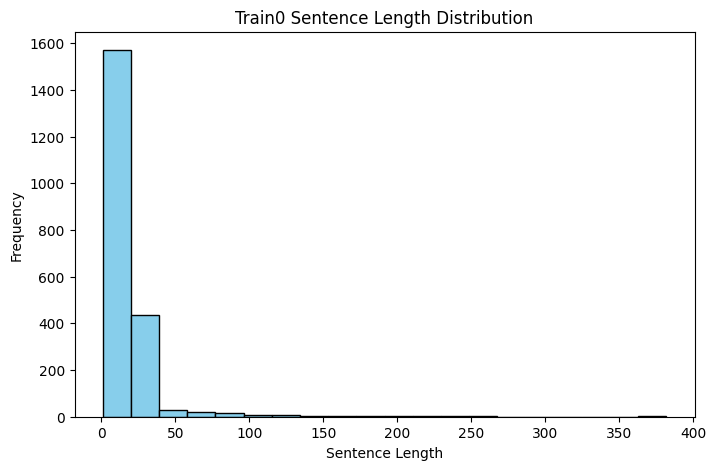

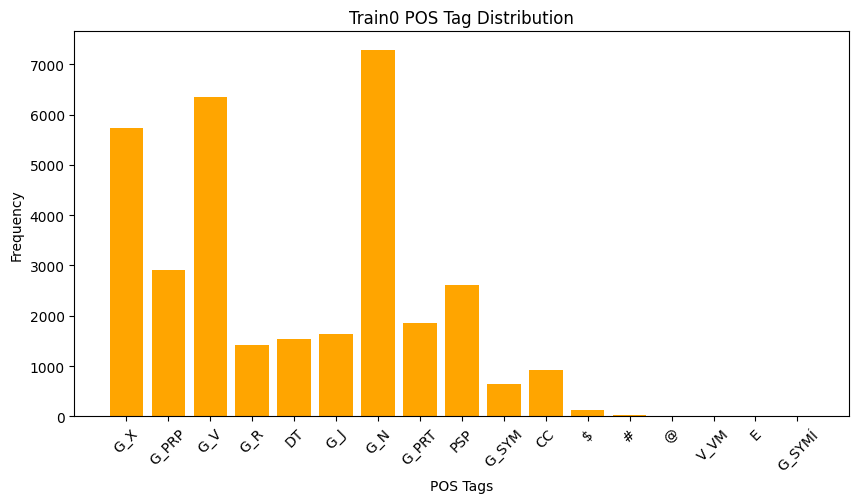

In [ ]:
dataset_analysis(train_data, "Train0")


Test0 Statistics:
Total Sentences: 526
Total Words: 8092
Unique Words: 3514
Unique POS Tags: 14
Average Sentence Length: 15.38
Max Sentence Length: 222
Min Sentence Length: 1


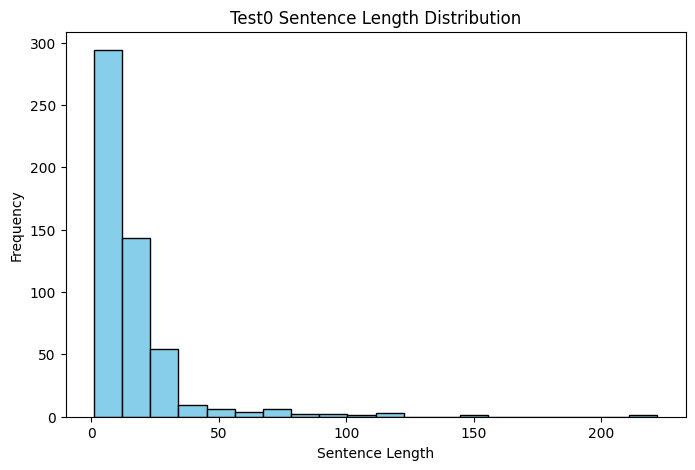

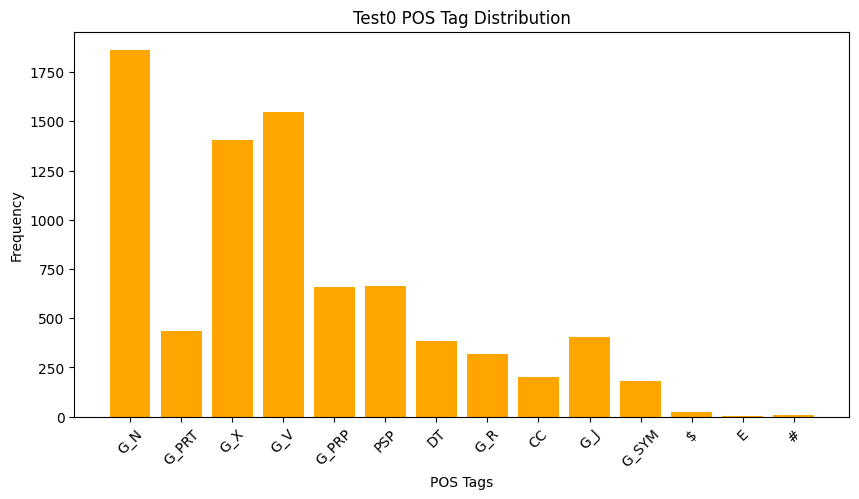

In [ ]:
dataset_analysis(test_data, "Test0")



*   Based on the data analysis, the sentence length distribution, padding the sequences to the max is a bad idea, will lead to vanishing gradient.
*   To handle this, we pad and truncate the sequences to a maxlen of the 95th percentile of the sentence lengths


In [ ]:
train_lengths = [len(sentence) for sentence, _ in train_data]
test_lengths = [len(sentence) for sentence, _ in test_data]

max_len_train = int(np.percentile(train_lengths, 95))
max_len_test = int(np.percentile(test_lengths, 95))

print(f'95th percentile for the training dataset: {max_len_train}')
print(f'95th percentile for the testing dataset: {max_len_test}')

MAX_LEN = max(max_len_train, max_len_test)
print(f'We decide to go with MAX_LEN: {MAX_LEN}')

95th percentile for the training dataset: 35
95th percentile for the testing dataset: 44
We decide to go with MAX_LEN: 44


In [ ]:
word_counter = Counter()
tag_counter = Counter()

for sentence, tags in train_data:
  word_counter.update(sentence)
  tag_counter.update(tags)

word2idx = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(), start = 1)}
tag2idx = {tag: idx for idx, (tag, _) in enumerate(tag_counter.most_common())}
word2idx["<PAD>"] = 0
tag2idx["<PAD>"] = -1
word2idx["<UNK>"] = len(word2idx)

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [ ]:
def encode(sentence, tags):
  word_indices = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
  tag_indices = [tag2idx.get(tag) for tag in tags]

  return word_indices, tag_indices

def pad_and_truncate(sentence, tags, max_len, pad_word_inx = 0, pad_tag_idx = -1):
  if len(sentence) > max_len:
    return sentence[:max_len], tags[:max_len]

  else:
    padding_needed = max_len - len(sentence)
    return sentence + [pad_word_inx]*padding_needed, tags + [pad_tag_idx]*padding_needed

In [ ]:
encoded_train_data = [encode(s, t) for s, t in train_data]
encoded_test_data = [encode(s, t) for s, t in test_data]

In [ ]:
print("For training dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_train_data[i][0]}")
  print(f"Encoded tags: {encoded_train_data[i][1]}")
  print()

print("For testing dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_test_data[i][0]}")
  print(f"Encoded tags: {encoded_test_data[i][1]}")
  print()

For training dataset:
Encoded Sentence: [3121, 40, 19, 3122, 2, 90, 339, 990, 802, 11, 3123, 3124, 372, 3125, 33, 23, 71, 1801, 803, 1291, 665, 1802, 420, 472, 1]
Encoded tags: [2, 3, 1, 8, 2, 8, 7, 6, 1, 7, 6, 0, 5, 0, 4, 3, 2, 0, 1, 6, 0, 0, 3, 0, 2]

Encoded Sentence: [1292, 1803, 1804, 243, 309, 340, 3126, 3127, 3128, 3129, 666, 1293, 373, 991, 3130, 373, 3131, 373, 3132, 3133, 373, 667, 3134]
Encoded tags: [0, 0, 6, 0, 10, 0, 6, 4, 6, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2]

Encoded Sentence: [1805, 1294, 521, 259, 1295, 38, 1806, 992, 310, 1, 243, 341, 1807, 587, 1296, 340, 161, 1297, 1, 1, 1, 1, 1, 259, 341, 1808, 10, 3135]
Encoded tags: [6, 0, 4, 0, 0, 4, 0, 4, 2, 2, 0, 2, 3, 3, 3, 0, 5, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2]

Encoded Sentence: [260, 1298, 667, 74, 340, 295, 1299, 101, 259, 5, 6, 1300, 374, 1301, 243, 5, 1809, 259, 5, 1810, 243, 5, 74, 1302, 1303, 1304, 588, 1305, 10, 3136]
Encoded tags: [10, 0, 4, 10, 0, 4, 1, 1, 0, 2, 3, 1, 3, 0, 0, 2, 0, 0, 2, 0, 0, 2, 10, 10, 1

In [ ]:
padded_train_data = [pad_and_truncate(s, t, MAX_LEN, word2idx["<PAD>"], tag2idx["<PAD>"]) for s, t in encoded_train_data]
padded_test_data = [pad_and_truncate(s, t, MAX_LEN, word2idx['<PAD>'], tag2idx['<PAD>']) for s, t in encoded_test_data]

In [ ]:
print("For training dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_train_data[i][0]}")
  print(f"Padded tags: {padded_train_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_train_data[i][0])} | Length of padded tags: {len(padded_train_data[i][1])}")
  print()

print()
print("For testing dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_test_data[i][0]}")
  print(f"Padded tags: {padded_test_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_test_data[i][0])} | Length of padded tags: {len(padded_test_data[i][1])}")
  print()

For training dataset:

Padded Sentence: [3121, 40, 19, 3122, 2, 90, 339, 990, 802, 11, 3123, 3124, 372, 3125, 33, 23, 71, 1801, 803, 1291, 665, 1802, 420, 472, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [2, 3, 1, 8, 2, 8, 7, 6, 1, 7, 6, 0, 5, 0, 4, 3, 2, 0, 1, 6, 0, 0, 3, 0, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 44 | Length of padded tags: 44

Padded Sentence: [1292, 1803, 1804, 243, 309, 340, 3126, 3127, 3128, 3129, 666, 1293, 373, 991, 3130, 373, 3131, 373, 3132, 3133, 373, 667, 3134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [0, 0, 6, 0, 10, 0, 6, 4, 6, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 44 | Length of padded tags: 44

Padded Sentence: [1805, 1294, 521, 259, 1295, 38, 1806, 992, 310, 1, 243, 341, 1807, 587, 1296, 340, 161, 1297, 1, 1, 1,

In [ ]:
X_train = torch.tensor([s for s, _ in padded_train_data])
y_train = torch.tensor([t for _, t in padded_train_data])

X_test = torch.tensor([s for s, _ in padded_test_data])
y_test = torch.tensor([t for _, t in padded_test_data])

In [ ]:
print(X_train[0])
print(y_train[0])

print()
print(X_test[0])
print(y_test[0])

tensor([3121,   40,   19, 3122,    2,   90,  339,  990,  802,   11, 3123, 3124,
         372, 3125,   33,   23,   71, 1801,  803, 1291,  665, 1802,  420,  472,
           1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor([ 2,  3,  1,  8,  2,  8,  7,  6,  1,  7,  6,  0,  5,  0,  4,  3,  2,  0,
         1,  6,  0,  0,  3,  0,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1])

tensor([9280, 9280, 3085,  267, 9280,  267, 3085,  885, 1046,    4, 6150, 2772,
         944,   84, 1722,   25, 2267,   13,    7, 1469,   25,   70,  172, 6151,
        6152, 6153, 6154,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor([ 0,  5,  2,  2,  0,  2,  2,  2,  1,  5,  0,  3,  0,  2,  4,  2,  0,  4,
         7,  0,  2,  2,  7,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1])


**Model Building:**

*   model with the embedding matrix, nn.Linear layer and the changed forward method



In [ ]:
def fasttext_vectors(embedding_file_path, embedding_dim):
  word_vectors = {}
  with open(embedding_file_path, 'r', encoding='utf-8') as f:
    next(f)
    curr_word = None
    curr_vec = []
    for line in f:
      values = line.strip().split()
      if not values:
        continue

      if curr_word is None:
        curr_word = values[0]
        curr_vec.extend(values[1:])
      else:
        curr_vec.extend(values)

        if len(curr_vec) == embedding_dim:
          word_vectors[curr_word] = np.array(curr_vec, dtype=np.float32)
          curr_word = None
          curr_vec = []

  return word_vectors


embedding_dim_vwe = 100
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors100.txt"
fasttext_vectors = fasttext_vectors(path, embedding_dim_vwe)
embedding_matrix = np.zeros((len(word2idx), embedding_dim_vwe))

for word, idx in word2idx.items():
  if word in fasttext_vectors:
    embedding_matrix[idx] = fasttext_vectors[word]
  else:
    embedding_matrix[idx] = np.random.normal(scale = 0.6, size = (embedding_dim_vwe, ))

embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
class modelV0(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(modelV0, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wi = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h = torch.tanh(embeds[:, time_step] @ self.Wi + h @ self.Wh + self.bh)
      y_t = self.fc(h)
      ops.append(y_t)

    return torch.stack(ops, dim = 1)

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

modelV0 = modelV0(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(modelV0)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|           Wi           |    6400    |
|           Wh           |    4096    |
|           bh           |     64     |
| embedding_layer.weight |   928100   |
|       fc.weight        |    1152    |
|        fc.bias         |     18     |
+------------------------+------------+
Total Trainable Params: 939830


939830

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
  criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
  opt = optim.SGD(model.parameters(), lr=lr)

  train_losses, train_accuracies = [], []

  for epoch in range(epochs):
    opt.zero_grad()
    logits = model(X_train)
    loss = criterion(logits.view(-1, logits.shape[-1]), y_train.view(-1))
    loss.backward()
    opt.step()

    predictions = logits.argmax(dim=-1)
    mask = (y_train != tag2idx["<PAD>"])
    correct = ((predictions == y_train) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.4f}")

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Loss", color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Accuracy", color='blue')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy Over Epochs")

  plt.show()

Epoch 0: Loss = 2.9052, Accuracy = 3.0008
Epoch 10: Loss = 2.7465, Accuracy = 29.5662
Epoch 20: Loss = 2.5911, Accuracy = 31.6229
Epoch 30: Loss = 2.4243, Accuracy = 31.8826
Epoch 40: Loss = 2.2513, Accuracy = 32.1143
Epoch 50: Loss = 2.1392, Accuracy = 32.3108
Epoch 60: Loss = 2.0799, Accuracy = 32.9321
Epoch 70: Loss = 2.0355, Accuracy = 33.8972
Epoch 80: Loss = 1.9998, Accuracy = 35.2836
Epoch 90: Loss = 1.9695, Accuracy = 35.4556


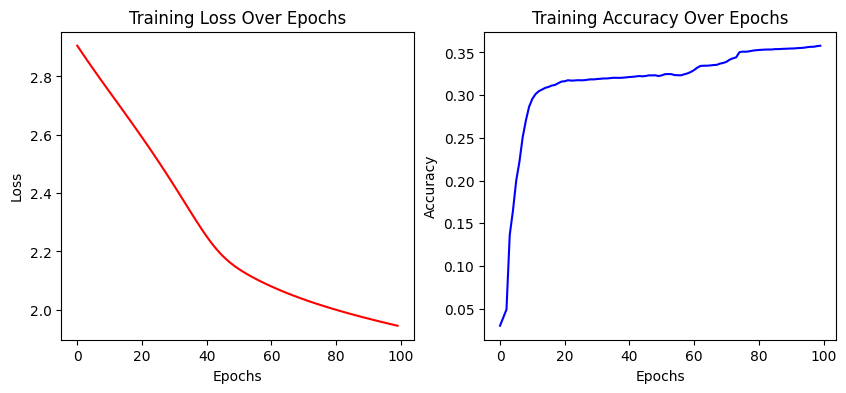

In [ ]:
train_model(modelV0, X_train, y_train, epochs=100, lr=0.1)

In [ ]:
def test_model(model, X_test, y_test, idx2tag):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_test.view(-1))

        predictions = outputs.argmax(dim=-1)
        mask = (y_test != tag2idx["<PAD>"])
        correct = ((predictions == y_test) & mask).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        print(f"Test Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy*100:.4f}")
        y_true = y_test.view(-1).cpu().numpy()
        y_pred = predictions.view(-1).cpu().numpy()

        unique_y_true = sorted(set(y_true))
        unique_y_pred = sorted(set(y_pred))
        print(f"Number of unique tags in y_true: {len(unique_y_true)}")
        print(f"Number of unique tags in y_pred: {len(unique_y_pred)}")

        cm = confusion_matrix(y_true, y_pred)
        tag_labels = [idx2tag[i] for i in unique_y_true]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_labels, yticklabels=tag_labels)
        plt.xlabel("Predicted Tags")
        plt.ylabel("Actual Tags")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, labels=unique_y_true, target_names=tag_labels, zero_division=0))


Test Loss: 1.9444
Test Accuracy: 36.7272
Number of unique tags in y_true: 15
Number of unique tags in y_pred: 7


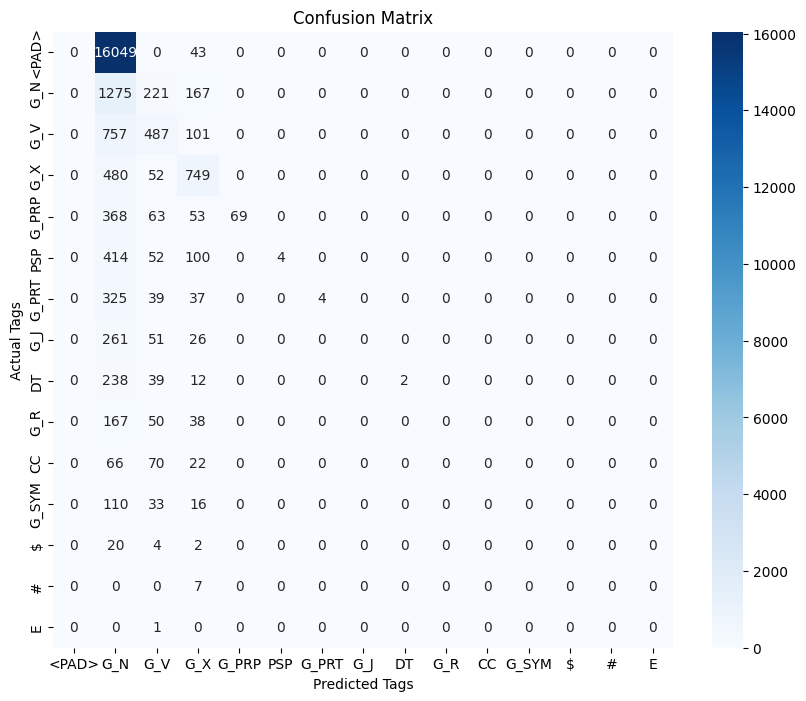

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     16092
         G_N       0.06      0.77      0.11      1663
         G_V       0.42      0.36      0.39      1345
         G_X       0.55      0.58      0.56      1281
       G_PRP       1.00      0.12      0.22       553
         PSP       1.00      0.01      0.01       570
       G_PRT       1.00      0.01      0.02       405
         G_J       0.00      0.00      0.00       338
          DT       1.00      0.01      0.01       291
         G_R       0.00      0.00      0.00       255
          CC       0.00      0.00      0.00       158
       G_SYM       0.00      0.00      0.00       159
           $       0.00      0.00      0.00        26
           #       0.00      0.00      0.00         7
           E       0.00      0.00      0.00         1

    accuracy                           0.11     23144
   macro avg       0.34      0.12      0.09     23144
wei

In [ ]:
test_model(modelV0, X_test, y_test, idx2tag)

# **Increasing Model Complexity**

In [ ]:
class modelV1(nn.Module):
    def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
        super(modelV1, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.fc = nn.Linear(hidden_dims, target_size)

        self.Wi_1 = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
        self.Wh_1 = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
        self.bh_1 = nn.Parameter(torch.zeros(hidden_dims))

        self.Wi_2 = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
        self.Wh_2 = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
        self.bh_2 = nn.Parameter(torch.zeros(hidden_dims))

    def forward(self, x):
        batch_size, seq_len = x.shape
        h1 = torch.zeros(batch_size, hidden_dims)
        h2 = torch.zeros(batch_size, hidden_dims)
        ops = []

        embeds = self.embedding_layer(x)

        for time_step in range(seq_len):
            h1 = torch.tanh(embeds[:, time_step] @ self.Wi_1 + h1 @ self.Wh_1 + self.bh_1)
            h2 = torch.tanh(h1 @ self.Wi_2 + h2 @ self.Wh_2 + self.bh_2)
            y_t = self.fc(h2)
            ops.append(y_t)

        return torch.stack(ops, dim=1)

In [ ]:
hidden_dims = 128
complex_model = modelV1(vocab_size, embedding_dims, hidden_dims, target_size)

Epoch 0: Loss = 2.9023, Accuracy = 8.9148
Epoch 10: Loss = 2.7853, Accuracy = 22.7959
Epoch 20: Loss = 2.6755, Accuracy = 22.7959
Epoch 30: Loss = 2.5624, Accuracy = 22.7959
Epoch 40: Loss = 2.4344, Accuracy = 22.7959
Epoch 50: Loss = 2.3037, Accuracy = 22.7959
Epoch 60: Loss = 2.2448, Accuracy = 22.7959
Epoch 70: Loss = 2.2125, Accuracy = 22.7959
Epoch 80: Loss = 2.1899, Accuracy = 22.8029
Epoch 90: Loss = 2.1730, Accuracy = 22.9187


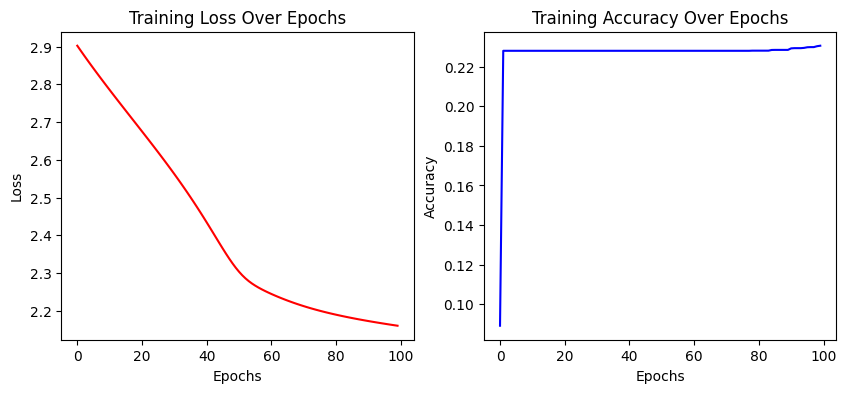

In [ ]:
train_model(complex_model, X_train, y_train, epochs=100, lr=0.1)

Test Loss: 2.1530
Test Accuracy: 23.8514
Number of unique tags in y_true: 15
Number of unique tags in y_pred: 2


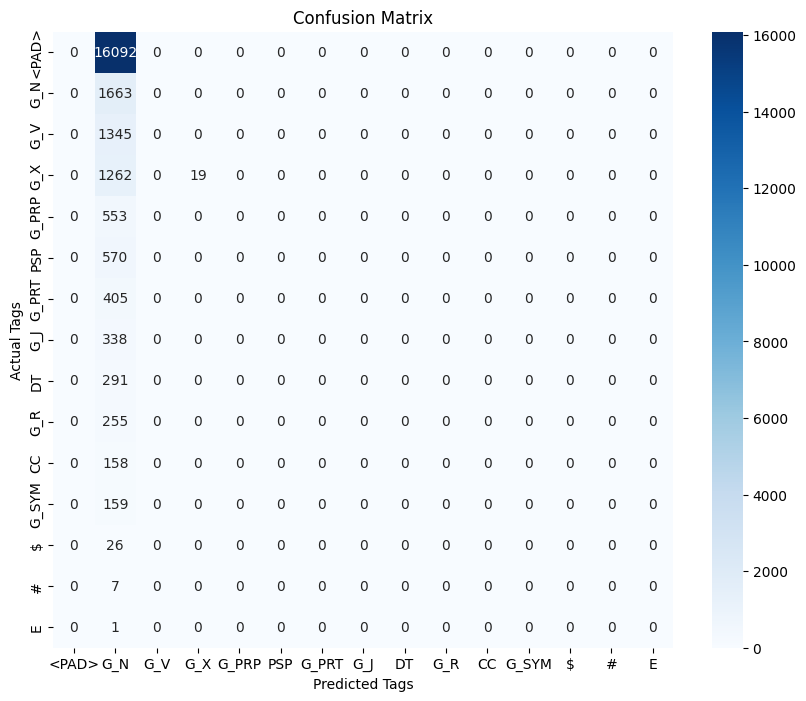

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     16092
         G_N       0.07      1.00      0.13      1663
         G_V       0.00      0.00      0.00      1345
         G_X       1.00      0.01      0.03      1281
       G_PRP       0.00      0.00      0.00       553
         PSP       0.00      0.00      0.00       570
       G_PRT       0.00      0.00      0.00       405
         G_J       0.00      0.00      0.00       338
          DT       0.00      0.00      0.00       291
         G_R       0.00      0.00      0.00       255
          CC       0.00      0.00      0.00       158
       G_SYM       0.00      0.00      0.00       159
           $       0.00      0.00      0.00        26
           #       0.00      0.00      0.00         7
           E       0.00      0.00      0.00         1

    accuracy                           0.07     23144
   macro avg       0.07      0.07      0.01     23144
wei

In [ ]:
test_model(complex_model, X_test, y_test, idx2tag)

# **Dataset - 1**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install prettytable

In [ ]:
import torch
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def load_tweet_dataset(filename):
    data = []
    sentence, tags = [], []

    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    tags.append(tag)
            else:
                if sentence:
                    data.append((sentence, tags))
                    sentence, tags = [], []

    if sentence:
        data.append((sentence, tags))
    return data

train_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Train1.txt')
test_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Test1.txt')

In [ ]:
print(f'The number of tweets in the training dataset: {len(train_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the training dataset')
print()

for i in range(5):
  print(f'Tweet: {train_data[i][0]}')
  print(f'Tags: {train_data[i][1]}')
  print()

The number of tweets in the training dataset: 2103
Displaying a few of the tweets and correspoding tagsets for the training dataset

Tweet: ['IshQ', 'waLa', '||', '~', '^ŁøVě^', '~', '||', '—', 'listening', 'to', 'Ishq', 'Wala', 'Love', '(', 'From', '"', 'Student', 'of', 'the', 'Year', '"', ')', 'The', 'DJ', 'Suketu', 'Lounge', 'Mix']
Tags: ['G_N', 'G_PRT', 'G_X', 'G_X', 'G_N', 'G_X', 'G_X', 'G_X', 'G_V', 'G_PRT', 'G_N', 'G_PRP', 'G_N', 'G_X', 'PSP', 'G_X', 'G_N', 'PSP', 'DT', 'G_N', 'G_X', 'G_X', 'DT', 'G_N', 'G_N', 'G_N', 'G_N']

Tweet: ['Ye', 'Veet', 'ke', '.', 'ad', '.', 'main', 'wo', 'ladki', 'kitni', 'gandhi', 'aur', 'over', 'acting', 'karti', 'hai', '.', 'Ye', 'girl', 'models', 'ko', 'itni', 'Galatfahmi', 'kyon', 'hoti', 'hai', 'ki', 'wo', 'badi', 'actress', 'hain']
Tags: ['G_PRP', 'G_N', 'PSP', 'G_X', 'G_N', 'G_X', 'PSP', 'G_PRP', 'G_N', 'G_R', 'G_N', 'CC', 'PSP', 'G_V', 'G_V', 'G_V', 'G_X', 'G_PRP', 'G_N', 'G_N', 'PSP', 'G_R', 'G_J', 'G_PRP', 'G_V', 'G_V', 'PSP', 'G_PRP', 'G_J

In [ ]:
print(f'The number of tweets in the testing dataset: {len(test_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the testing dataset')
print()

for i in range(5):
  print(f'Tweet: {test_data[i][0]}')
  print(f'Tags: {test_data[i][1]}')
  print()

The number of tweets in the testing dataset: 526
Displaying a few of the tweets and correspoding tagsets for the testing dataset

Tweet: ['@Tina32kaur', 'it', 'is', 'indeed', ',', 'when', 'its', 'possible', 'play', 'a', 'lovely', 'bacha', 'wala', 'track', 'for', 'me', ':)', 'Am', 'having', 'serious', 'mix', 'emotions', 'these', 'days', '.']
Tags: ['G_X', 'G_PRP', 'G_V', 'G_R', 'G_X', 'G_R', 'DT', 'G_J', 'G_V', 'DT', 'G_J', 'G_N', 'G_PRT', 'G_N', 'PSP', 'G_PRP', 'G_X', 'G_N', 'G_V', 'G_J', 'G_N', 'G_N', 'G_PRP', 'G_N', 'G_X']

Tweet: ['Life', 'Ok', 'Dream', 'Girl', 'Ek', 'Ladki', 'Deewani', 'Si', 'Upcoming', 'Tv', 'show', 'Story', '|', 'Star', 'Cast', '|', 'Timing', '|', 'Promo', 'Wiki', '|', 'Ne', 'http://t.co/X9AhZRRPiD']
Tags: ['G_N', 'G_N', 'G_J', 'G_N', 'G_SYM', 'G_N', 'G_J', 'PSP', 'G_J', 'G_N', 'G_N', 'G_N', 'G_X', 'G_N', 'G_N', 'G_X', 'G_N', 'G_X', 'G_N', 'G_N', 'G_X', 'G_N', 'G_X']

Tweet: ['Brilliant', 'Answer', 'By', 'Boy', 'Friend', 'on', 'Break', 'Up', '…', '.', 'Girl', ';'

In [ ]:
def dataset_analysis(dataset, name = 'Dataset'):
  word_counter = Counter()
  tag_counter = Counter()
  sentence_lengths = []

  for sentence, tags in dataset:
    word_counter.update(sentence)
    tag_counter.update(tags)
    sentence_lengths.append(len(sentence))

  print(f"\n{name} Statistics:")
  print(f"Total Sentences: {len(dataset)}")
  print(f"Total Words: {sum(word_counter.values())}")
  print(f"Unique Words: {len(word_counter)}")
  print(f"Unique POS Tags: {len(tag_counter)}")
  print(f"Average Sentence Length: {np.mean(sentence_lengths):.2f}")
  print(f"Max Sentence Length: {max(sentence_lengths)}")
  print(f"Min Sentence Length: {min(sentence_lengths)}")

  plt.figure(figsize=(8, 5))
  plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
  plt.xlabel("Sentence Length")
  plt.ylabel("Frequency")
  plt.title(f"{name} Sentence Length Distribution")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.bar(tag_counter.keys(), tag_counter.values(), color='orange')
  plt.xticks(rotation=45)
  plt.xlabel("POS Tags")
  plt.ylabel("Frequency")
  plt.title(f"{name} POS Tag Distribution")
  plt.show()


Train1 Statistics:
Total Sentences: 2103
Total Words: 33347
Unique Words: 9382
Unique POS Tags: 18
Average Sentence Length: 15.86
Max Sentence Length: 382
Min Sentence Length: 1


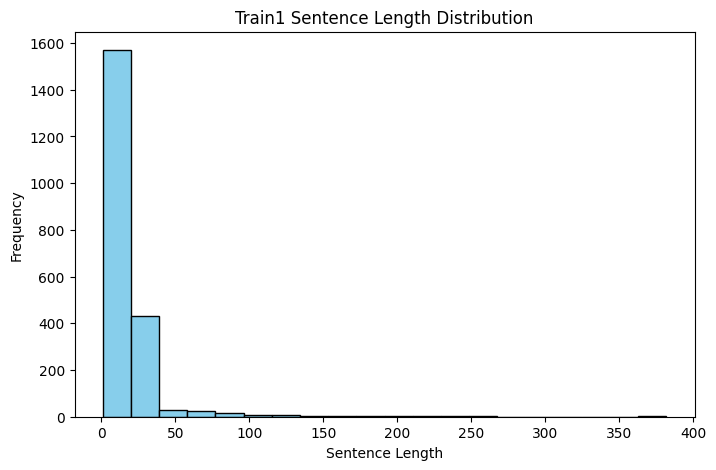

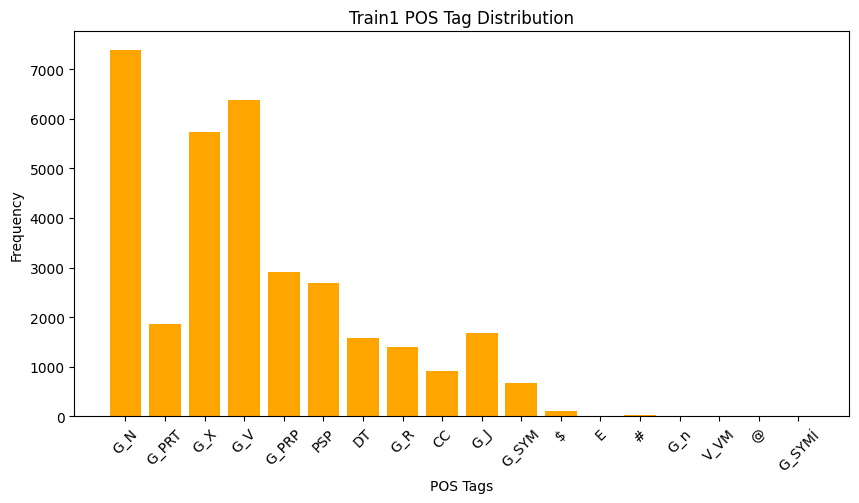

In [ ]:
dataset_analysis(train_data, "Train1")


Test1 Statistics:
Total Sentences: 526
Total Words: 7771
Unique Words: 3339
Unique POS Tags: 14
Average Sentence Length: 14.77
Max Sentence Length: 145
Min Sentence Length: 1


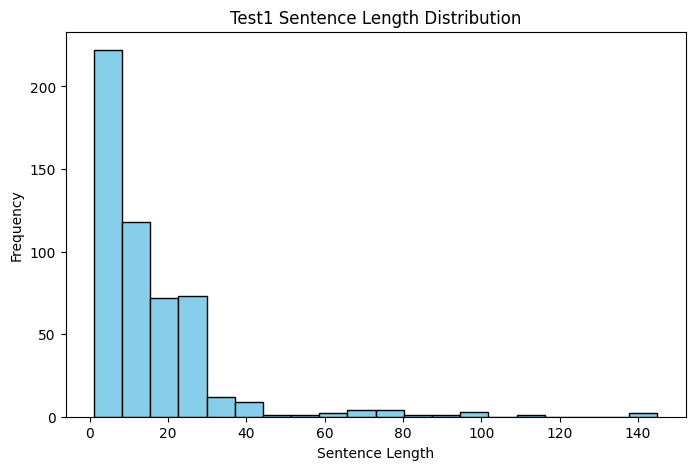

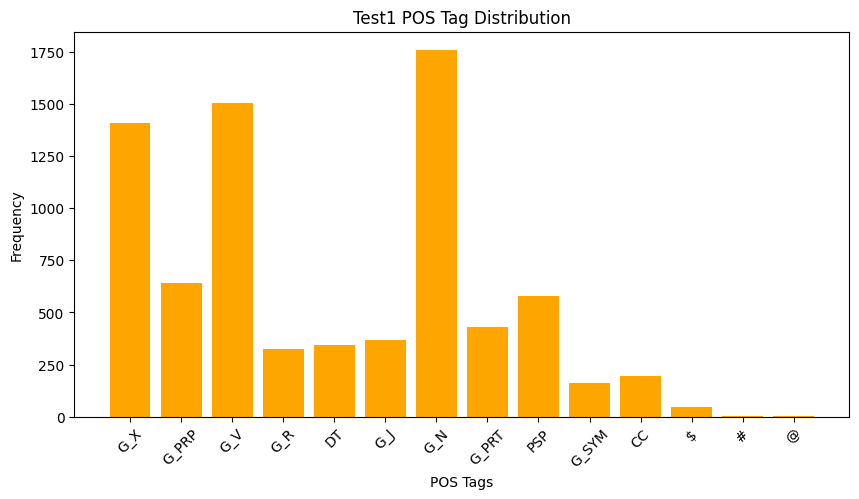

In [ ]:
dataset_analysis(test_data, "Test1")



*   Based on the data analysis, the sentence length distribution, padding the sequences to the max is a bad idea, will lead to vanishing gradient.
*   To handle this, we pad and truncate the sequences to a maxlen of the 95th percentile of the sentence lengths


In [ ]:
train_lengths = [len(sentence) for sentence, _ in train_data]
test_lengths = [len(sentence) for sentence, _ in test_data]

max_len_train = int(np.percentile(train_lengths, 95))
max_len_test = int(np.percentile(test_lengths, 95))

print(f'95th percentile for the training dataset: {max_len_train}')
print(f'95th percentile for the testing dataset: {max_len_test}')

MAX_LEN = max(max_len_train, max_len_test)
print(f'We decide to go with MAX_LEN: {MAX_LEN}')

95th percentile for the training dataset: 37
95th percentile for the testing dataset: 39
We decide to go with MAX_LEN: 39


In [ ]:
word_counter = Counter()
tag_counter = Counter()

for sentence, tags in train_data:
  word_counter.update(sentence)
  tag_counter.update(tags)

word2idx = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(), start = 1)}
tag2idx = {tag: idx for idx, (tag, _) in enumerate(tag_counter.most_common())}
word2idx["<PAD>"] = 0
tag2idx["<PAD>"] = -1
word2idx["<UNK>"] = len(word2idx)

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [ ]:
def encode(sentence, tags):
  word_indices = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
  tag_indices = [tag2idx.get(tag) for tag in tags]

  return word_indices, tag_indices

def pad_and_truncate(sentence, tags, max_len, pad_word_inx = 0, pad_tag_idx = -1):
  if len(sentence) > max_len:
    return sentence[:max_len], tags[:max_len]

  else:
    padding_needed = max_len - len(sentence)
    return sentence + [pad_word_inx]*padding_needed, tags + [pad_tag_idx]*padding_needed

In [ ]:
encoded_train_data = [encode(s, t) for s, t in train_data]
encoded_test_data = [encode(s, t) for s, t in test_data]

In [ ]:
print("For training dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_train_data[i][0]}")
  print(f"Encoded tags: {encoded_train_data[i][1]}")
  print()

print("For testing dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_test_data[i][0]}")
  print(f"Encoded tags: {encoded_test_data[i][1]}")
  print()

For training dataset:
Encoded Sentence: [3139, 3140, 1005, 210, 3141, 210, 1005, 587, 1006, 4, 1831, 1324, 421, 59, 803, 25, 1832, 12, 6, 1325, 25, 46, 146, 1833, 1834, 1835, 1836]
Encoded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0]

Encoded Sentence: [196, 3142, 22, 1, 1837, 1, 151, 197, 677, 3143, 1838, 36, 468, 1839, 1840, 3, 1, 196, 117, 1841, 24, 588, 3144, 3145, 276, 3, 13, 197, 804, 3146, 58]
Encoded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1]

Encoded Sentence: [260, 101, 3147, 589, 1842, 245, 101, 590, 1007, 152, 1326, 1008, 260, 59, 3148, 118, 1843, 46, 101, 1009, 2, 678, 677, 3149, 3150, 9]
Encoded tags: [0, 2, 0, 1, 1, 0, 2, 3, 1, 0, 4, 0, 0, 2, 1, 3, 0, 2, 2, 0, 2, 3, 0, 1, 4, 2]

Encoded Sentence: [260, 7, 101, 5, 421, 321, 2, 805, 469, 806, 97, 1844, 3151, 380, 322, 245, 7, 101, 345, 3152, 3153, 1010, 3154, 224, 3155, 9, 3156]
Encoded tags: [0, 2, 2, 3, 1, 3, 2, 3, 3, 0, 1

In [ ]:
padded_train_data = [pad_and_truncate(s, t, MAX_LEN, word2idx["<PAD>"], tag2idx["<PAD>"]) for s, t in encoded_train_data]
padded_test_data = [pad_and_truncate(s, t, MAX_LEN, word2idx['<PAD>'], tag2idx['<PAD>']) for s, t in encoded_test_data]

In [ ]:
print("For training dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_train_data[i][0]}")
  print(f"Padded tags: {padded_train_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_train_data[i][0])} | Length of padded tags: {len(padded_train_data[i][1])}")
  print()

print()
print("For testing dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_test_data[i][0]}")
  print(f"Padded tags: {padded_test_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_test_data[i][0])} | Length of padded tags: {len(padded_test_data[i][1])}")
  print()

For training dataset:

Padded Sentence: [3139, 3140, 1005, 210, 3141, 210, 1005, 587, 1006, 4, 1831, 1324, 421, 59, 803, 25, 1832, 12, 6, 1325, 25, 46, 146, 1833, 1834, 1835, 1836, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 39 | Length of padded tags: 39

Padded Sentence: [196, 3142, 22, 1, 1837, 1, 151, 197, 677, 3143, 1838, 36, 468, 1839, 1840, 3, 1, 196, 117, 1841, 24, 588, 3144, 3145, 276, 3, 13, 197, 804, 3146, 58, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 39 | Length of padded tags: 39

Padded Sentence: [260, 101, 3147, 589, 1842, 245, 101, 590, 1007, 152, 1326, 1008, 260, 59, 3148, 118, 1843, 46, 101, 1009, 2, 678, 677, 3149, 3150, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
X_train = torch.tensor([s for s, _ in padded_train_data])
y_train = torch.tensor([t for _, t in padded_train_data])

X_test = torch.tensor([s for s, _ in padded_test_data])
y_test = torch.tensor([t for _, t in padded_test_data])

In [ ]:
print(X_train[0])
print(y_train[0])

print()
print(X_test[0])
print(y_test[0])

tensor([3139, 3140, 1005,  210, 3141,  210, 1005,  587, 1006,    4, 1831, 1324,
         421,   59,  803,   25, 1832,   12,    6, 1325,   25,   46,  146, 1833,
        1834, 1835, 1836,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tensor([ 0,  5,  2,  2,  0,  2,  2,  2,  1,  5,  0,  3,  0,  2,  4,  2,  0,  4,
         7,  0,  2,  2,  7,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1])

tensor([9383,   38,   21, 9383,    2,   92,  327, 1776, 1103,   11, 9383, 9383,
         670, 9383,   33,   20,   85, 6741, 1637, 2413,  951, 6907,  434,  357,
           1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tensor([ 2,  3,  1,  8,  2,  8,  7,  6,  1,  7,  6,  0,  5,  0,  4,  3,  2,  0,
         1,  6,  0,  0,  3,  0,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1])


**Model Building:**

*   model with the embedding matrix, nn.Linear layer and the changed forward method



In [ ]:
def fasttext_vectors(embedding_file_path, embedding_dim):
  word_vectors = {}
  with open(embedding_file_path, 'r', encoding='utf-8') as f:
    next(f)
    curr_word = None
    curr_vec = []
    for line in f:
      values = line.strip().split()
      if not values:
        continue

      if curr_word is None:
        curr_word = values[0]
        curr_vec.extend(values[1:])
      else:
        curr_vec.extend(values)

        if len(curr_vec) == embedding_dim:
          word_vectors[curr_word] = np.array(curr_vec, dtype=np.float32)
          curr_word = None
          curr_vec = []

  return word_vectors


embedding_dim_vwe = 100
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors100.txt"
fasttext_vectors = fasttext_vectors(path, embedding_dim_vwe)
embedding_matrix = np.zeros((len(word2idx), embedding_dim_vwe))

for word, idx in word2idx.items():
  if word in fasttext_vectors:
    embedding_matrix[idx] = fasttext_vectors[word]
  else:
    embedding_matrix[idx] = np.random.normal(scale = 0.6, size = (embedding_dim_vwe, ))

embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
class modelV0(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(modelV0, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wi = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h = torch.tanh(embeds[:, time_step] @ self.Wi + h @ self.Wh + self.bh)
      y_t = self.fc(h)
      ops.append(y_t)

    return torch.stack(ops, dim = 1)

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

modelV0 = modelV0(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(modelV0)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|           Wi           |    6400    |
|           Wh           |    4096    |
|           bh           |     64     |
| embedding_layer.weight |   938400   |
|       fc.weight        |    1216    |
|        fc.bias         |     19     |
+------------------------+------------+
Total Trainable Params: 950195


950195

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
  criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
  opt = optim.SGD(model.parameters(), lr=lr)

  train_losses, train_accuracies = [], []

  for epoch in range(epochs):
    opt.zero_grad()
    logits = model(X_train)
    loss = criterion(logits.view(-1, logits.shape[-1]), y_train.view(-1))
    loss.backward()
    opt.step()

    predictions = logits.argmax(dim=-1)
    mask = (y_train != tag2idx["<PAD>"])
    correct = ((predictions == y_train) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.4f}")

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Loss", color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Accuracy", color='blue')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy Over Epochs")

  plt.show()

Epoch 0: Loss = 2.9616, Accuracy = 1.5876
Epoch 10: Loss = 2.8081, Accuracy = 31.1085
Epoch 20: Loss = 2.6586, Accuracy = 31.3434
Epoch 30: Loss = 2.4999, Accuracy = 32.7994
Epoch 40: Loss = 2.3281, Accuracy = 32.2191
Epoch 50: Loss = 2.1919, Accuracy = 31.3933
Epoch 60: Loss = 2.1213, Accuracy = 33.4081
Epoch 70: Loss = 2.0716, Accuracy = 33.8887
Epoch 80: Loss = 2.0332, Accuracy = 34.2553
Epoch 90: Loss = 2.0015, Accuracy = 34.5757


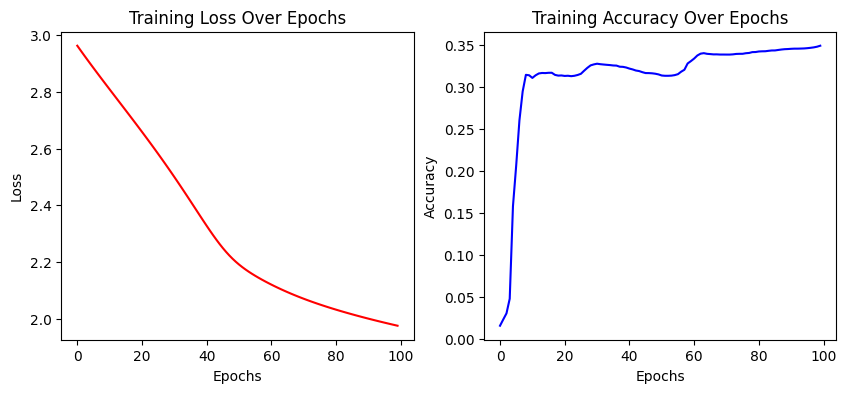

In [ ]:
train_model(modelV0, X_train, y_train, epochs=100, lr=0.1)

In [ ]:
def test_model(model, X_test, y_test, idx2tag):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_test.view(-1))

        predictions = outputs.argmax(dim=-1)
        mask = (y_test != tag2idx["<PAD>"])
        correct = ((predictions == y_test) & mask).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        print(f"Test Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy*100:.4f}")
        y_true = y_test.view(-1).cpu().numpy()
        y_pred = predictions.view(-1).cpu().numpy()

        unique_y_true = sorted(set(y_true))
        unique_y_pred = sorted(set(y_pred))
        print(f"Number of unique tags in y_true: {len(unique_y_true)}")
        print(f"Number of unique tags in y_pred: {len(unique_y_pred)}")

        cm = confusion_matrix(y_true, y_pred)
        tag_labels = [idx2tag[i] for i in unique_y_true]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_labels, yticklabels=tag_labels)
        plt.xlabel("Predicted Tags")
        plt.ylabel("Actual Tags")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, labels=unique_y_true, target_names=tag_labels, zero_division=0))


Test Loss: 1.9851
Test Accuracy: 35.9416
Number of unique tags in y_true: 15
Number of unique tags in y_pred: 5


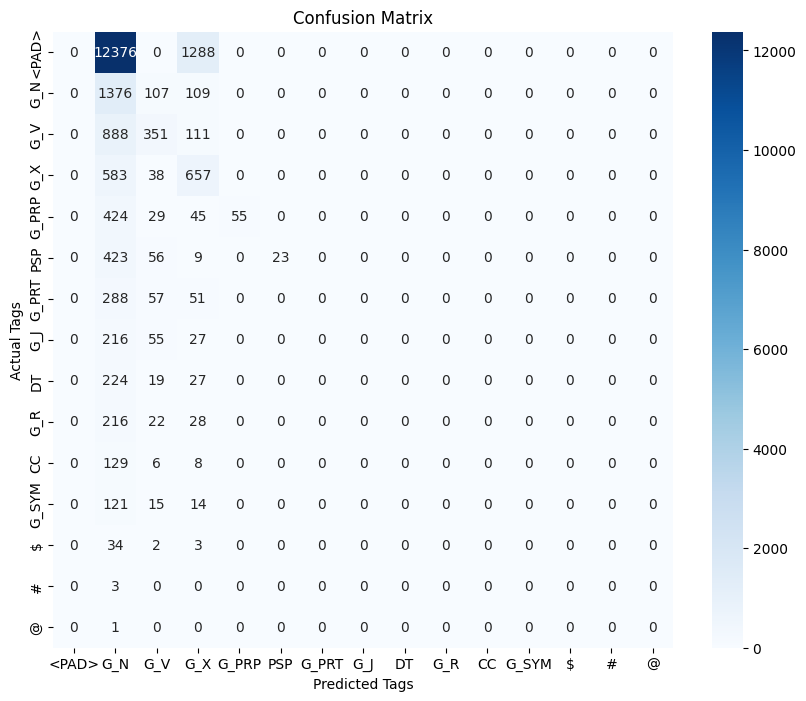

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     13664
         G_N       0.08      0.86      0.15      1592
         G_V       0.46      0.26      0.33      1350
         G_X       0.28      0.51      0.36      1278
       G_PRP       1.00      0.10      0.18       553
         PSP       1.00      0.05      0.09       511
       G_PRT       0.00      0.00      0.00       396
         G_J       0.00      0.00      0.00       298
          DT       0.00      0.00      0.00       270
         G_R       0.00      0.00      0.00       266
          CC       0.00      0.00      0.00       143
       G_SYM       0.00      0.00      0.00       150
           $       0.00      0.00      0.00        39
           #       0.00      0.00      0.00         3
           @       0.00      0.00      0.00         1

    accuracy                           0.12     20514
   macro avg       0.19      0.12      0.07     20514
wei

In [ ]:
test_model(modelV0, X_test, y_test, idx2tag)

# **Dataset - 2**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install prettytable

In [ ]:
import torch
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def load_tweet_dataset(filename):
    data = []
    sentence, tags = [], []

    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    tags.append(tag)
            else:
                if sentence:
                    data.append((sentence, tags))
                    sentence, tags = [], []

    if sentence:
        data.append((sentence, tags))
    return data

train_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Train2.txt')
test_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Test2.txt')

In [ ]:
print(f'The number of tweets in the training dataset: {len(train_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the training dataset')
print()

for i in range(5):
  print(f'Tweet: {train_data[i][0]}')
  print(f'Tags: {train_data[i][1]}')
  print()

The number of tweets in the training dataset: 2104
Displaying a few of the tweets and correspoding tagsets for the training dataset

Tweet: ['IshQ', 'waLa', '||', '~', '^ŁøVě^', '~', '||', '—', 'listening', 'to', 'Ishq', 'Wala', 'Love', '(', 'From', '"', 'Student', 'of', 'the', 'Year', '"', ')', 'The', 'DJ', 'Suketu', 'Lounge', 'Mix']
Tags: ['G_N', 'G_PRT', 'G_X', 'G_X', 'G_N', 'G_X', 'G_X', 'G_X', 'G_V', 'G_PRT', 'G_N', 'G_PRP', 'G_N', 'G_X', 'PSP', 'G_X', 'G_N', 'PSP', 'DT', 'G_N', 'G_X', 'G_X', 'DT', 'G_N', 'G_N', 'G_N', 'G_N']

Tweet: ['Ye', 'Veet', 'ke', '.', 'ad', '.', 'main', 'wo', 'ladki', 'kitni', 'gandhi', 'aur', 'over', 'acting', 'karti', 'hai', '.', 'Ye', 'girl', 'models', 'ko', 'itni', 'Galatfahmi', 'kyon', 'hoti', 'hai', 'ki', 'wo', 'badi', 'actress', 'hain']
Tags: ['G_PRP', 'G_N', 'PSP', 'G_X', 'G_N', 'G_X', 'PSP', 'G_PRP', 'G_N', 'G_R', 'G_N', 'CC', 'PSP', 'G_V', 'G_V', 'G_V', 'G_X', 'G_PRP', 'G_N', 'G_N', 'PSP', 'G_R', 'G_J', 'G_PRP', 'G_V', 'G_V', 'PSP', 'G_PRP', 'G_J

In [ ]:
print(f'The number of tweets in the testing dataset: {len(test_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the testing dataset')
print()

for i in range(5):
  print(f'Tweet: {test_data[i][0]}')
  print(f'Tags: {test_data[i][1]}')
  print()

The number of tweets in the testing dataset: 525
Displaying a few of the tweets and correspoding tagsets for the testing dataset

Tweet: ['I', 'liked', 'a', '@YouTube', 'video', 'http://t.co/Y9edo1yfRN', 'Don', '-', 'khaike', 'paan', 'banaras', 'wala', 'old', 'and', 'new', 'mix']
Tags: ['G_PRP', 'G_V', 'DT', 'G_X', 'G_N', 'G_X', 'G_N', 'G_X', 'G_V', 'G_N', 'G_N', 'G_PRP', 'G_J', 'CC', 'G_J', 'G_N']

Tweet: ['@SRKswarrior1', 'Bhai', 'Koi', 'pehchan', 'wala', 'Jo', '...', 'songs', 'compile', 'kr', 'le', 'kl', 'sis', 'ka', 'dance', 'competition', 'he', '....', 'teeno', 'mix', 'krne', 'hein', 'without', 'pause']
Tags: ['G_X', 'G_N', 'G_PRP', 'G_N', 'G_PRT', 'G_PRP', 'G_X', 'G_N', 'G_V', 'G_V', 'G_V', 'G_N', 'G_N', 'PSP', 'G_N', 'G_N', 'G_V', 'G_X', 'G_SYM', 'G_N', 'G_V', 'G_V', 'PSP', 'G_V']

Tweet: ['Boy', ':', 'Tum', 'Ladki', 'Ho', 'Ke', 'Sharab', 'Peeti', 'Ho', '??', 'Awesome', 'reply', 'by', 'Girl', ':', 'To', 'Kya', '2-4', 'Peg', 'Ke', 'Liye', 'Gender', 'Change', 'Karwaun', '???', '#I

In [ ]:
def dataset_analysis(dataset, name = 'Dataset'):
  word_counter = Counter()
  tag_counter = Counter()
  sentence_lengths = []

  for sentence, tags in dataset:
    word_counter.update(sentence)
    tag_counter.update(tags)
    sentence_lengths.append(len(sentence))

  print(f"\n{name} Statistics:")
  print(f"Total Sentences: {len(dataset)}")
  print(f"Total Words: {sum(word_counter.values())}")
  print(f"Unique Words: {len(word_counter)}")
  print(f"Unique POS Tags: {len(tag_counter)}")
  print(f"Average Sentence Length: {np.mean(sentence_lengths):.2f}")
  print(f"Max Sentence Length: {max(sentence_lengths)}")
  print(f"Min Sentence Length: {min(sentence_lengths)}")

  plt.figure(figsize=(8, 5))
  plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
  plt.xlabel("Sentence Length")
  plt.ylabel("Frequency")
  plt.title(f"{name} Sentence Length Distribution")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.bar(tag_counter.keys(), tag_counter.values(), color='orange')
  plt.xticks(rotation=45)
  plt.xlabel("POS Tags")
  plt.ylabel("Frequency")
  plt.title(f"{name} POS Tag Distribution")
  plt.show()


Train2 Statistics:
Total Sentences: 2104
Total Words: 32607
Unique Words: 9292
Unique POS Tags: 17
Average Sentence Length: 15.50
Max Sentence Length: 382
Min Sentence Length: 1


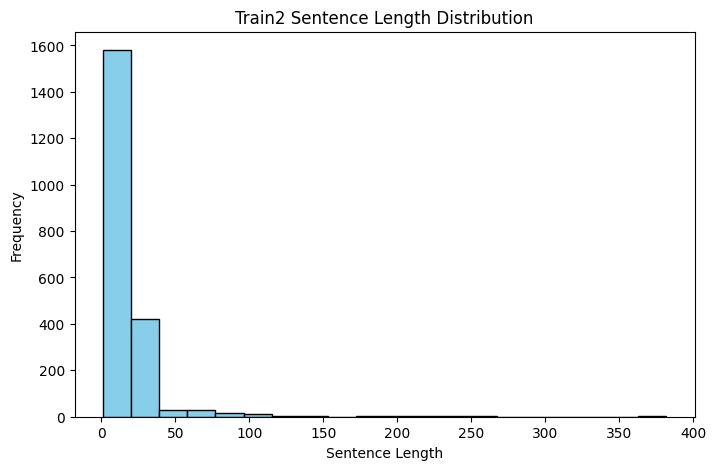

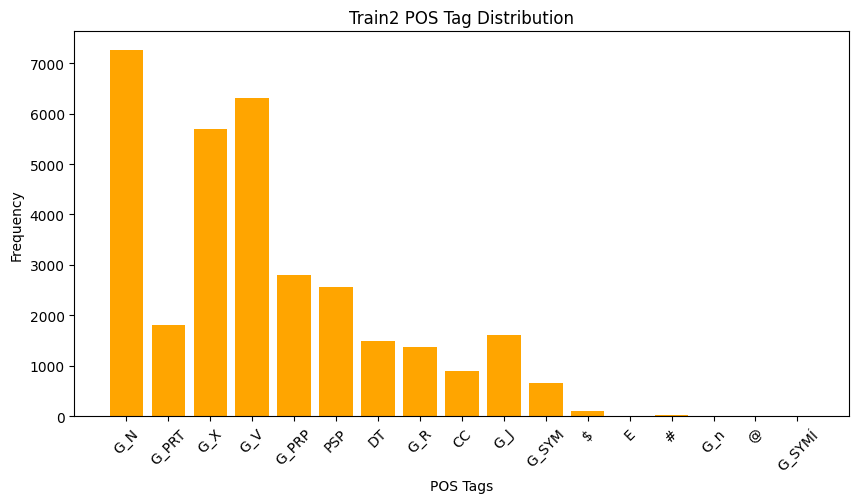

In [ ]:
dataset_analysis(train_data, "Train2")


Test2 Statistics:
Total Sentences: 525
Total Words: 8511
Unique Words: 3480
Unique POS Tags: 14
Average Sentence Length: 16.21
Max Sentence Length: 225
Min Sentence Length: 1


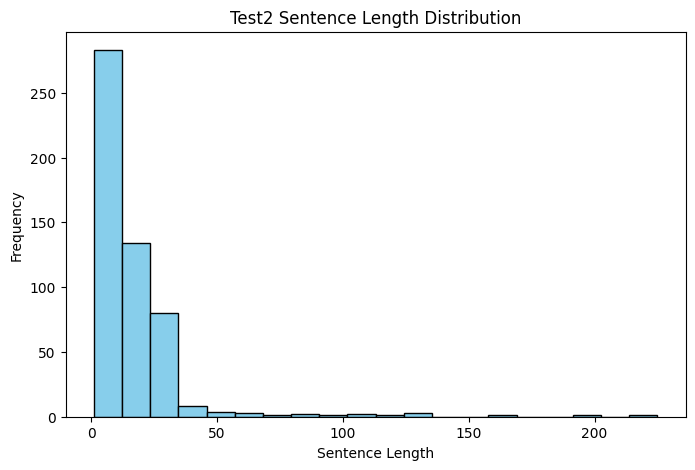

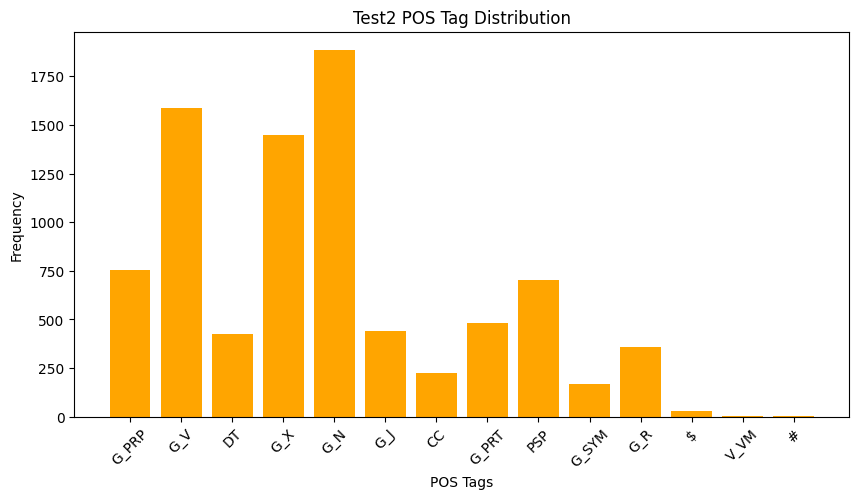

In [ ]:
dataset_analysis(test_data, "Test2")



*   Based on the data analysis, the sentence length distribution, padding the sequences to the max is a bad idea, will lead to vanishing gradient.
*   To handle this, we pad and truncate the sequences to a maxlen of the 95th percentile of the sentence lengths


In [ ]:
train_lengths = [len(sentence) for sentence, _ in train_data]
test_lengths = [len(sentence) for sentence, _ in test_data]

max_len_train = int(np.percentile(train_lengths, 95))
max_len_test = int(np.percentile(test_lengths, 95))

print(f'95th percentile for the training dataset: {max_len_train}')
print(f'95th percentile for the testing dataset: {max_len_test}')

MAX_LEN = max(max_len_train, max_len_test)
print(f'We decide to go with MAX_LEN: {MAX_LEN}')

95th percentile for the training dataset: 38
95th percentile for the testing dataset: 36
We decide to go with MAX_LEN: 38


In [ ]:
word_counter = Counter()
tag_counter = Counter()

for sentence, tags in train_data:
  word_counter.update(sentence)
  tag_counter.update(tags)

word2idx = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(), start = 1)}
tag2idx = {tag: idx for idx, (tag, _) in enumerate(tag_counter.most_common())}
word2idx["<PAD>"] = 0
tag2idx["<PAD>"] = -1
word2idx["<UNK>"] = len(word2idx)

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [ ]:
def encode(sentence, tags):
  word_indices = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
  tag_indices = [tag2idx.get(tag) for tag in tags]

  return word_indices, tag_indices

def pad_and_truncate(sentence, tags, max_len, pad_word_inx = 0, pad_tag_idx = -1):
  if len(sentence) > max_len:
    return sentence[:max_len], tags[:max_len]

  else:
    padding_needed = max_len - len(sentence)
    return sentence + [pad_word_inx]*padding_needed, tags + [pad_tag_idx]*padding_needed

In [ ]:
encoded_train_data = [encode(s, t) for s, t in train_data]
encoded_test_data = [encode(s, t) for s, t in test_data]

In [ ]:
print("For training dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_train_data[i][0]}")
  print(f"Encoded tags: {encoded_train_data[i][1]}")
  print()

print("For testing dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_test_data[i][0]}")
  print(f"Encoded tags: {encoded_test_data[i][1]}")
  print()

For training dataset:
Encoded Sentence: [3107, 3108, 1003, 220, 3109, 220, 1003, 495, 1004, 4, 1794, 1282, 443, 69, 805, 23, 1283, 12, 6, 806, 23, 54, 128, 1795, 1796, 1797, 1798]
Encoded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0]

Encoded Sentence: [194, 3110, 20, 1, 1799, 1, 205, 183, 496, 3111, 1800, 32, 497, 1801, 1802, 3, 1, 194, 146, 1803, 27, 807, 3112, 3113, 271, 3, 13, 183, 808, 3114, 45]
Encoded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1]

Encoded Sentence: [250, 102, 3115, 575, 1284, 237, 102, 679, 809, 195, 1285, 810, 250, 69, 3116, 103, 1005, 54, 102, 1006, 2, 811, 496, 3117, 3118, 10]
Encoded tags: [0, 2, 0, 1, 1, 0, 2, 3, 1, 0, 4, 0, 0, 2, 1, 3, 0, 2, 2, 0, 2, 3, 0, 1, 4, 2]

Encoded Sentence: [250, 5, 102, 7, 443, 272, 2, 1286, 406, 812, 94, 1804, 3119, 376, 377, 237, 5, 102, 444, 3120, 3121, 813, 3122, 227, 3123, 10, 3124]
Encoded tags: [0, 2, 2, 3, 1, 3, 2, 3, 3, 0, 1,

In [ ]:
padded_train_data = [pad_and_truncate(s, t, MAX_LEN, word2idx["<PAD>"], tag2idx["<PAD>"]) for s, t in encoded_train_data]
padded_test_data = [pad_and_truncate(s, t, MAX_LEN, word2idx['<PAD>'], tag2idx['<PAD>']) for s, t in encoded_test_data]

In [ ]:
print("For training dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_train_data[i][0]}")
  print(f"Padded tags: {padded_train_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_train_data[i][0])} | Length of padded tags: {len(padded_train_data[i][1])}")
  print()

print()
print("For testing dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_test_data[i][0]}")
  print(f"Padded tags: {padded_test_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_test_data[i][0])} | Length of padded tags: {len(padded_test_data[i][1])}")
  print()

For training dataset:

Padded Sentence: [3107, 3108, 1003, 220, 3109, 220, 1003, 495, 1004, 4, 1794, 1282, 443, 69, 805, 23, 1283, 12, 6, 806, 23, 54, 128, 1795, 1796, 1797, 1798, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 38 | Length of padded tags: 38

Padded Sentence: [194, 3110, 20, 1, 1799, 1, 205, 183, 496, 3111, 1800, 32, 497, 1801, 1802, 3, 1, 194, 146, 1803, 27, 807, 3112, 3113, 271, 3, 13, 183, 808, 3114, 45, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 38 | Length of padded tags: 38

Padded Sentence: [250, 102, 3115, 575, 1284, 237, 102, 679, 809, 195, 1285, 810, 250, 69, 3116, 103, 1005, 54, 102, 1006, 2, 811, 496, 3117, 3118, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [0, 2,

In [ ]:
X_train = torch.tensor([s for s, _ in padded_train_data])
y_train = torch.tensor([t for _, t in padded_train_data])

X_test = torch.tensor([s for s, _ in padded_test_data])
y_test = torch.tensor([t for _, t in padded_test_data])

In [ ]:
print(X_train[0])
print(y_train[0])

print()
print(X_test[0])
print(y_test[0])

tensor([3107, 3108, 1003,  220, 3109,  220, 1003,  495, 1004,    4, 1794, 1282,
         443,   69,  805,   23, 1283,   12,    6,  806,   23,   54,  128, 1795,
        1796, 1797, 1798,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
tensor([ 0,  5,  2,  2,  0,  2,  2,  2,  1,  5,  0,  3,  0,  2,  4,  2,  0,  4,
         7,  0,  2,  2,  7,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])

tensor([   7, 6603,   11, 1246,  821, 9293, 8423,  102, 9293, 9293, 9293,  665,
         442,    9,  216, 1565,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
tensor([ 3,  1,  7,  2,  0,  2,  0,  2,  1,  0,  0,  3,  6,  9,  6,  0, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])


**Model Building:**

*   model with the embedding matrix, nn.Linear layer and the changed forward method



In [ ]:
def fasttext_vectors(embedding_file_path, embedding_dim):
  word_vectors = {}
  with open(embedding_file_path, 'r', encoding='utf-8') as f:
    next(f)
    curr_word = None
    curr_vec = []
    for line in f:
      values = line.strip().split()
      if not values:
        continue

      if curr_word is None:
        curr_word = values[0]
        curr_vec.extend(values[1:])
      else:
        curr_vec.extend(values)

        if len(curr_vec) == embedding_dim:
          word_vectors[curr_word] = np.array(curr_vec, dtype=np.float32)
          curr_word = None
          curr_vec = []

  return word_vectors


embedding_dim_vwe = 100
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors100.txt"
fasttext_vectors = fasttext_vectors(path, embedding_dim_vwe)
embedding_matrix = np.zeros((len(word2idx), embedding_dim_vwe))

for word, idx in word2idx.items():
  if word in fasttext_vectors:
    embedding_matrix[idx] = fasttext_vectors[word]
  else:
    embedding_matrix[idx] = np.random.normal(scale = 0.6, size = (embedding_dim_vwe, ))

embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
class modelV0(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(modelV0, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wi = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h = torch.tanh(embeds[:, time_step] @ self.Wi + h @ self.Wh + self.bh)
      y_t = self.fc(h)
      ops.append(y_t)

    return torch.stack(ops, dim = 1)

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_D2 = modelV0(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model_D2)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|           Wi           |    6400    |
|           Wh           |    4096    |
|           bh           |     64     |
| embedding_layer.weight |   929400   |
|       fc.weight        |    1152    |
|        fc.bias         |     18     |
+------------------------+------------+
Total Trainable Params: 941130


941130

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
  criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
  opt = optim.SGD(model.parameters(), lr=lr)

  train_losses, train_accuracies = [], []

  for epoch in range(epochs):
    opt.zero_grad()
    logits = model(X_train)
    loss = criterion(logits.view(-1, logits.shape[-1]), y_train.view(-1))
    loss.backward()
    opt.step()

    predictions = logits.argmax(dim=-1)
    mask = (y_train != tag2idx["<PAD>"])
    correct = ((predictions == y_train) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.4f}")

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Loss", color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Accuracy", color='blue')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy Over Epochs")

  plt.show()

Epoch 0: Loss = 2.9311, Accuracy = 4.0440
Epoch 10: Loss = 2.7767, Accuracy = 26.3495
Epoch 20: Loss = 2.6253, Accuracy = 31.8200
Epoch 30: Loss = 2.4628, Accuracy = 32.3956
Epoch 40: Loss = 2.2841, Accuracy = 33.1233
Epoch 50: Loss = 2.1455, Accuracy = 33.3623
Epoch 60: Loss = 2.0835, Accuracy = 33.4130
Epoch 70: Loss = 2.0394, Accuracy = 33.5940
Epoch 80: Loss = 2.0033, Accuracy = 33.8583
Epoch 90: Loss = 1.9725, Accuracy = 34.2819


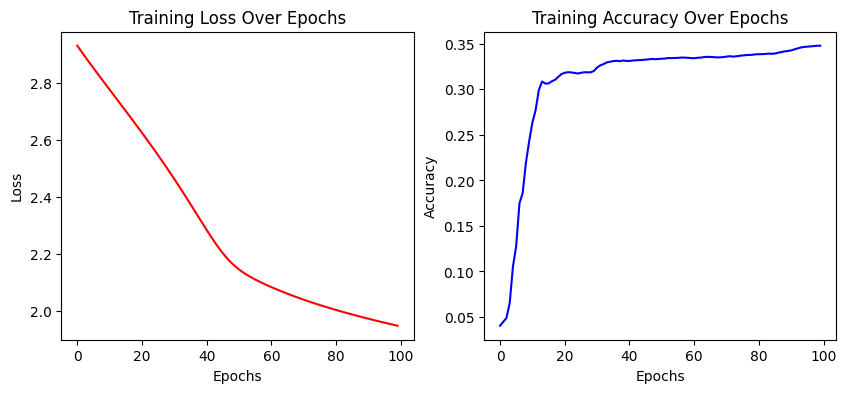

In [ ]:
train_model(model_D2, X_train, y_train, epochs=100, lr=0.1)

In [ ]:
def test_model(model, X_test, y_test, idx2tag):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_test.view(-1))

        predictions = outputs.argmax(dim=-1)
        mask = (y_test != tag2idx["<PAD>"])
        correct = ((predictions == y_test) & mask).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        print(f"Test Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy*100:.4f}")
        y_true = y_test.view(-1).cpu().numpy()
        y_pred = predictions.view(-1).cpu().numpy()

        unique_y_true = sorted(set(y_true))
        unique_y_pred = sorted(set(y_pred))
        print(f"Number of unique tags in y_true: {len(unique_y_true)}")
        print(f"Number of unique tags in y_pred: {len(unique_y_pred)}")

        cm = confusion_matrix(y_true, y_pred)
        tag_labels = [idx2tag[i] for i in unique_y_true]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_labels, yticklabels=tag_labels)
        plt.xlabel("Predicted Tags")
        plt.ylabel("Actual Tags")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, labels=unique_y_true, target_names=tag_labels, zero_division=0))


Test Loss: 1.9718
Test Accuracy: 35.0945
Number of unique tags in y_true: 14
Number of unique tags in y_pred: 5


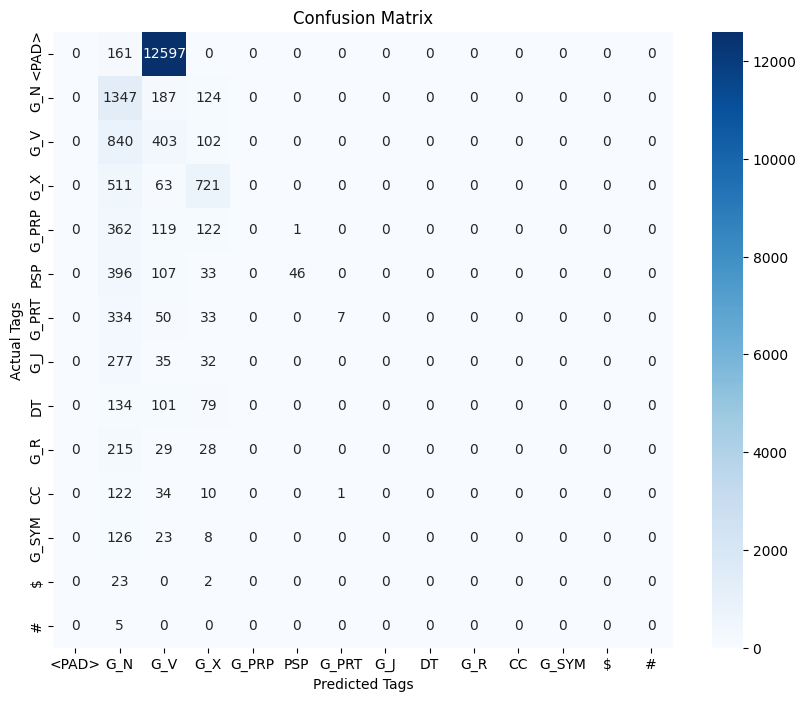

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     12758
         G_N       0.28      0.81      0.41      1658
         G_V       0.03      0.30      0.05      1345
         G_X       0.56      0.56      0.56      1295
       G_PRP       0.00      0.00      0.00       604
         PSP       0.98      0.08      0.15       582
       G_PRT       0.88      0.02      0.03       424
         G_J       0.00      0.00      0.00       344
          DT       0.00      0.00      0.00       314
         G_R       0.00      0.00      0.00       272
          CC       0.00      0.00      0.00       167
       G_SYM       0.00      0.00      0.00       157
           $       0.00      0.00      0.00        25
           #       0.00      0.00      0.00         5

    accuracy                           0.13     19950
   macro avg       0.19      0.13      0.09     19950
weighted avg       0.11      0.13      0.08     19950



In [ ]:
test_model(model_D2, X_test, y_test, idx2tag)

# **Dataset  -3**

In [ ]:
import torch
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def load_tweet_dataset(filename):
    data = []
    sentence, tags = [], []

    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    tags.append(tag)
            else:
                if sentence:
                    data.append((sentence, tags))
                    sentence, tags = [], []

    if sentence:
        data.append((sentence, tags))
    return data

train_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Train3.txt')
test_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Test3.txt')

In [ ]:
test_data[357][1][14] = 'G_SYM'

In [ ]:
test_data[357][1][14]

'G_SYM'

In [ ]:
print(f'The number of tweets in the training dataset: {len(train_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the training dataset')
print()

for i in range(5):
  print(f'Tweet: {train_data[i][0]}')
  print(f'Tags: {train_data[i][1]}')
  print()

The number of tweets in the training dataset: 2103
Displaying a few of the tweets and correspoding tagsets for the training dataset

Tweet: ['IshQ', 'waLa', '||', '~', '^ŁøVě^', '~', '||', '—', 'listening', 'to', 'Ishq', 'Wala', 'Love', '(', 'From', '"', 'Student', 'of', 'the', 'Year', '"', ')', 'The', 'DJ', 'Suketu', 'Lounge', 'Mix']
Tags: ['G_N', 'G_PRT', 'G_X', 'G_X', 'G_N', 'G_X', 'G_X', 'G_X', 'G_V', 'G_PRT', 'G_N', 'G_PRP', 'G_N', 'G_X', 'PSP', 'G_X', 'G_N', 'PSP', 'DT', 'G_N', 'G_X', 'G_X', 'DT', 'G_N', 'G_N', 'G_N', 'G_N']

Tweet: ['Ye', 'Veet', 'ke', '.', 'ad', '.', 'main', 'wo', 'ladki', 'kitni', 'gandhi', 'aur', 'over', 'acting', 'karti', 'hai', '.', 'Ye', 'girl', 'models', 'ko', 'itni', 'Galatfahmi', 'kyon', 'hoti', 'hai', 'ki', 'wo', 'badi', 'actress', 'hain']
Tags: ['G_PRP', 'G_N', 'PSP', 'G_X', 'G_N', 'G_X', 'PSP', 'G_PRP', 'G_N', 'G_R', 'G_N', 'CC', 'PSP', 'G_V', 'G_V', 'G_V', 'G_X', 'G_PRP', 'G_N', 'G_N', 'PSP', 'G_R', 'G_J', 'G_PRP', 'G_V', 'G_V', 'PSP', 'G_PRP', 'G_J

In [ ]:
print(f'The number of tweets in the testing dataset: {len(test_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the testing dataset')
print()

for i in range(5):
  print(f'Tweet: {test_data[i][0]}')
  print(f'Tags: {test_data[i][1]}')
  print()

The number of tweets in the testing dataset: 526
Displaying a few of the tweets and correspoding tagsets for the testing dataset

Tweet: ['listening', 'to', 'Ishq', 'Wala', 'Love', '(', 'From', '"', 'Student', 'of', 'the', 'Year', '"', ')', 'The', 'DJ', 'Suketu', 'Lounge', 'Mix']
Tags: ['G_V', 'G_PRT', 'G_N', 'G_PRT', 'G_N', 'G_X', 'PSP', 'G_X', 'G_N', 'PSP', 'DT', 'G_N', 'G_X', 'G_X', 'DT', 'G_N', 'G_N', 'G_N', 'G_N']

Tweet: ['1', 'Ladke', 'Ne', 'ek', 'Ladki', 'Ko', 'Call', 'Ki', 'Boy', ':', 'I', 'LOVE', 'U', 'Jaan', 'Girl-Sacchi', 'Boy-Mucchi', 'Girl', ':', 'ek', '100ka', 'Recharge', 'Krwa', 'Do', 'Plz', 'Boy-Sorry', 'Didi', 'Rong', 'Number', '.']
Tags: ['G_SYM', 'G_N', 'PSP', 'G_SYM', 'G_N', 'PSP', 'G_V', 'PSP', 'G_N', 'G_X', 'G_PRP', 'G_V', 'G_PRP', 'G_N', 'G_N', 'G_N', 'G_N', 'G_X', 'G_SYM', 'G_SYM', 'G_V', 'G_V', 'G_V', 'G_R', 'G_N', 'G_N', 'G_J', 'G_N', 'G_X']

Tweet: ['1', 'Ladke', 'Ne', 'ek', 'Ladki', 'Ko', 'Call', 'Ki', '.', 'Boy', ':', 'I', 'LOVE', 'U', 'Jaan', '.', 'Girl',

In [ ]:
def dataset_analysis(dataset, name = 'Dataset'):
  word_counter = Counter()
  tag_counter = Counter()
  sentence_lengths = []

  for sentence, tags in dataset:
    word_counter.update(sentence)
    tag_counter.update(tags)
    sentence_lengths.append(len(sentence))

  print(f"\n{name} Statistics:")
  print(f"Total Sentences: {len(dataset)}")
  print(f"Total Words: {sum(word_counter.values())}")
  print(f"Unique Words: {len(word_counter)}")
  print(f"Unique POS Tags: {len(tag_counter)}")
  print(f"Average Sentence Length: {np.mean(sentence_lengths):.2f}")
  print(f"Max Sentence Length: {max(sentence_lengths)}")
  print(f"Min Sentence Length: {min(sentence_lengths)}")

  plt.figure(figsize=(8, 5))
  plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
  plt.xlabel("Sentence Length")
  plt.ylabel("Frequency")
  plt.title(f"{name} Sentence Length Distribution")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.bar(tag_counter.keys(), tag_counter.values(), color='orange')
  plt.xticks(rotation=45)
  plt.xlabel("POS Tags")
  plt.ylabel("Frequency")
  plt.title(f"{name} POS Tag Distribution")
  plt.show()


Train3 Statistics:
Total Sentences: 2103
Total Words: 32612
Unique Words: 9293
Unique POS Tags: 17
Average Sentence Length: 15.51
Max Sentence Length: 382
Min Sentence Length: 1


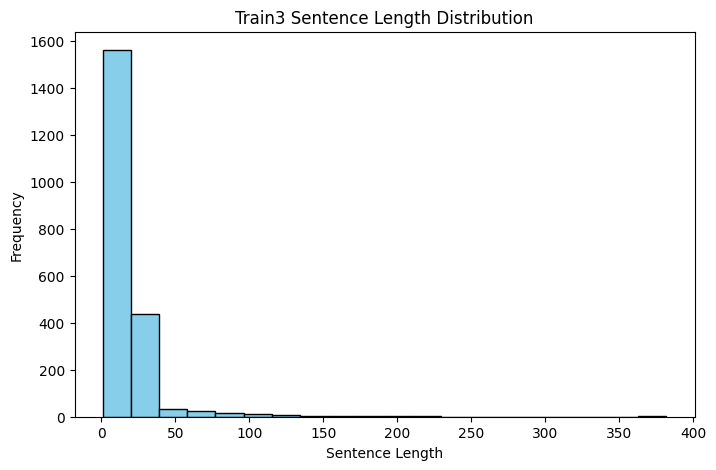

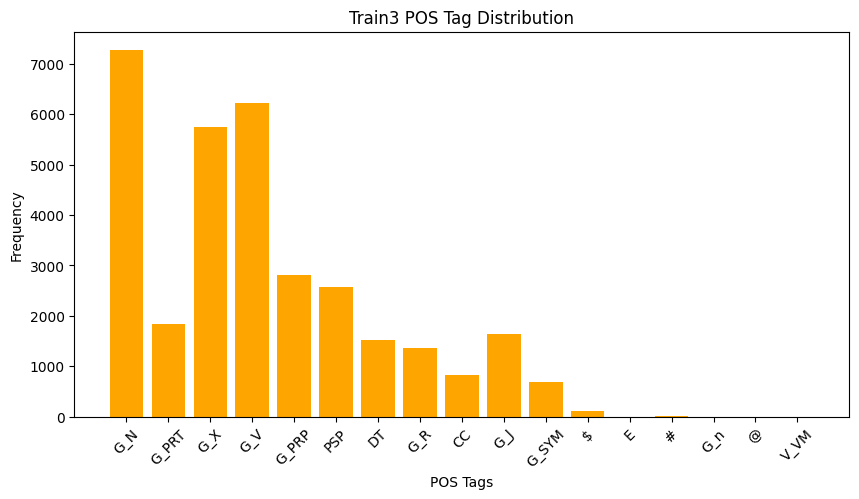

In [ ]:
dataset_analysis(train_data, "Train3")


Test3 Statistics:
Total Sentences: 526
Total Words: 8506
Unique Words: 3526
Unique POS Tags: 15
Average Sentence Length: 16.17
Max Sentence Length: 250
Min Sentence Length: 1


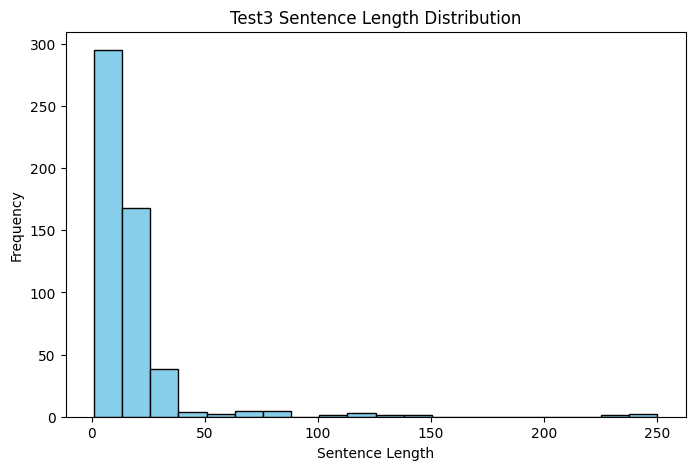

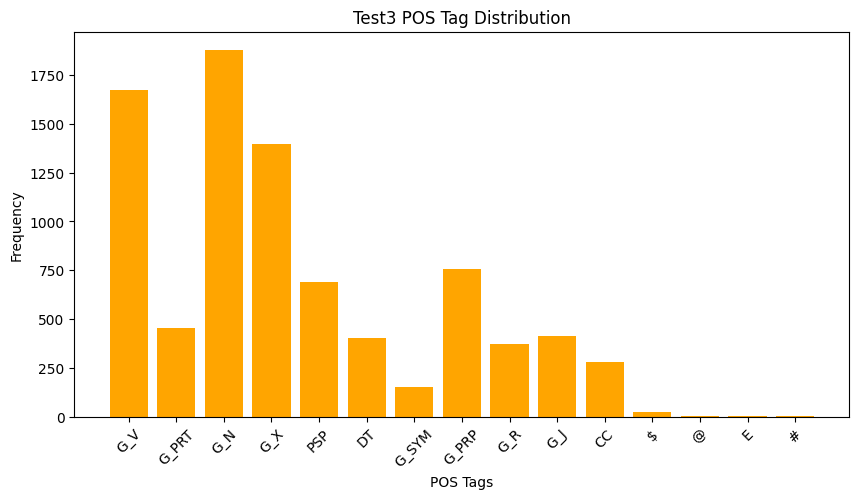

In [ ]:
dataset_analysis(test_data, "Test3")



*   Based on the data analysis, the sentence length distribution, padding the sequences to the max is a bad idea, will lead to vanishing gradient.
*   To handle this, we pad and truncate the sequences to a maxlen of the 95th percentile of the sentence lengths


In [ ]:
train_lengths = [len(sentence) for sentence, _ in train_data]
test_lengths = [len(sentence) for sentence, _ in test_data]

max_len_train = int(np.percentile(train_lengths, 95))
max_len_test = int(np.percentile(test_lengths, 95))

print(f'95th percentile for the training dataset: {max_len_train}')
print(f'95th percentile for the testing dataset: {max_len_test}')

MAX_LEN = max(max_len_train, max_len_test)
print(f'We decide to go with MAX_LEN: {MAX_LEN}')

95th percentile for the training dataset: 38
95th percentile for the testing dataset: 34
We decide to go with MAX_LEN: 38


In [ ]:
word_counter = Counter()
tag_counter = Counter()

for sentence, tags in train_data:
  word_counter.update(sentence)
  tag_counter.update(tags)

word2idx = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(), start = 1)}
tag2idx = {tag: idx for idx, (tag, _) in enumerate(tag_counter.most_common())}
word2idx["<PAD>"] = 0
tag2idx["<PAD>"] = -1
word2idx["<UNK>"] = len(word2idx)

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [ ]:
def encode(sentence, tags):
  word_indices = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
  tag_indices = [tag2idx.get(tag) for tag in tags]

  return word_indices, tag_indices

def pad_and_truncate(sentence, tags, max_len, pad_word_inx = 0, pad_tag_idx = -1):
  if len(sentence) > max_len:
    return sentence[:max_len], tags[:max_len]

  else:
    padding_needed = max_len - len(sentence)
    return sentence + [pad_word_inx]*padding_needed, tags + [pad_tag_idx]*padding_needed

In [ ]:
encoded_train_data = [encode(s, t) for s, t in train_data]
encoded_test_data = [encode(s, t) for s, t in test_data]

In [ ]:
print("For training dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_train_data[i][0]}")
  print(f"Encoded tags: {encoded_train_data[i][1]}")
  print()

print("For testing dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_test_data[i][0]}")
  print(f"Encoded tags: {encoded_test_data[i][1]}")
  print()

For training dataset:
Encoded Sentence: [3091, 3092, 974, 204, 3093, 204, 974, 975, 1265, 4, 3094, 1787, 510, 71, 1266, 26, 1788, 12, 7, 976, 26, 70, 163, 3095, 3096, 3097, 3098]
Encoded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0]

Encoded Sentence: [192, 3099, 21, 1, 1789, 1, 179, 164, 576, 3100, 3101, 34, 511, 1790, 1267, 3, 1, 192, 137, 1791, 29, 670, 3102, 3103, 372, 3, 13, 164, 1268, 3104, 46]
Encoded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1]

Encoded Sentence: [251, 111, 3105, 787, 1269, 252, 111, 671, 977, 193, 1270, 788, 251, 71, 3106, 107, 978, 70, 111, 789, 2, 672, 576, 3107, 3108, 9]
Encoded tags: [0, 2, 0, 1, 1, 0, 2, 3, 1, 0, 4, 0, 0, 2, 1, 3, 0, 2, 2, 0, 2, 3, 0, 1, 4, 2]

Encoded Sentence: [251, 5, 111, 6, 510, 338, 2, 979, 373, 790, 112, 1792, 3109, 374, 312, 252, 5, 111, 419, 3110, 3111, 1271, 3112, 231, 3113, 9, 3114]
Encoded tags: [0, 2, 2, 3, 1, 3, 2, 3, 3, 0, 1, 5,

In [ ]:
padded_train_data = [pad_and_truncate(s, t, MAX_LEN, word2idx["<PAD>"], tag2idx["<PAD>"]) for s, t in encoded_train_data]
padded_test_data = [pad_and_truncate(s, t, MAX_LEN, word2idx['<PAD>'], tag2idx['<PAD>']) for s, t in encoded_test_data]

In [ ]:
print("For training dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_train_data[i][0]}")
  print(f"Padded tags: {padded_train_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_train_data[i][0])} | Length of padded tags: {len(padded_train_data[i][1])}")
  print()

print()
print("For testing dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_test_data[i][0]}")
  print(f"Padded tags: {padded_test_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_test_data[i][0])} | Length of padded tags: {len(padded_test_data[i][1])}")
  print()

For training dataset:

Padded Sentence: [3091, 3092, 974, 204, 3093, 204, 974, 975, 1265, 4, 3094, 1787, 510, 71, 1266, 26, 1788, 12, 7, 976, 26, 70, 163, 3095, 3096, 3097, 3098, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 38 | Length of padded tags: 38

Padded Sentence: [192, 3099, 21, 1, 1789, 1, 179, 164, 576, 3100, 3101, 34, 511, 1790, 1267, 3, 1, 192, 137, 1791, 29, 670, 3102, 3103, 372, 3, 13, 164, 1268, 3104, 46, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 38 | Length of padded tags: 38

Padded Sentence: [251, 111, 3105, 787, 1269, 252, 111, 671, 977, 193, 1270, 788, 251, 71, 3106, 107, 978, 70, 111, 789, 2, 672, 576, 3107, 3108, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [0, 2, 0,

In [ ]:
X_train = torch.tensor([s for s, _ in padded_train_data])
y_train = torch.tensor([t for _, t in padded_train_data])

X_test = torch.tensor([s for s, _ in padded_test_data])
y_test = torch.tensor([t for _, t in padded_test_data])

In [ ]:
print(X_train[0])
print(y_train[0])

print()
print(X_test[0])
print(y_test[0])

tensor([3091, 3092,  974,  204, 3093,  204,  974,  975, 1265,    4, 3094, 1787,
         510,   71, 1266,   26, 1788,   12,    7,  976,   26,   70,  163, 3095,
        3096, 3097, 3098,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
tensor([ 0,  5,  2,  2,  0,  2,  2,  2,  1,  5,  0,  3,  0,  2,  4,  2,  0,  4,
         7,  0,  2,  2,  7,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])

tensor([1265,    4, 3094, 1787,  510,   71, 1266,   26, 1788,   12,    7,  976,
          26,   70,  163, 3095, 3096, 3097, 3098,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
tensor([ 1,  5,  0,  5,  0,  2,  4,  2,  0,  4,  7,  0,  2,  2,  7,  0,  0,  0,
         0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])


**Model Building:**

*   model with the embedding matrix, nn.Linear layer and the changed forward method



In [ ]:
def fasttext_vectors(embedding_file_path, embedding_dim):
  word_vectors = {}
  with open(embedding_file_path, 'r', encoding='utf-8') as f:
    next(f)
    curr_word = None
    curr_vec = []
    for line in f:
      values = line.strip().split()
      if not values:
        continue

      if curr_word is None:
        curr_word = values[0]
        curr_vec.extend(values[1:])
      else:
        curr_vec.extend(values)

        if len(curr_vec) == embedding_dim:
          word_vectors[curr_word] = np.array(curr_vec, dtype=np.float32)
          curr_word = None
          curr_vec = []

  return word_vectors


embedding_dim_vwe = 100
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors100.txt"
fasttext_vectors = fasttext_vectors(path, embedding_dim_vwe)
embedding_matrix = np.zeros((len(word2idx), embedding_dim_vwe))

for word, idx in word2idx.items():
  if word in fasttext_vectors:
    embedding_matrix[idx] = fasttext_vectors[word]
  else:
    embedding_matrix[idx] = np.random.normal(scale = 0.6, size = (embedding_dim_vwe, ))

embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
class modelV0(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(modelV0, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wi = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h = torch.tanh(embeds[:, time_step] @ self.Wi + h @ self.Wh + self.bh)
      y_t = self.fc(h)
      ops.append(y_t)

    return torch.stack(ops, dim = 1)

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_D3 = modelV0(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
  criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
  opt = optim.SGD(model.parameters(), lr=lr)

  train_losses, train_accuracies = [], []

  for epoch in range(epochs):
    opt.zero_grad()
    logits = model(X_train)
    loss = criterion(logits.view(-1, logits.shape[-1]), y_train.view(-1))
    loss.backward()
    opt.step()

    predictions = logits.argmax(dim=-1)
    mask = (y_train != tag2idx["<PAD>"])
    correct = ((predictions == y_train) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.4f}")

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Loss", color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Accuracy", color='blue')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy Over Epochs")

  plt.show()

Epoch 0: Loss = 2.8919, Accuracy = 2.4607
Epoch 10: Loss = 2.7427, Accuracy = 31.6271
Epoch 20: Loss = 2.5999, Accuracy = 33.2090
Epoch 30: Loss = 2.4522, Accuracy = 33.6430
Epoch 40: Loss = 2.2974, Accuracy = 33.8762
Epoch 50: Loss = 2.1690, Accuracy = 34.0806
Epoch 60: Loss = 2.0990, Accuracy = 34.4071
Epoch 70: Loss = 2.0505, Accuracy = 35.0814
Epoch 80: Loss = 2.0109, Accuracy = 35.3074
Epoch 90: Loss = 1.9774, Accuracy = 36.1324


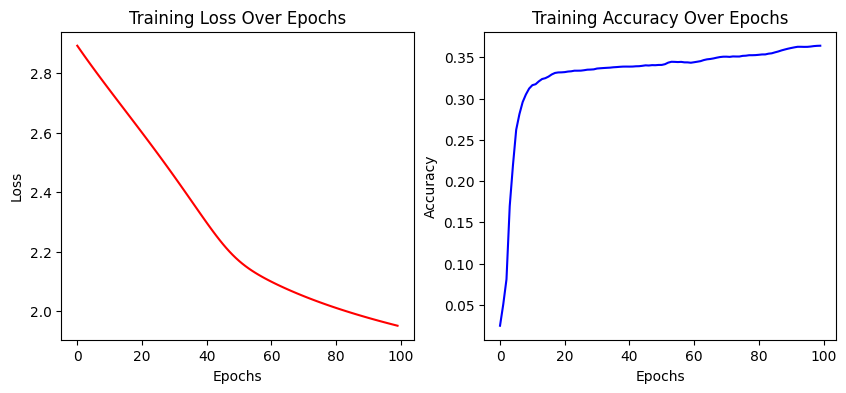

In [ ]:
train_model(model_D3, X_train, y_train, epochs=100, lr=0.1)

In [ ]:
def test_model(model, X_test, y_test, idx2tag):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_test.view(-1))

        predictions = outputs.argmax(dim=-1)
        mask = (y_test != tag2idx["<PAD>"])
        correct = ((predictions == y_test) & mask).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        print(f"Test Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy*100:.4f}")
        y_true = y_test.view(-1).cpu().numpy()
        y_pred = predictions.view(-1).cpu().numpy()

        unique_y_true = sorted(set(y_true))
        unique_y_pred = sorted(set(y_pred))
        print(f"Number of unique tags in y_true: {len(unique_y_true)}")
        print(f"Number of unique tags in y_pred: {len(unique_y_pred)}")

        cm = confusion_matrix(y_true, y_pred)
        tag_labels = [idx2tag[i] for i in unique_y_true]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_labels, yticklabels=tag_labels)
        plt.xlabel("Predicted Tags")
        plt.ylabel("Actual Tags")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, labels=unique_y_true, target_names=tag_labels, zero_division=0))


Test Loss: 1.9417
Test Accuracy: 37.1161
Number of unique tags in y_true: 16
Number of unique tags in y_pred: 6


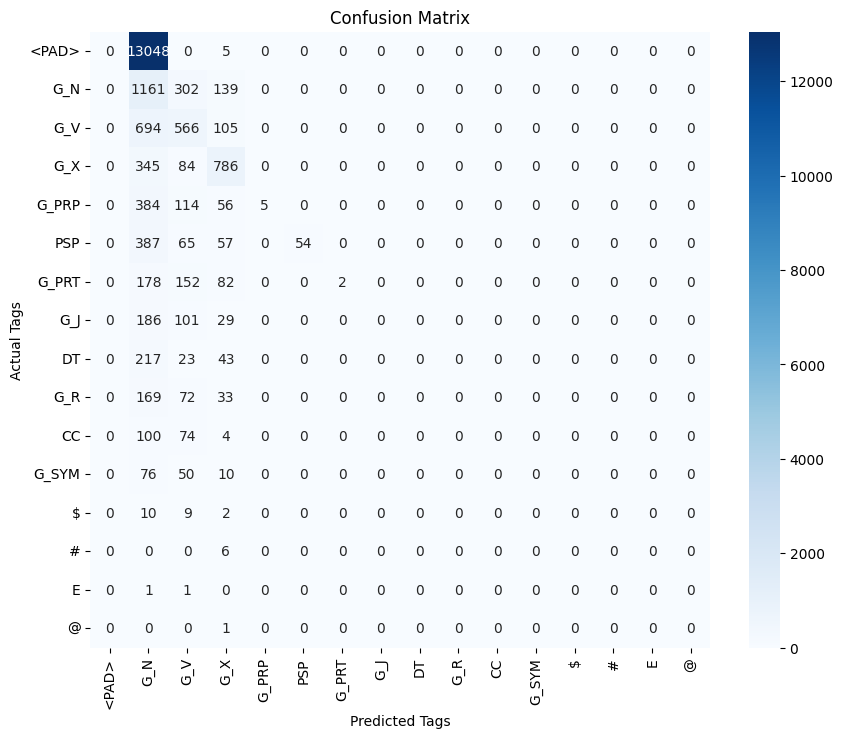

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     13053
         G_N       0.07      0.72      0.13      1602
         G_V       0.35      0.41      0.38      1365
         G_X       0.58      0.65      0.61      1215
       G_PRP       1.00      0.01      0.02       559
         PSP       1.00      0.10      0.18       563
       G_PRT       1.00      0.00      0.01       414
         G_J       0.00      0.00      0.00       316
          DT       0.00      0.00      0.00       283
         G_R       0.00      0.00      0.00       274
          CC       0.00      0.00      0.00       178
       G_SYM       0.00      0.00      0.00       136
           $       0.00      0.00      0.00        21
           #       0.00      0.00      0.00         6
           E       0.00      0.00      0.00         2
           @       0.00      0.00      0.00         1

    accuracy                           0.13     19988
   

In [ ]:
test_model(model_D3, X_test, y_test, idx2tag)

# **Dataset - 4**

In [ ]:
import torch
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def load_tweet_dataset(filename):
    data = []
    sentence, tags = [], []

    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    tags.append(tag)
            else:
                if sentence:
                    data.append((sentence, tags))
                    sentence, tags = [], []

    if sentence:
        data.append((sentence, tags))
    return data

train_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Train4.txt')
test_data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/Sequence_tagging-git/hi_dataset/CR/Test4.txt')

In [ ]:
print(f'The number of tweets in the training dataset: {len(train_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the training dataset')
print()

for i in range(5):
  print(f'Tweet: {train_data[i][0]}')
  print(f'Tags: {train_data[i][1]}')
  print()

The number of tweets in the training dataset: 2103
Displaying a few of the tweets and correspoding tagsets for the training dataset

Tweet: ['IshQ', 'waLa', '||', '~', '^ŁøVě^', '~', '||', '—', 'listening', 'to', 'Ishq', 'Wala', 'Love', '(', 'From', '"', 'Student', 'of', 'the', 'Year', '"', ')', 'The', 'DJ', 'Suketu', 'Lounge', 'Mix']
Tags: ['G_N', 'G_PRT', 'G_X', 'G_X', 'G_N', 'G_X', 'G_X', 'G_X', 'G_V', 'G_PRT', 'G_N', 'G_PRP', 'G_N', 'G_X', 'PSP', 'G_X', 'G_N', 'PSP', 'DT', 'G_N', 'G_X', 'G_X', 'DT', 'G_N', 'G_N', 'G_N', 'G_N']

Tweet: ['Ye', 'Veet', 'ke', '.', 'ad', '.', 'main', 'wo', 'ladki', 'kitni', 'gandhi', 'aur', 'over', 'acting', 'karti', 'hai', '.', 'Ye', 'girl', 'models', 'ko', 'itni', 'Galatfahmi', 'kyon', 'hoti', 'hai', 'ki', 'wo', 'badi', 'actress', 'hain']
Tags: ['G_PRP', 'G_N', 'PSP', 'G_X', 'G_N', 'G_X', 'PSP', 'G_PRP', 'G_N', 'G_R', 'G_N', 'CC', 'PSP', 'G_V', 'G_V', 'G_V', 'G_X', 'G_PRP', 'G_N', 'G_N', 'PSP', 'G_R', 'G_J', 'G_PRP', 'G_V', 'G_V', 'PSP', 'G_PRP', 'G_J

In [ ]:
print(f'The number of tweets in the testing dataset: {len(test_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the testing dataset')
print()

for i in range(5):
  print(f'Tweet: {test_data[i][0]}')
  print(f'Tags: {test_data[i][1]}')
  print()

The number of tweets in the testing dataset: 526
Displaying a few of the tweets and correspoding tagsets for the testing dataset

Tweet: ['@bionicsix1', '@phanerozoic11', '@pari_cious', 'bohut', 'achay', 'ayay', '.', 'Mixed', 'dabay', 'Wala', 'mix', 'n', 'maida', '.', 'Apna', 'hee', 'koi', 'taste', 'bana', 'liya', ':)']
Tags: ['G_X', 'G_X', 'G_X', 'G_SYM', 'G_J', 'G_V', 'G_X', 'G_J', 'G_N', 'G_PRT', 'G_N', 'CC', 'G_N', 'G_X', 'G_PRP', 'G_PRT', 'G_PRP', 'G_J', 'G_V', 'G_V', 'G_X']

Tweet: ['Boy', ':', 'Tum', 'Ladki', 'Ho', 'Ke', 'Sharab', 'Peeti', 'Ho', '??', 'Awesome', 'reply', 'by', 'Girl', ':', 'To', 'Kya', '2-4', 'Peg', 'Ke', 'Liye', 'Gender', 'Change', 'Karwaun', '???']
Tags: ['G_N', 'G_X', 'G_PRP', 'G_N', 'G_V', 'PSP', 'G_N', 'G_V', 'G_V', 'G_X', 'G_J', 'G_V', 'PSP', 'G_N', 'G_X', 'G_PRT', 'G_PRP', 'G_SYM', 'G_N', 'PSP', 'PSP', 'G_N', 'G_V', 'G_V', 'G_X']

Tweet: ['Brilliant', 'Answer', 'By', 'Boy', 'Friend', 'on', 'Break', 'Up', '…', '.', 'Girl', ';', 'Tumhe', 'Mere', 'Jaisi', 'L

In [ ]:
def dataset_analysis(dataset, name = 'Dataset'):
  word_counter = Counter()
  tag_counter = Counter()
  sentence_lengths = []

  for sentence, tags in dataset:
    word_counter.update(sentence)
    tag_counter.update(tags)
    sentence_lengths.append(len(sentence))

  print(f"\n{name} Statistics:")
  print(f"Total Sentences: {len(dataset)}")
  print(f"Total Words: {sum(word_counter.values())}")
  print(f"Unique Words: {len(word_counter)}")
  print(f"Unique POS Tags: {len(tag_counter)}")
  print(f"Average Sentence Length: {np.mean(sentence_lengths):.2f}")
  print(f"Max Sentence Length: {max(sentence_lengths)}")
  print(f"Min Sentence Length: {min(sentence_lengths)}")

  plt.figure(figsize=(8, 5))
  plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
  plt.xlabel("Sentence Length")
  plt.ylabel("Frequency")
  plt.title(f"{name} Sentence Length Distribution")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.bar(tag_counter.keys(), tag_counter.values(), color='orange')
  plt.xticks(rotation=45)
  plt.xlabel("POS Tags")
  plt.ylabel("Frequency")
  plt.title(f"{name} POS Tag Distribution")
  plt.show()


Train4 Statistics:
Total Sentences: 2103
Total Words: 32880
Unique Words: 9293
Unique POS Tags: 18
Average Sentence Length: 15.63
Max Sentence Length: 250
Min Sentence Length: 1


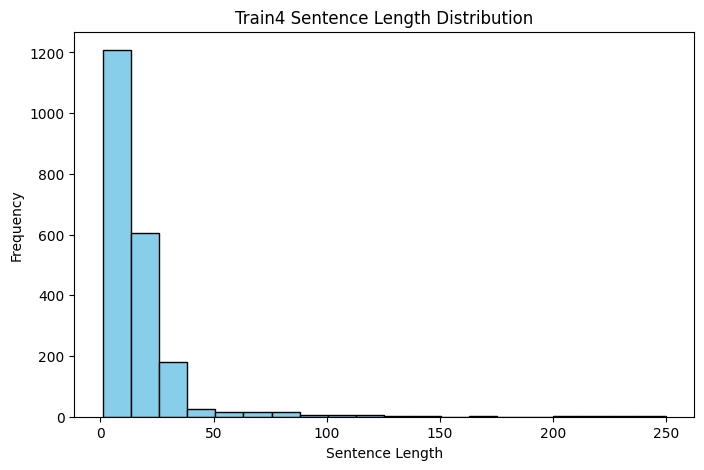

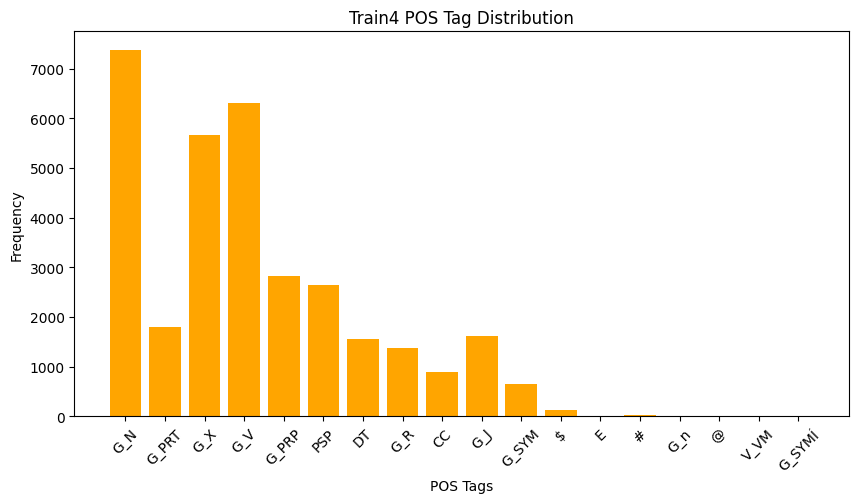

In [ ]:
dataset_analysis(train_data, "Train4")


Test4 Statistics:
Total Sentences: 526
Total Words: 8238
Unique Words: 3437
Unique POS Tags: 14
Average Sentence Length: 15.66
Max Sentence Length: 382
Min Sentence Length: 1


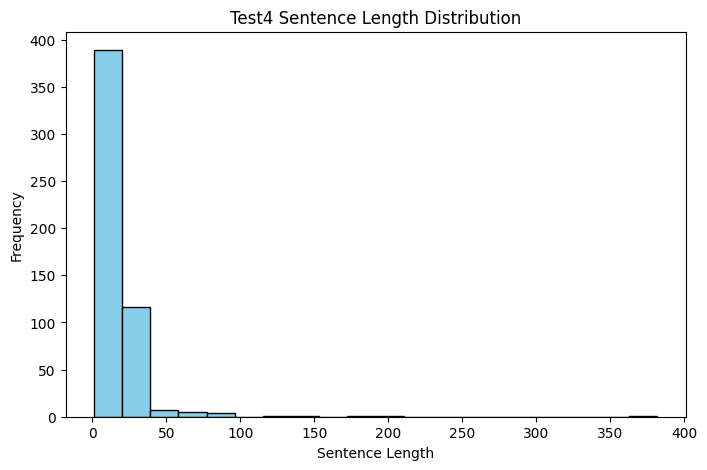

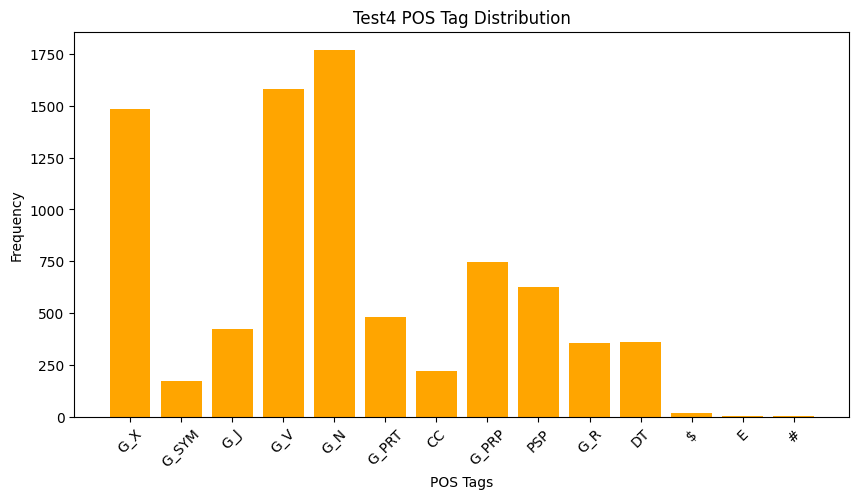

In [ ]:
dataset_analysis(test_data, "Test4")



*   Based on the data analysis, the sentence length distribution, padding the sequences to the max is a bad idea, will lead to vanishing gradient.
*   To handle this, we pad and truncate the sequences to a maxlen of the 95th percentile of the sentence lengths


In [ ]:
train_lengths = [len(sentence) for sentence, _ in train_data]
test_lengths = [len(sentence) for sentence, _ in test_data]

max_len_train = int(np.percentile(train_lengths, 95))
max_len_test = int(np.percentile(test_lengths, 95))

print(f'95th percentile for the training dataset: {max_len_train}')
print(f'95th percentile for the testing dataset: {max_len_test}')

MAX_LEN = max(max_len_train, max_len_test)
print(f'We decide to go with MAX_LEN: {MAX_LEN}')

95th percentile for the training dataset: 39
95th percentile for the testing dataset: 32
We decide to go with MAX_LEN: 39


In [ ]:
word_counter = Counter()
tag_counter = Counter()

for sentence, tags in train_data:
  word_counter.update(sentence)
  tag_counter.update(tags)

word2idx = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(), start = 1)}
tag2idx = {tag: idx for idx, (tag, _) in enumerate(tag_counter.most_common())}
word2idx["<PAD>"] = 0
tag2idx["<PAD>"] = -1
word2idx["<UNK>"] = len(word2idx)

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [ ]:
def encode(sentence, tags):
  word_indices = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
  tag_indices = [tag2idx.get(tag) for tag in tags]

  return word_indices, tag_indices

def pad_and_truncate(sentence, tags, max_len, pad_word_inx = 0, pad_tag_idx = -1):
  if len(sentence) > max_len:
    return sentence[:max_len], tags[:max_len]

  else:
    padding_needed = max_len - len(sentence)
    return sentence + [pad_word_inx]*padding_needed, tags + [pad_tag_idx]*padding_needed

In [ ]:
encoded_train_data = [encode(s, t) for s, t in train_data]
encoded_test_data = [encode(s, t) for s, t in test_data]

In [ ]:
print("For training dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_train_data[i][0]}")
  print(f"Encoded tags: {encoded_train_data[i][1]}")
  print()

print("For testing dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_test_data[i][0]}")
  print(f"Encoded tags: {encoded_test_data[i][1]}")
  print()

For training dataset:
Encoded Sentence: [3173, 3174, 1796, 228, 3175, 228, 1796, 529, 810, 4, 1797, 1798, 530, 71, 998, 28, 1286, 12, 6, 811, 28, 56, 174, 1799, 1800, 1801, 1802]
Encoded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0]

Encoded Sentence: [212, 3176, 19, 1, 1803, 1, 175, 164, 684, 3177, 1804, 35, 420, 1805, 1287, 3, 1, 212, 127, 1806, 26, 531, 3178, 3179, 381, 3, 13, 164, 1288, 3180, 44]
Encoded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1]

Encoded Sentence: [258, 116, 3181, 685, 1807, 242, 116, 592, 812, 148, 1289, 1290, 258, 71, 3182, 93, 999, 56, 116, 813, 2, 1808, 684, 3183, 3184, 8]
Encoded tags: [0, 2, 0, 1, 1, 0, 2, 3, 1, 0, 4, 0, 0, 2, 1, 3, 0, 2, 2, 0, 2, 3, 0, 1, 4, 2]

Encoded Sentence: [258, 5, 116, 7, 530, 271, 2, 1000, 421, 1001, 94, 3185, 3186, 382, 383, 242, 5, 116, 316, 3187, 3188, 1002, 3189, 243, 3190, 8, 3191]
Encoded tags: [0, 2, 2, 3, 1, 3, 2, 3, 3, 0, 1, 

In [ ]:
padded_train_data = [pad_and_truncate(s, t, MAX_LEN, word2idx["<PAD>"], tag2idx["<PAD>"]) for s, t in encoded_train_data]
padded_test_data = [pad_and_truncate(s, t, MAX_LEN, word2idx['<PAD>'], tag2idx['<PAD>']) for s, t in encoded_test_data]

In [ ]:
print("For training dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_train_data[i][0]}")
  print(f"Padded tags: {padded_train_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_train_data[i][0])} | Length of padded tags: {len(padded_train_data[i][1])}")
  print()

print()
print("For testing dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_test_data[i][0]}")
  print(f"Padded tags: {padded_test_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_test_data[i][0])} | Length of padded tags: {len(padded_test_data[i][1])}")
  print()

For training dataset:

Padded Sentence: [3173, 3174, 1796, 228, 3175, 228, 1796, 529, 810, 4, 1797, 1798, 530, 71, 998, 28, 1286, 12, 6, 811, 28, 56, 174, 1799, 1800, 1801, 1802, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [0, 5, 2, 2, 0, 2, 2, 2, 1, 5, 0, 3, 0, 2, 4, 2, 0, 4, 7, 0, 2, 2, 7, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 39 | Length of padded tags: 39

Padded Sentence: [212, 3176, 19, 1, 1803, 1, 175, 164, 684, 3177, 1804, 35, 420, 1805, 1287, 3, 1, 212, 127, 1806, 26, 531, 3178, 3179, 381, 3, 13, 164, 1288, 3180, 44, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [3, 0, 4, 2, 0, 2, 4, 3, 0, 8, 0, 9, 4, 1, 1, 1, 2, 3, 0, 0, 4, 8, 6, 3, 1, 1, 4, 3, 6, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 39 | Length of padded tags: 39

Padded Sentence: [258, 116, 3181, 685, 1807, 242, 116, 592, 812, 148, 1289, 1290, 258, 71, 3182, 93, 999, 56, 116, 813, 2, 1808, 684, 3183, 3184, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padd

In [ ]:
X_train = torch.tensor([s for s, _ in padded_train_data])
y_train = torch.tensor([t for _, t in padded_train_data])

X_test = torch.tensor([s for s, _ in padded_test_data])
y_test = torch.tensor([t for _, t in padded_test_data])

In [ ]:
print(X_train[0])
print(y_train[0])

print()
print(X_test[0])
print(y_test[0])

tensor([3173, 3174, 1796,  228, 3175,  228, 1796,  529,  810,    4, 1797, 1798,
         530,   71,  998,   28, 1286,   12,    6,  811,   28,   56,  174, 1799,
        1800, 1801, 1802,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tensor([ 0,  5,  2,  2,  0,  2,  2,  2,  1,  5,  0,  3,  0,  2,  4,  2,  0,  4,
         7,  0,  2,  2,  7,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1])

tensor([9294, 9294, 9294, 9294, 2259, 9294,    1, 9294, 9294, 1798,  947,  367,
        9294,    1, 7080, 1472,   86, 3462,  804,  345,   81,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tensor([ 2,  2,  2, 10,  6,  1,  2,  6,  0,  5,  0,  9,  0,  2,  3,  5,  3,  6,
         1,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1])


**Model Building:**

*   model with the embedding matrix, nn.Linear layer and the changed forward method



In [ ]:
def fasttext_vectors(embedding_file_path, embedding_dim):
  word_vectors = {}
  with open(embedding_file_path, 'r', encoding='utf-8') as f:
    next(f)
    curr_word = None
    curr_vec = []
    for line in f:
      values = line.strip().split()
      if not values:
        continue

      if curr_word is None:
        curr_word = values[0]
        curr_vec.extend(values[1:])
      else:
        curr_vec.extend(values)

        if len(curr_vec) == embedding_dim:
          word_vectors[curr_word] = np.array(curr_vec, dtype=np.float32)
          curr_word = None
          curr_vec = []

  return word_vectors


embedding_dim_vwe = 100
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors100.txt"
fasttext_vectors = fasttext_vectors(path, embedding_dim_vwe)
embedding_matrix = np.zeros((len(word2idx), embedding_dim_vwe))

for word, idx in word2idx.items():
  if word in fasttext_vectors:
    embedding_matrix[idx] = fasttext_vectors[word]
  else:
    embedding_matrix[idx] = np.random.normal(scale = 0.6, size = (embedding_dim_vwe, ))

embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
class modelV0(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(modelV0, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wi = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h = torch.tanh(embeds[:, time_step] @ self.Wi + h @ self.Wh + self.bh)
      y_t = self.fc(h)
      ops.append(y_t)

    return torch.stack(ops, dim = 1)

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_D4 = modelV0(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model_D4)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|           Wi           |    6400    |
|           Wh           |    4096    |
|           bh           |     64     |
| embedding_layer.weight |   929500   |
|       fc.weight        |    1216    |
|        fc.bias         |     19     |
+------------------------+------------+
Total Trainable Params: 941295


941295

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
  criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
  opt = optim.SGD(model.parameters(), lr=lr)

  train_losses, train_accuracies = [], []

  for epoch in range(epochs):
    opt.zero_grad()
    logits = model(X_train)
    loss = criterion(logits.view(-1, logits.shape[-1]), y_train.view(-1))
    loss.backward()
    opt.step()

    predictions = logits.argmax(dim=-1)
    mask = (y_train != tag2idx["<PAD>"])
    correct = ((predictions == y_train) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.4f}")

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Loss", color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Accuracy", color='blue')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy Over Epochs")

  plt.show()

Epoch 0: Loss = 2.9332, Accuracy = 6.2457
Epoch 10: Loss = 2.7934, Accuracy = 30.2051
Epoch 20: Loss = 2.6596, Accuracy = 32.1450
Epoch 30: Loss = 2.5238, Accuracy = 31.7513
Epoch 40: Loss = 2.3828, Accuracy = 31.6296
Epoch 50: Loss = 2.2438, Accuracy = 32.5316
Epoch 60: Loss = 2.1371, Accuracy = 33.2689
Epoch 70: Loss = 2.0744, Accuracy = 34.1172
Epoch 80: Loss = 2.0283, Accuracy = 34.3391
Epoch 90: Loss = 1.9904, Accuracy = 34.6684


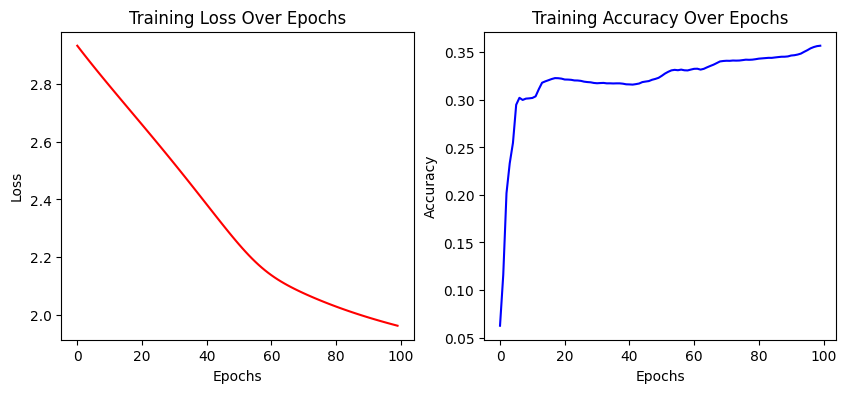

In [ ]:
train_model(model_D4, X_train, y_train, epochs=100, lr=0.1)

In [ ]:
def test_model(model, X_test, y_test, idx2tag):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_test.view(-1))

        predictions = outputs.argmax(dim=-1)
        mask = (y_test != tag2idx["<PAD>"])
        correct = ((predictions == y_test) & mask).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        print(f"Test Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy*100:.4f}")
        y_true = y_test.view(-1).cpu().numpy()
        y_pred = predictions.view(-1).cpu().numpy()

        unique_y_true = sorted(set(y_true))
        unique_y_pred = sorted(set(y_pred))
        print(f"Number of unique tags in y_true: {len(unique_y_true)}")
        print(f"Number of unique tags in y_pred: {len(unique_y_pred)}")

        cm = confusion_matrix(y_true, y_pred)
        tag_labels = [idx2tag[i] for i in unique_y_true]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_labels, yticklabels=tag_labels)
        plt.xlabel("Predicted Tags")
        plt.ylabel("Actual Tags")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, labels=unique_y_true, target_names=tag_labels, zero_division=0))


Test Loss: 1.9535
Test Accuracy: 37.0413
Number of unique tags in y_true: 14
Number of unique tags in y_pred: 5


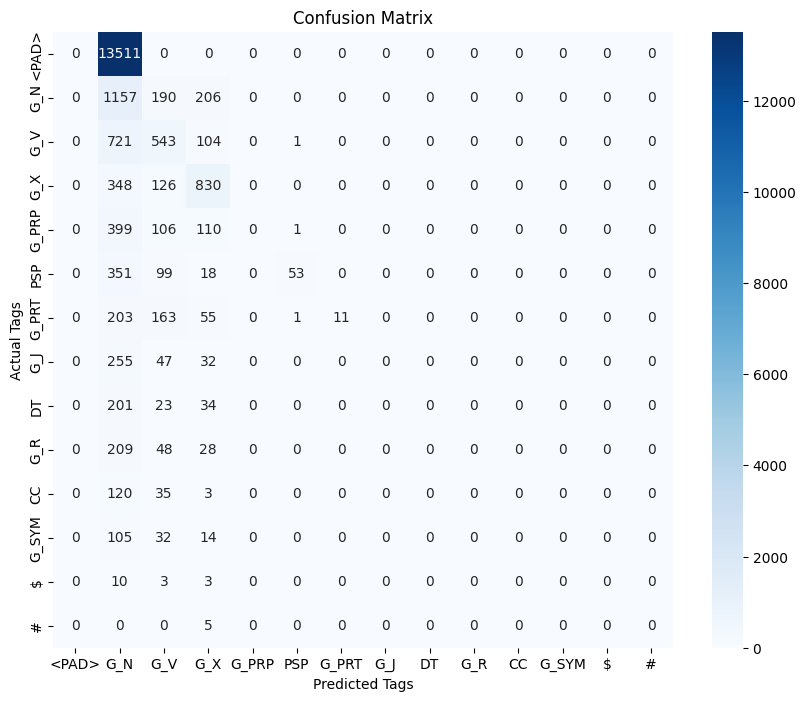

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     13511
         G_N       0.07      0.75      0.12      1553
         G_V       0.38      0.40      0.39      1369
         G_X       0.58      0.64      0.60      1304
       G_PRP       0.00      0.00      0.00       616
         PSP       0.95      0.10      0.18       521
       G_PRT       1.00      0.03      0.05       433
         G_J       0.00      0.00      0.00       334
          DT       0.00      0.00      0.00       258
         G_R       0.00      0.00      0.00       285
          CC       0.00      0.00      0.00       158
       G_SYM       0.00      0.00      0.00       151
           $       0.00      0.00      0.00        16
           #       0.00      0.00      0.00         5

    accuracy                           0.13     20514
   macro avg       0.21      0.14      0.10     20514
weighted avg       0.11      0.13      0.08     20514



In [ ]:
test_model(model_D4, X_test, y_test, idx2tag)

# **Old Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from prettytable import PrettyTable

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def load_tweet_dataset(filename):
    data = []
    sentence, tags = [], []

    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) > 2:
                    word, tag = parts[0], parts[-1]
                    sentence.append(word)
                    tags.append(tag)
            else:
                if sentence:
                    data.append((sentence, tags))
                    sentence, tags = [], []

    if sentence:
        data.append((sentence, tags))
    return data

data = load_tweet_dataset('/content/drive/MyDrive/QML-Research/Data/fb_hi_cg_train2.txt')
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)

In [ ]:
print(f'The number of tweets in the training dataset: {len(train_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the training dataset')
print()

for i in range(5):
  print(f'Tweet: {train_data[i][0]}')
  print(f'Tags: {train_data[i][1]}')
  print()

The number of tweets in the training dataset: 855
Displaying a few of the tweets and correspoding tagsets for the training dataset

Tweet: ['HIGH', 'SPEED', 'VOTE', 'MANGTE', 'H', 'RAJ', 'NHI', 'SEWA', 'ROJGAR', 'DE', 'SAKTE', 'NHI', 'CHEEN', 'RHE', 'H', 'VOTE', 'LE', 'KR', 'DESH', 'PUNJAB', 'KE', 'MALIK', 'BN', 'GAYA', 'AJIB', 'DEMOCRACY', 'H']
Tags: ['G_J', 'G_N', 'G_N', 'G_V', 'G_V', 'G_N', 'G_PRT', 'G_V', 'G_N', 'G_V', 'G_V', 'G_PRT', 'G_V', 'G_V', 'G_V', 'G_N', 'G_V', 'G_V', 'G_N', 'G_N', 'PSP', 'G_N', 'G_V', 'G_V', 'G_J', 'G_N', 'G_V']

Tweet: [':']
Tags: ['G_X']

Tweet: [':', 'My', 'brother', '&', 'I', ',', 'we', 'both', 'are', 'here', 'in', 'IITB', '.', 'He', 'never', 'tells', 'me', 'about', 'his', 'grades', 'and', 'courses', 'or', 'how', 'many', 'problems', 'he', 'has', 'faced', 'in', 'IITB', 'but', 'I', 'just', 'want', 'to', 'tell', 'him', 'whatever', 'are', 'your', 'grades', '...', 'better', 'then', 'mine', 'or', 'not', '...', 'I', 'will', 'always', 'respect', 'you', '...', 

In [ ]:
print(f'The number of tweets in the testing dataset: {len(test_data)}')
print(f'Displaying a few of the tweets and correspoding tagsets for the testing dataset')
print()

for i in range(5):
  print(f'Tweet: {test_data[i][0]}')
  print(f'Tags: {test_data[i][1]}')
  print()

The number of tweets in the testing dataset: 214
Displaying a few of the tweets and correspoding tagsets for the testing dataset

Tweet: [':', 'I']
Tags: ['G_X', 'G_PRP']

Tweet: ['Well', ',', 'to', 'folk', 'who', 'may', 'read', 'this', ',', 'please', "don't", 'get', 'into', 'relationships', 'for', 'the', 'fun', 'of', 'it', '.', 'It', 'comes', 'with', 'a', 'lot', 'of', 'responsibility', 'towards', 'the', 'other', 'person', 'and', 'unless', 'you', 'are', 'prepared', 'to', 'go', 'the', 'whole', 'mile', 'please', "don't", 'indulge', 'in', 'it', '.']
Tags: ['G_PRT', 'G_X', 'G_PRT', 'G_N', 'G_PRP', 'PSP', 'G_V', 'G_PRP', 'G_X', 'G_R', 'G_V', 'G_V', 'PSP', 'G_N', 'PSP', 'DT', 'G_J', 'PSP', 'G_PRP', 'G_X', 'G_PRP', 'G_V', 'PSP', 'DT', 'DT', 'PSP', 'G_N', 'PSP', 'DT', 'G_J', 'G_N', 'CC', 'PSP', 'G_PRP', 'PSP', 'G_V', 'G_PRT', 'G_V', 'DT', 'G_J', 'G_N', 'G_R', 'G_V', 'G_V', 'PSP', 'G_PRP', 'G_X']

Tweet: ['.', 'Right', 'from', 'the', 'beginning', 'i', 'worked', 'with', 'true', 'enthusiasm', ','

In [ ]:
def dataset_analysis(dataset, name = 'Dataset'):
  word_counter = Counter()
  tag_counter = Counter()
  sentence_lengths = []

  for sentence, tags in dataset:
    word_counter.update(sentence)
    tag_counter.update(tags)
    sentence_lengths.append(len(sentence))

  print(f"\n{name} Statistics:")
  print(f"Total Sentences: {len(dataset)}")
  print(f"Total Words: {sum(word_counter.values())}")
  print(f"Unique Words: {len(word_counter)}")
  print(f"Unique POS Tags: {len(tag_counter)}")
  print(f"Average Sentence Length: {np.mean(sentence_lengths):.2f}")
  print(f"Max Sentence Length: {max(sentence_lengths)}")
  print(f"Min Sentence Length: {min(sentence_lengths)}")

  plt.figure(figsize=(8, 5))
  plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
  plt.xlabel("Sentence Length")
  plt.ylabel("Frequency")
  plt.title(f"{name} Sentence Length Distribution")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.bar(tag_counter.keys(), tag_counter.values(), color='orange')
  plt.xticks(rotation=45)
  plt.xlabel("POS Tags")
  plt.ylabel("Frequency")
  plt.title(f"{name} POS Tag Distribution")
  plt.show()


Original Train Dataset Statistics:
Total Sentences: 855
Total Words: 15966
Unique Words: 4153
Unique POS Tags: 11
Average Sentence Length: 18.67
Max Sentence Length: 245
Min Sentence Length: 1


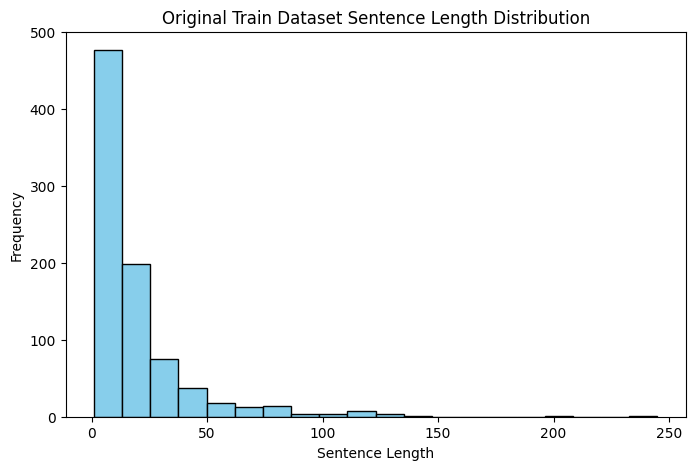

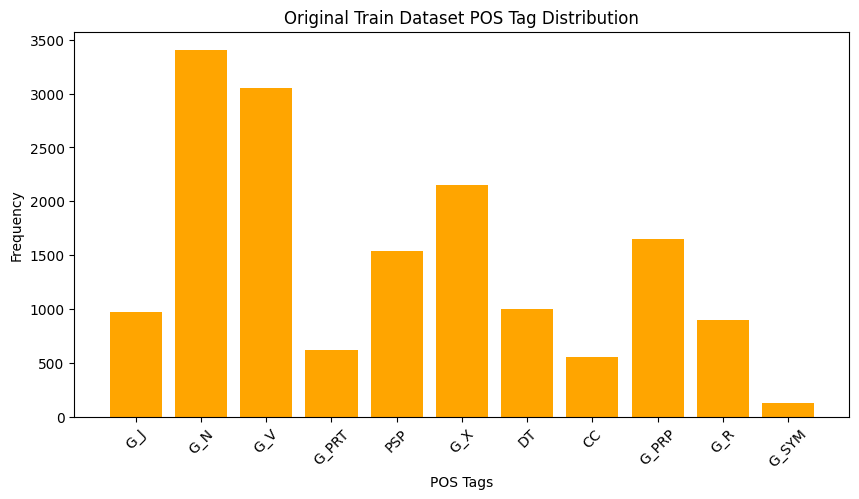

In [ ]:
dataset_analysis(train_data, "Original Train Dataset")


Original Test Dataset Statistics:
Total Sentences: 214
Total Words: 3678
Unique Words: 1504
Unique POS Tags: 11
Average Sentence Length: 17.19
Max Sentence Length: 118
Min Sentence Length: 1


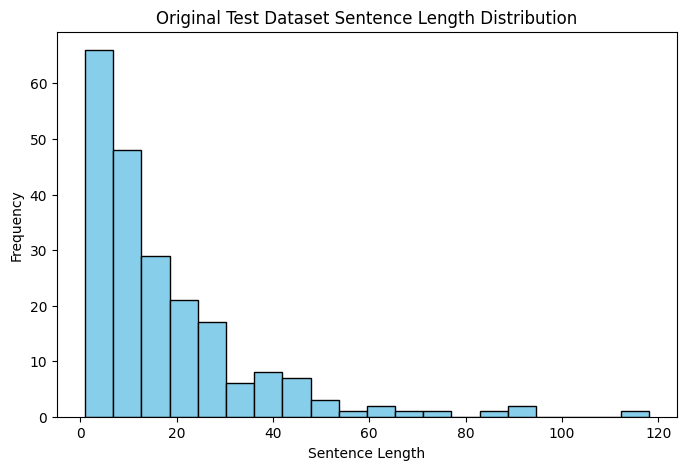

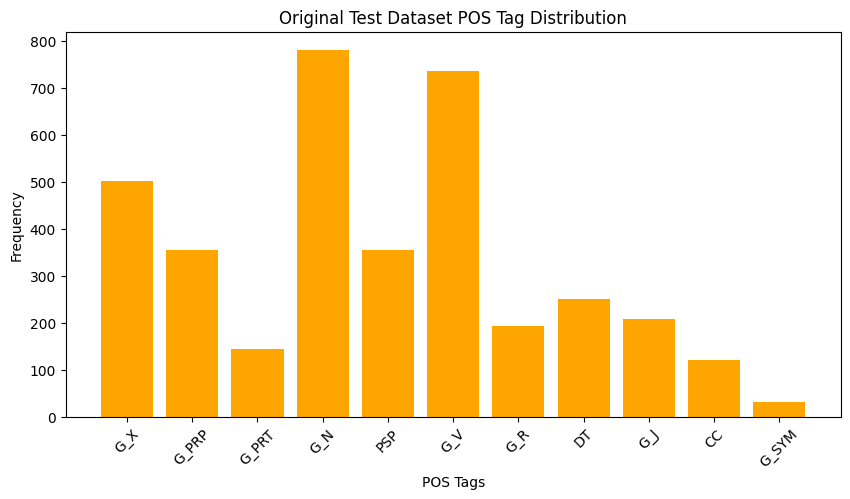

In [ ]:
dataset_analysis(test_data, "Original Test Dataset")



*   Based on the data analysis, the sentence length distribution, padding the sequences to the max is a bad idea, will lead to vanishing gradient.
*   To handle this, we pad and truncate the sequences to a maxlen of the 95th percentile of the sentence lengths


In [ ]:
train_lengths = [len(sentence) for sentence, _ in train_data]
test_lengths = [len(sentence) for sentence, _ in test_data]

max_len_train = int(np.percentile(train_lengths, 95))
max_len_test = int(np.percentile(test_lengths, 95))

print(f'95th percentile for the training dataset: {max_len_train}')
print(f'95th percentile for the testing dataset: {max_len_test}')

MAX_LEN = max(max_len_train, max_len_test)
print(f'We decide to go with MAX_LEN: {MAX_LEN}')

95th percentile for the training dataset: 66
95th percentile for the testing dataset: 49
We decide to go with MAX_LEN: 66


In [ ]:
word_counter = Counter()
tag_counter = Counter()

for sentence, tags in train_data:
  word_counter.update(sentence)
  tag_counter.update(tags)

word2idx = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(), start = 1)}
tag2idx = {tag: idx for idx, (tag, _) in enumerate(tag_counter.most_common())}
word2idx["<PAD>"] = 0
tag2idx["<PAD>"] = -1
word2idx["<UNK>"] = len(word2idx)

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [ ]:
def encode(sentence, tags):
  word_indices = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
  tag_indices = [tag2idx.get(tag) for tag in tags]

  return word_indices, tag_indices

def pad_and_truncate(sentence, tags, max_len, pad_word_inx = 0, pad_tag_idx = -1):
  if len(sentence) > max_len:
    return sentence[:max_len], tags[:max_len]

  else:
    padding_needed = max_len - len(sentence)
    return sentence + [pad_word_inx]*padding_needed, tags + [pad_tag_idx]*padding_needed

In [ ]:
encoded_train_data = [encode(s, t) for s, t in train_data]
encoded_test_data = [encode(s, t) for s, t in test_data]

In [ ]:
print("For training dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_train_data[i][0]}")
  print(f"Encoded tags: {encoded_train_data[i][1]}")
  print()

print("For testing dataset:")
for i in range(5):
  print(f"Encoded Sentence: {encoded_test_data[i][0]}")
  print(f"Encoded tags: {encoded_test_data[i][1]}")
  print()

For training dataset:
Encoded Sentence: [1502, 1503, 909, 1504, 634, 1505, 910, 1506, 1507, 1508, 1509, 910, 1510, 1511, 634, 909, 1512, 1513, 911, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 634]
Encoded tags: [6, 0, 0, 1, 1, 0, 8, 1, 0, 1, 1, 8, 1, 1, 1, 0, 1, 1, 0, 0, 4, 0, 1, 1, 6, 0, 1]

Encoded Sentence: [11]
Encoded tags: [2]

Encoded Sentence: [11, 173, 1521, 160, 2, 3, 27, 468, 35, 145, 9, 42, 1, 138, 75, 1522, 17, 80, 70, 635, 6, 636, 48, 94, 116, 912, 30, 174, 1523, 9, 42, 36, 2, 62, 175, 4, 176, 68, 390, 35, 50, 635, 8, 235, 73, 637, 48, 34, 8, 2, 67, 146, 391, 12, 8, 187, 35, 14, 1524, 9, 147, 6, 12, 35, 5, 177, 1525, 338, 392, 236, 638, 9, 14, 147, 111, 99, 1526, 20]
Encoded tags: [2, 5, 0, 9, 3, 2, 3, 0, 4, 7, 4, 0, 2, 1, 7, 1, 3, 4, 3, 0, 9, 0, 9, 7, 6, 0, 1, 1, 1, 4, 0, 9, 3, 6, 1, 8, 1, 3, 7, 4, 5, 0, 2, 6, 7, 0, 9, 8, 2, 3, 1, 7, 1, 3, 2, 3, 4, 5, 0, 4, 0, 9, 3, 4, 5, 7, 6, 0, 0, 7, 1, 4, 5, 0, 4, 5, 0, 2]

Encoded Sentence: [262, 297, 200, 1527, 71, 1528, 1529, 1530, 

In [ ]:
padded_train_data = [pad_and_truncate(s, t, MAX_LEN, word2idx["<PAD>"], tag2idx["<PAD>"]) for s, t in encoded_train_data]
padded_test_data = [pad_and_truncate(s, t, MAX_LEN, word2idx['<PAD>'], tag2idx['<PAD>']) for s, t in encoded_test_data]

In [ ]:
print("For training dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_train_data[i][0]}")
  print(f"Padded tags: {padded_train_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_train_data[i][0])} | Length of padded tags: {len(padded_train_data[i][1])}")
  print()

print()
print("For testing dataset:")
print()
for i in range(5):
  print(f"Padded Sentence: {padded_test_data[i][0]}")
  print(f"Padded tags: {padded_test_data[i][1]}")
  print(f"Length of padded sentence: {len(padded_test_data[i][0])} | Length of padded tags: {len(padded_test_data[i][1])}")
  print()

For training dataset:

Padded Sentence: [1502, 1503, 909, 1504, 634, 1505, 910, 1506, 1507, 1508, 1509, 910, 1510, 1511, 634, 909, 1512, 1513, 911, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 634, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [6, 0, 0, 1, 1, 0, 8, 1, 0, 1, 1, 8, 1, 1, 1, 0, 1, 1, 0, 0, 4, 0, 1, 1, 6, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Length of padded sentence: 66 | Length of padded tags: 66

Padded Sentence: [11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded tags: [2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

In [ ]:
X_train = torch.tensor([s for s, _ in padded_train_data])
y_train = torch.tensor([t for _, t in padded_train_data])

X_test = torch.tensor([s for s, _ in padded_test_data])
y_test = torch.tensor([t for _, t in padded_test_data])

In [ ]:
print(X_train[0])
print(y_train[0])

print()
print(X_test[0])
print(y_test[0])

tensor([1502, 1503,  909, 1504,  634, 1505,  910, 1506, 1507, 1508, 1509,  910,
        1510, 1511,  634,  909, 1512, 1513,  911, 1514, 1515, 1516, 1517, 1518,
        1519, 1520,  634,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
tensor([ 6,  0,  0,  1,  1,  0,  8,  1,  0,  1,  1,  8,  1,  1,  1,  0,  1,  1,
         0,  0,  4,  0,  1,  1,  6,  0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

tensor([11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  

**Model Building:**

*   model with the embedding matrix, nn.Linear layer and the changed forward method



In [ ]:
def create_fasttext_vectors(embedding_file_path, embedding_dim):
  word_vectors = {}
  with open(embedding_file_path, 'r', encoding='utf-8') as f:
    next(f)
    curr_word = None
    curr_vec = []
    for line in f:
      values = line.strip().split()
      if not values:
        continue

      if curr_word is None:
        curr_word = values[0]
        curr_vec.extend(values[1:])
      else:
        curr_vec.extend(values)

        if len(curr_vec) == embedding_dim:
          word_vectors[curr_word] = np.array(curr_vec, dtype=np.float32)
          curr_word = None
          curr_vec = []

  return word_vectors

In [ ]:
embedding_dim_vwe = 100
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors100.txt"
fasttext_vectors = create_fasttext_vectors(path, embedding_dim_vwe)
embedding_matrix = np.zeros((len(word2idx), embedding_dim_vwe))

for word, idx in word2idx.items():
  if word in fasttext_vectors:
    embedding_matrix[idx] = fasttext_vectors[word]
  else:
    embedding_matrix[idx] = np.random.normal(scale = 0.6, size = (embedding_dim_vwe, ))

embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
class manualRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(manualRNN, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wi = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h = torch.tanh(embeds[:, time_step] @ self.Wi + h @ self.Wh + self.bh)
      y_t = self.fc(h)
      ops.append(y_t)

    return torch.stack(ops, dim = 1)

In [ ]:
class LSTMV1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags):
        super(LSTMV1, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_tags)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_api = LSTMV1(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
count_parameters(model_api)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|  embedding.weight |   415500   |
| lstm.weight_ih_l0 |   25600    |
| lstm.weight_hh_l0 |   16384    |
|  lstm.bias_ih_l0  |    256     |
|  lstm.bias_hh_l0  |    256     |
|     fc.weight     |    768     |
|      fc.bias      |     12     |
+-------------------+------------+
Total Trainable Params: 458776


458776

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
  criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
  opt = optim.SGD(model.parameters(), lr=lr)

  train_losses, train_accuracies = [], []

  for epoch in range(epochs):
    opt.zero_grad()
    logits = model(X_train)
    loss = criterion(logits.view(-1, logits.shape[-1]), y_train.view(-1))
    loss.backward()
    opt.step()

    predictions = logits.argmax(dim=-1)
    mask = (y_train != tag2idx["<PAD>"])
    correct = ((predictions == y_train) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.4f}")

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Loss", color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Accuracy", color='blue')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy Over Epochs")

  plt.show()

# **LSTM (torch api)**

In [ ]:
model_api = LSTMV1(vocab_size, embedding_dims, hidden_dims, target_size)

Epoch 0: Loss = 2.4920, Accuracy = 7.8431
Epoch 10: Loss = 2.4286, Accuracy = 20.5504
Epoch 20: Loss = 2.3764, Accuracy = 22.0640
Epoch 30: Loss = 2.3335, Accuracy = 22.1741
Epoch 40: Loss = 2.2980, Accuracy = 22.3598
Epoch 50: Loss = 2.2685, Accuracy = 22.5112
Epoch 60: Loss = 2.2440, Accuracy = 22.6213
Epoch 70: Loss = 2.2233, Accuracy = 22.8621
Epoch 80: Loss = 2.2056, Accuracy = 23.1992
Epoch 90: Loss = 2.1901, Accuracy = 23.4950


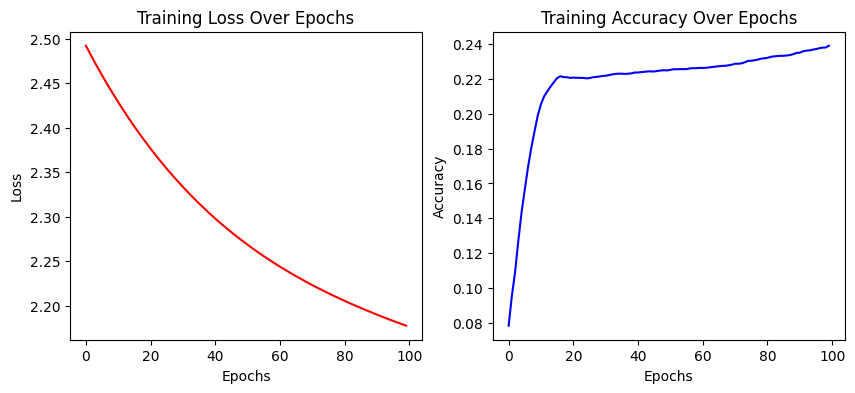

In [ ]:
train_model(model_api, X_train, y_train, epochs=100, lr=0.1)

In [ ]:
def test_model(model, X_test, y_test, idx2tag):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_test.view(-1))

        predictions = outputs.argmax(dim=-1)
        mask = (y_test != tag2idx["<PAD>"])
        correct = ((predictions == y_test) & mask).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        print(f"Test Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy*100:.4f}")
        y_true = y_test.view(-1).cpu().numpy()
        y_pred = predictions.view(-1).cpu().numpy()

        unique_y_true = sorted(set(y_true))
        unique_y_pred = sorted(set(y_pred))
        print(f"Number of unique tags in y_true: {len(unique_y_true)}")
        print(f"Number of unique tags in y_pred: {len(unique_y_pred)}")

        cm = confusion_matrix(y_true, y_pred)
        tag_labels = [idx2tag[i] for i in unique_y_true]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_labels, yticklabels=tag_labels)
        plt.xlabel("Predicted Tags")
        plt.ylabel("Actual Tags")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, labels=unique_y_true, target_names=tag_labels, zero_division=0))


Test Loss: 2.1739
Test Accuracy: 23.6041
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 3


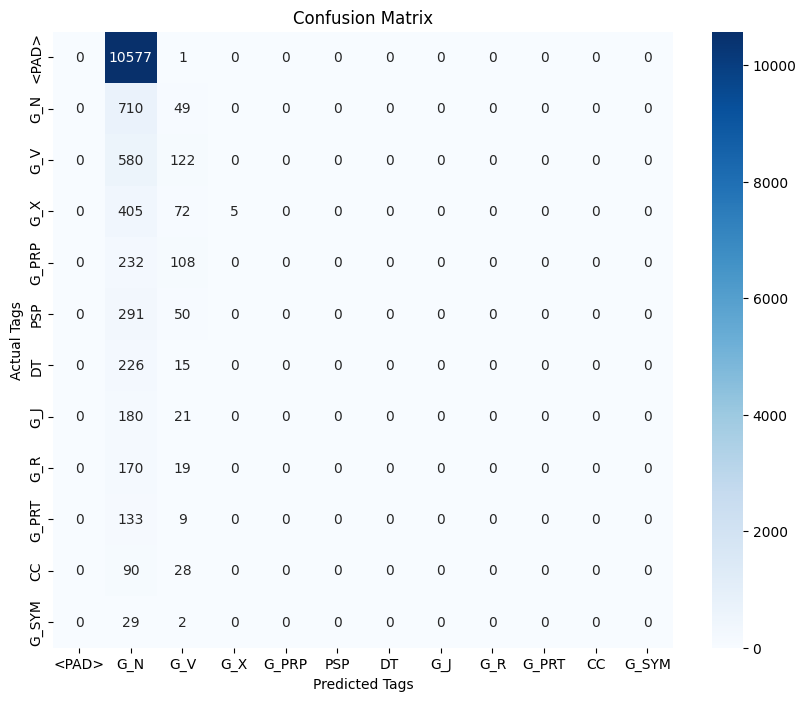

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.05      0.94      0.10       759
         G_V       0.25      0.17      0.20       702
         G_X       1.00      0.01      0.02       482
       G_PRP       0.00      0.00      0.00       340
         PSP       0.00      0.00      0.00       341
          DT       0.00      0.00      0.00       241
         G_J       0.00      0.00      0.00       201
         G_R       0.00      0.00      0.00       189
       G_PRT       0.00      0.00      0.00       142
          CC       0.00      0.00      0.00       118
       G_SYM       0.00      0.00      0.00        31

    accuracy                           0.06     14124
   macro avg       0.11      0.09      0.03     14124
weighted avg       0.05      0.06      0.02     14124



In [ ]:
test_model(model_api, X_test, y_test, idx2tag)

# **LSTM (manual)**

In [ ]:
class ManualLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dims, target_size):
    super(ManualLSTM, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wf = nn.Parameter(torch.randn(embedding_dim + hidden_dims, hidden_dims) * 0.01)
    self.Wi = nn.Parameter(torch.randn(embedding_dim + hidden_dims, hidden_dims) * 0.01)
    self.Wo = nn.Parameter(torch.randn(embedding_dim + hidden_dims, hidden_dims) * 0.01)
    self.Wc = nn.Parameter(torch.randn(embedding_dim + hidden_dims, hidden_dims) * 0.01)
    self.bf = nn.Parameter(torch.zeros(hidden_dims))
    self.bi = nn.Parameter(torch.zeros(hidden_dims))
    self.bo = nn.Parameter(torch.zeros(hidden_dims))
    self.bc = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h_t = torch.zeros(batch_size, hidden_dims)
    c_t = torch.zeros(batch_size, hidden_dims)

    embeddings = self.embedding(x)
    ops = []
    for time_step in range(seq_len):
      x_t = embeddings[:, time_step]
      conc_inp = torch.cat((x_t, h_t), dim = 1)

      f_t = torch.sigmoid(conc_inp @ self.Wf + self.bf)
      i_t = torch.sigmoid(conc_inp @ self.Wi + self.bi)
      o_t = torch.sigmoid(conc_inp @ self.Wo + self.bo)
      candidate_c = torch.tanh(conc_inp @ self.Wc + self.bc)

      c_t = f_t * c_t + i_t * candidate_c
      h_t = o_t * torch.tanh(c_t)
      ops.append(h_t)

    outputs = torch.stack(ops, dim = 1)
    return self.fc(outputs)

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_manual = ManualLSTM(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
count_parameters(model_manual)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|        Wf        |   10496    |
|        Wi        |   10496    |
|        Wo        |   10496    |
|        Wc        |   10496    |
|        bf        |     64     |
|        bi        |     64     |
|        bo        |     64     |
|        bc        |     64     |
| embedding.weight |   415500   |
|    fc.weight     |    768     |
|     fc.bias      |     12     |
+------------------+------------+
Total Trainable Params: 458520


458520

Epoch 0: Loss = 2.4567, Accuracy = 12.2188
Epoch 10: Loss = 2.4057, Accuracy = 20.9082
Epoch 20: Loss = 2.3633, Accuracy = 22.2222
Epoch 30: Loss = 2.3279, Accuracy = 21.6856
Epoch 40: Loss = 2.2984, Accuracy = 21.6856
Epoch 50: Loss = 2.2736, Accuracy = 21.6856
Epoch 60: Loss = 2.2526, Accuracy = 21.6856
Epoch 70: Loss = 2.2345, Accuracy = 21.6856
Epoch 80: Loss = 2.2187, Accuracy = 21.6856
Epoch 90: Loss = 2.2047, Accuracy = 21.7544


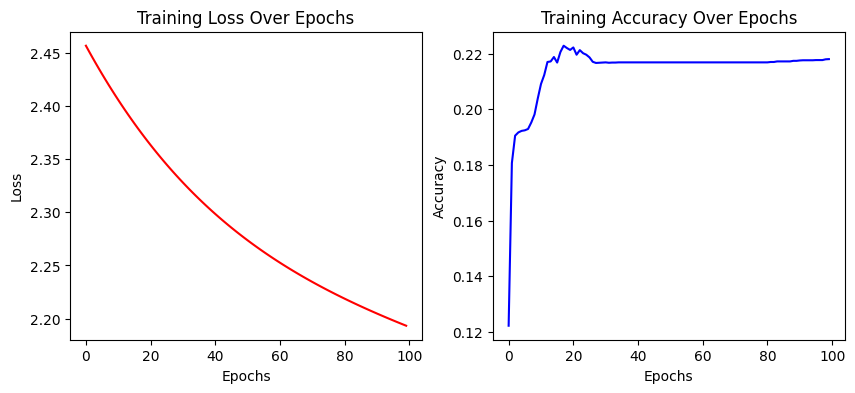

In [ ]:
train_model(model_manual, X_train, y_train, epochs=100, lr=0.1)

Test Loss: 2.1938
Test Accuracy: 21.5172
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 2


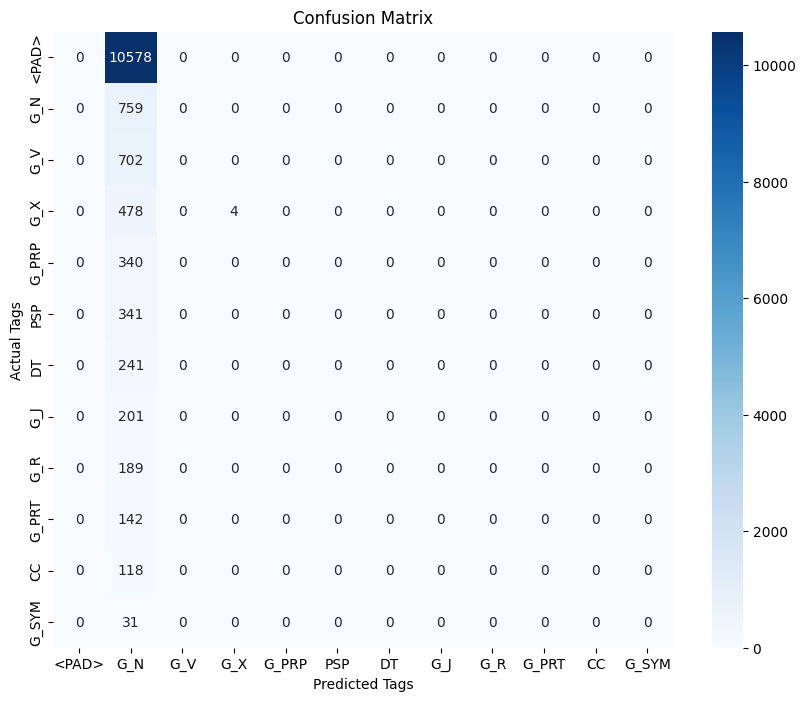

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.05      1.00      0.10       759
         G_V       0.00      0.00      0.00       702
         G_X       1.00      0.01      0.02       482
       G_PRP       0.00      0.00      0.00       340
         PSP       0.00      0.00      0.00       341
          DT       0.00      0.00      0.00       241
         G_J       0.00      0.00      0.00       201
         G_R       0.00      0.00      0.00       189
       G_PRT       0.00      0.00      0.00       142
          CC       0.00      0.00      0.00       118
       G_SYM       0.00      0.00      0.00        31

    accuracy                           0.05     14124
   macro avg       0.09      0.08      0.01     14124
weighted avg       0.04      0.05      0.01     14124



In [ ]:
test_model(model_manual, X_test, y_test, idx2tag)

# **RNN (manual)**

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_manual_RNN = manualRNN(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
count_parameters(model_manual_RNN)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|           Wi           |    6400    |
|           Wh           |    4096    |
|           bh           |     64     |
| embedding_layer.weight |   415500   |
|       fc.weight        |    768     |
|        fc.bias         |     12     |
+------------------------+------------+
Total Trainable Params: 426840


426840

Epoch 0: Loss = 2.4798, Accuracy = 15.2735
Epoch 10: Loss = 2.3600, Accuracy = 31.4207
Epoch 20: Loss = 2.2496, Accuracy = 35.2597
Epoch 30: Loss = 2.1445, Accuracy = 36.5050
Epoch 40: Loss = 2.0477, Accuracy = 37.7296
Epoch 50: Loss = 1.9621, Accuracy = 40.0138
Epoch 60: Loss = 1.8880, Accuracy = 42.1328
Epoch 70: Loss = 1.8248, Accuracy = 44.1280
Epoch 80: Loss = 1.7717, Accuracy = 45.1462
Epoch 90: Loss = 1.7269, Accuracy = 45.9374


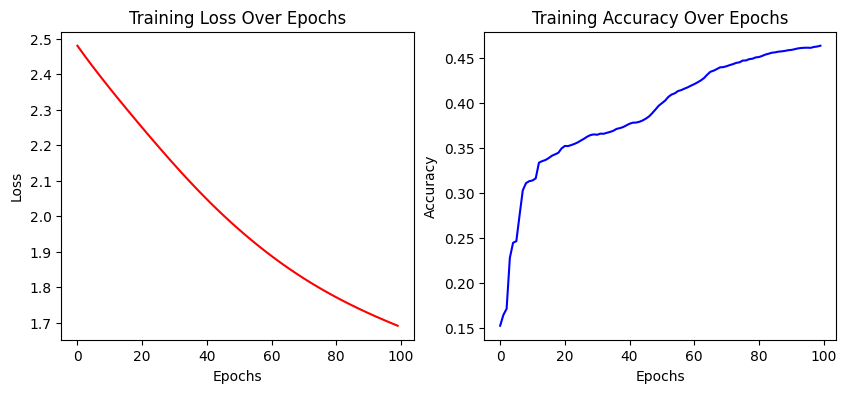

In [ ]:
train_model(model_manual_RNN, X_train, y_train, epochs=100, lr=0.1)

Test Loss: 1.6981
Test Accuracy: 47.0671
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 7


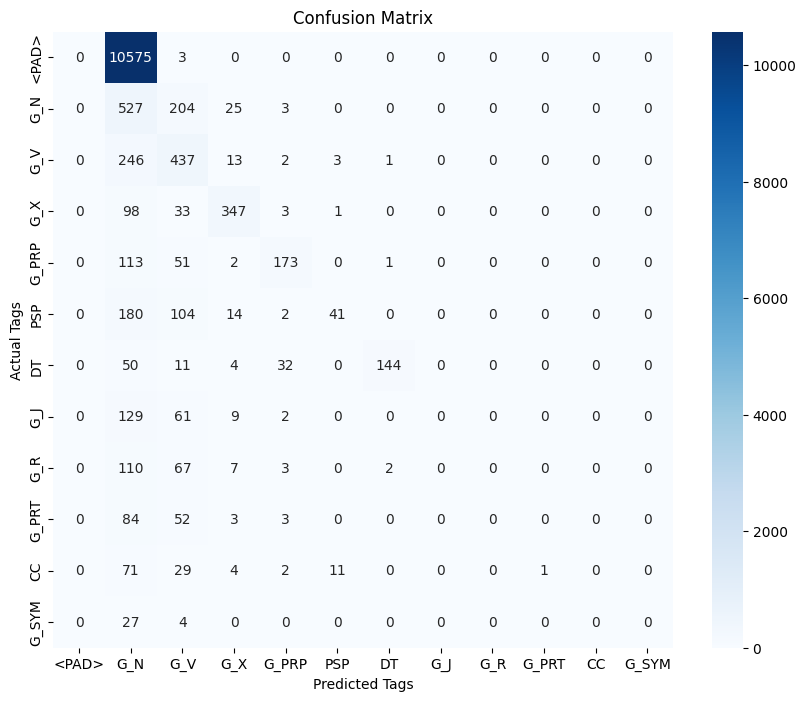

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.04      0.69      0.08       759
         G_V       0.41      0.62      0.50       702
         G_X       0.81      0.72      0.76       482
       G_PRP       0.77      0.51      0.61       340
         PSP       0.73      0.12      0.21       341
          DT       0.97      0.60      0.74       241
         G_J       0.00      0.00      0.00       201
         G_R       0.00      0.00      0.00       189
       G_PRT       0.00      0.00      0.00       142
          CC       0.00      0.00      0.00       118
       G_SYM       0.00      0.00      0.00        31

    accuracy                           0.12     14124
   macro avg       0.31      0.27      0.24     14124
weighted avg       0.10      0.12      0.09     14124



In [ ]:
test_model(model_manual_RNN, X_test, y_test, idx2tag)

# **Class Weights**



*   Adding class weights to balance the skew



In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
train_labels_flat = [tag for _, tags in encoded_train_data for tag in  tags]
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_labels_flat), y=train_labels_flat)
class_weights = np.append(class_weights, 0)
class_weights = torch.tensor(class_weights, dtype = torch.float32)

In [ ]:
class_weights

tensor([ 0.4263,  0.4757,  0.6738,  0.8781,  0.9425,  1.4558,  1.4887,  1.6217,
         2.3298,  2.6390, 11.8004,  0.0000])

# Modified Criterion

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
  criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=tag2idx["<PAD>"])
  opt = optim.SGD(model.parameters(), lr=lr)

  train_losses, train_accuracies = [], []

  for epoch in range(epochs):
    opt.zero_grad()
    logits = model(X_train)
    loss = criterion(logits.view(-1, logits.shape[-1]), y_train.view(-1))
    loss.backward()
    opt.step()

    predictions = logits.argmax(dim=-1)
    mask = (y_train != tag2idx["<PAD>"])
    correct = ((predictions == y_train) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy*100:.4f}")

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Loss", color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Accuracy", color='blue')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy Over Epochs")

  plt.show()

In [ ]:
def test_model(model, X_test, y_test, idx2tag):
    model.eval()
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=tag2idx["<PAD>"])
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_test.view(-1))

        predictions = outputs.argmax(dim=-1)
        mask = (y_test != tag2idx["<PAD>"])
        correct = ((predictions == y_test) & mask).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        print(f"Test Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy*100:.4f}")
        y_true = y_test.view(-1).cpu().numpy()
        y_pred = predictions.view(-1).cpu().numpy()

        unique_y_true = sorted(set(y_true))
        unique_y_pred = sorted(set(y_pred))
        print(f"Number of unique tags in y_true: {len(unique_y_true)}")
        print(f"Number of unique tags in y_pred: {len(unique_y_pred)}")

        cm = confusion_matrix(y_true, y_pred)
        tag_labels = [idx2tag[i] for i in unique_y_true]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_labels, yticklabels=tag_labels)
        plt.xlabel("Predicted Tags")
        plt.ylabel("Actual Tags")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, labels=unique_y_true, target_names=tag_labels, zero_division=0))

# **RNN (manual) with class weights**

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_manual_RNN = manualRNN(vocab_size, embedding_dims, hidden_dims, target_size)

Epoch 0: Loss = 2.4884, Accuracy = 11.1455
Epoch 10: Loss = 2.4136, Accuracy = 26.1094
Epoch 20: Loss = 2.3407, Accuracy = 32.6522
Epoch 30: Loss = 2.2667, Accuracy = 32.3220
Epoch 40: Loss = 2.1920, Accuracy = 33.6361
Epoch 50: Loss = 2.1190, Accuracy = 33.9456
Epoch 60: Loss = 2.0504, Accuracy = 34.3516
Epoch 70: Loss = 1.9874, Accuracy = 34.7644
Epoch 80: Loss = 1.9299, Accuracy = 35.4180
Epoch 90: Loss = 1.8776, Accuracy = 36.1060
Epoch 100: Loss = 1.8301, Accuracy = 37.1861
Epoch 110: Loss = 1.7868, Accuracy = 37.7847
Epoch 120: Loss = 1.7475, Accuracy = 38.3695
Epoch 130: Loss = 1.7119, Accuracy = 39.0574
Epoch 140: Loss = 1.6795, Accuracy = 39.7179
Epoch 150: Loss = 1.6499, Accuracy = 40.8600
Epoch 160: Loss = 1.6229, Accuracy = 41.5893
Epoch 170: Loss = 1.5982, Accuracy = 42.1809
Epoch 180: Loss = 1.5754, Accuracy = 42.8758
Epoch 190: Loss = 1.5545, Accuracy = 43.3574
Epoch 200: Loss = 1.5352, Accuracy = 44.0041
Epoch 210: Loss = 1.5174, Accuracy = 44.4100
Epoch 220: Loss = 1.5

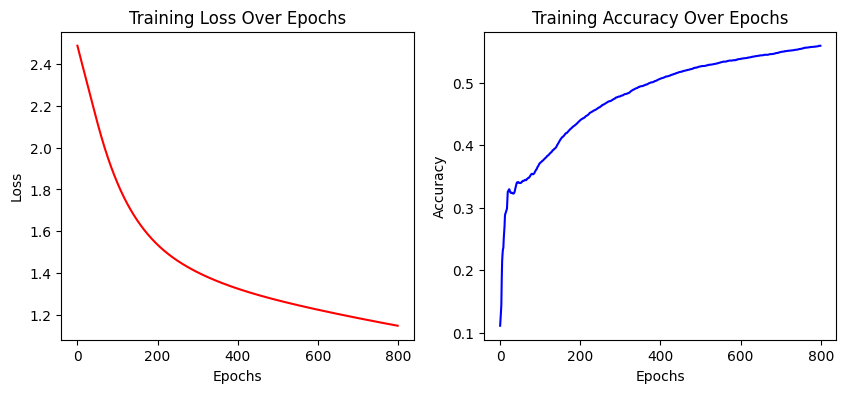

In [ ]:
train_model(model_manual_RNN, X_train, y_train, epochs=800, lr=0.1)

Test Loss: 1.2330
Test Accuracy: 57.8962
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 11


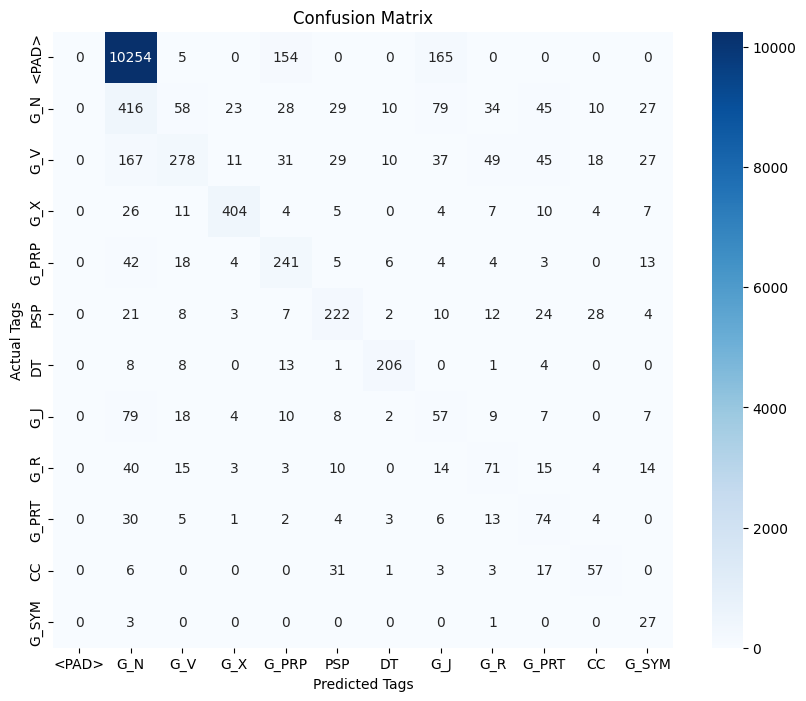

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.04      0.55      0.07       759
         G_V       0.66      0.40      0.49       702
         G_X       0.89      0.84      0.86       482
       G_PRP       0.49      0.71      0.58       340
         PSP       0.65      0.65      0.65       341
          DT       0.86      0.85      0.86       241
         G_J       0.15      0.28      0.20       201
         G_R       0.35      0.38      0.36       189
       G_PRT       0.30      0.52      0.38       142
          CC       0.46      0.48      0.47       118
       G_SYM       0.21      0.87      0.34        31

    accuracy                           0.15     14124
   macro avg       0.42      0.54      0.44     14124
weighted avg       0.12      0.15      0.12     14124



In [ ]:
test_model(model_manual_RNN, X_test, y_test, idx2tag)

# **LSTM (torch api) with class weights**

In [ ]:
model_api = LSTMV1(vocab_size, embedding_dims, hidden_dims, target_size)

Epoch 0: Loss = 2.4882, Accuracy = 6.2539
Epoch 10: Loss = 2.4736, Accuracy = 8.2078
Epoch 20: Loss = 2.4605, Accuracy = 10.0929
Epoch 30: Loss = 2.4485, Accuracy = 12.4871
Epoch 40: Loss = 2.4374, Accuracy = 14.8263
Epoch 50: Loss = 2.4270, Accuracy = 16.9178
Epoch 60: Loss = 2.4171, Accuracy = 19.1538
Epoch 70: Loss = 2.4076, Accuracy = 20.5160
Epoch 80: Loss = 2.3983, Accuracy = 21.6030
Epoch 90: Loss = 2.3892, Accuracy = 22.5800


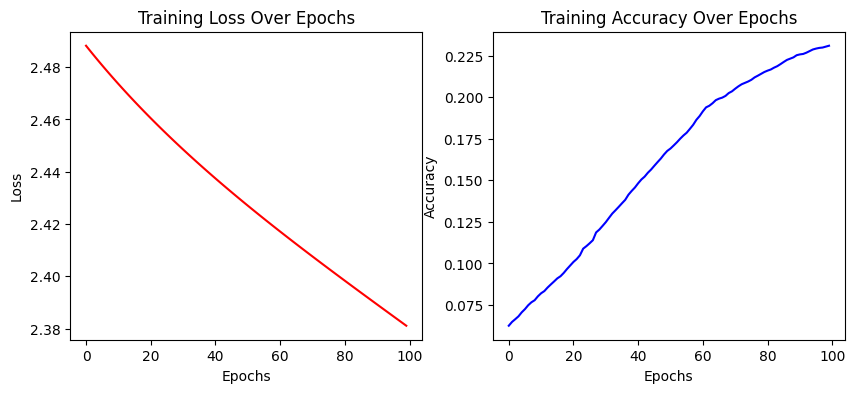

In [ ]:
train_model(model_api, X_train, y_train, epochs=100, lr=0.1)

Test Loss: 2.3829
Test Accuracy: 20.6994
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 11


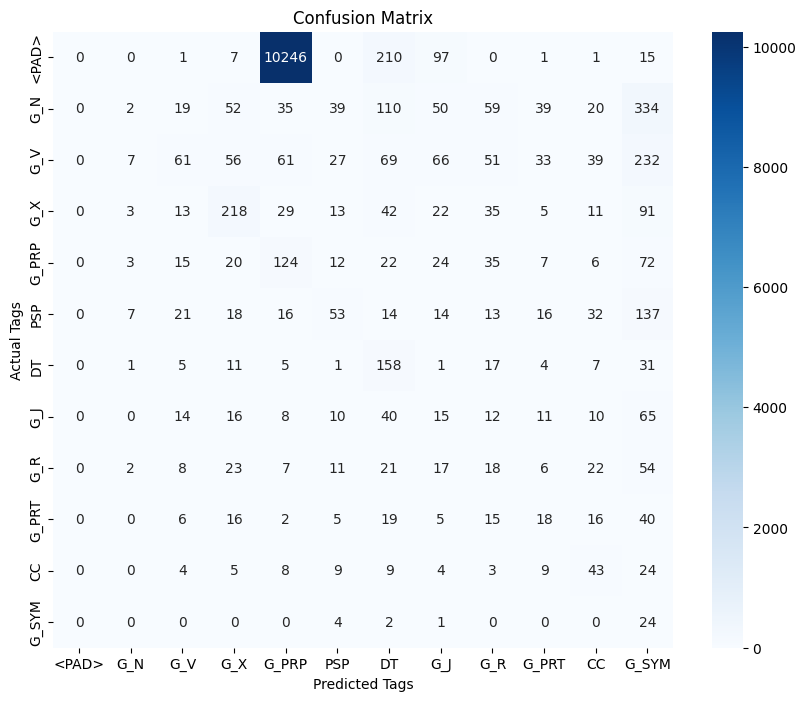

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.08      0.00      0.01       759
         G_V       0.37      0.09      0.14       702
         G_X       0.49      0.45      0.47       482
       G_PRP       0.01      0.36      0.02       340
         PSP       0.29      0.16      0.20       341
          DT       0.22      0.66      0.33       241
         G_J       0.05      0.07      0.06       201
         G_R       0.07      0.10      0.08       189
       G_PRT       0.12      0.13      0.12       142
          CC       0.21      0.36      0.26       118
       G_SYM       0.02      0.77      0.04        31

    accuracy                           0.05     14124
   macro avg       0.16      0.26      0.15     14124
weighted avg       0.05      0.05      0.04     14124



In [ ]:
test_model(model_api, X_test, y_test, idx2tag)

# **LSTM (manual) with class weights**

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 100
hidden_dims = 64
target_size = len(tag2idx)

model_manual = ManualLSTM(vocab_size, embedding_dims, hidden_dims, target_size)

Epoch 0: Loss = 2.4848, Accuracy = 9.7489
Epoch 10: Loss = 2.4738, Accuracy = 9.7489
Epoch 20: Loss = 2.4640, Accuracy = 9.7489
Epoch 30: Loss = 2.4550, Accuracy = 9.8246
Epoch 40: Loss = 2.4468, Accuracy = 11.0698
Epoch 50: Loss = 2.4392, Accuracy = 14.3172
Epoch 60: Loss = 2.4319, Accuracy = 18.8579
Epoch 70: Loss = 2.4250, Accuracy = 21.4517
Epoch 80: Loss = 2.4183, Accuracy = 22.3529
Epoch 90: Loss = 2.4118, Accuracy = 23.5707


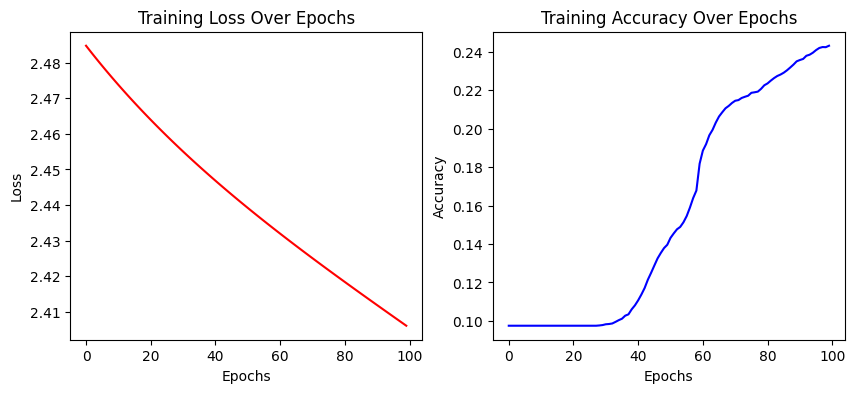

In [ ]:
train_model(model_manual, X_train, y_train, epochs=100, lr=0.1)

Test Loss: 2.4081
Test Accuracy: 23.8579
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 7


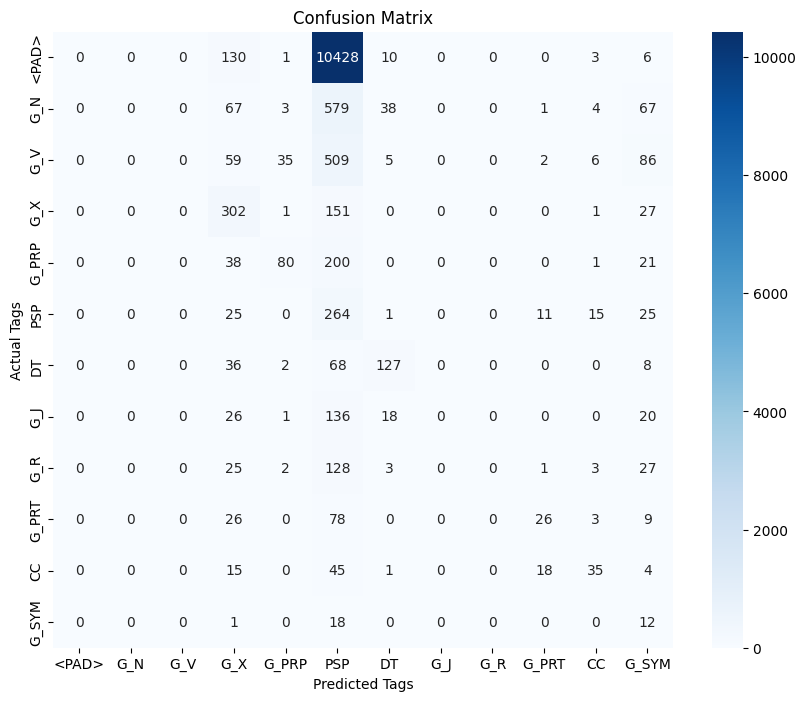

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.00      0.00      0.00       759
         G_V       0.00      0.00      0.00       702
         G_X       0.40      0.63      0.49       482
       G_PRP       0.64      0.24      0.34       340
         PSP       0.02      0.77      0.04       341
          DT       0.63      0.53      0.57       241
         G_J       0.00      0.00      0.00       201
         G_R       0.00      0.00      0.00       189
       G_PRT       0.44      0.18      0.26       142
          CC       0.49      0.30      0.37       118
       G_SYM       0.04      0.39      0.07        31

    accuracy                           0.06     14124
   macro avg       0.22      0.25      0.18     14124
weighted avg       0.05      0.06      0.04     14124



In [ ]:
test_model(model_manual, X_test, y_test, idx2tag)

# **Model Experimentation:**

*   Adding another layer for the RNN
*   Adding Bidirectionality for a Single Layer RNN





In [ ]:
#2nd RNN Layer
class twoLayeredRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_size):
    super(twoLayeredRNN, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims, target_size)

    self.Wi1 = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh1 = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh1 = nn.Parameter(torch.zeros(hidden_dims))

    self.Wi2 = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.Wh2 = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh2 = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h1 = torch.zeros(batch_size, hidden_dims)
    h2 = torch.zeros(batch_size, hidden_dims)
    ops = []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h1 = torch.tanh(embeds[:, time_step] @ self.Wi1 + h1 @ self.Wh1 + self.bh1)
      h2 = torch.tanh(h1 @ self.Wi2 + h2 @ self.Wh2 + self.bh2)
      y_t = self.fc(h2)
      ops.append(y_t)

    return torch.stack(ops, dim = 1)

In [ ]:
#Bidirectionality
class BidirectionalRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_dims, target_Size):
    super(BidirectionalRNN, self).__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
    self.fc = nn.Linear(hidden_dims * 2, target_size)

    #Forward direction
    self.Wi_f = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh_f = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh_f = nn.Parameter(torch.zeros(hidden_dims))

    #Backward direction
    self.Wi_b = nn.Parameter(torch.randn(embedding_dims, hidden_dims) * 0.01)
    self.Wh_b = nn.Parameter(torch.randn(hidden_dims, hidden_dims) * 0.01)
    self.bh_b = nn.Parameter(torch.zeros(hidden_dims))

  def forward(self, x):
    batch_size, seq_len = x.shape
    h_f = torch.zeros(batch_size, hidden_dims)
    h_b = torch.zeros(batch_size, hidden_dims)

    fw_ops, bw_ops = [], []

    embeds = self.embedding_layer(x)
    for time_step in range(seq_len):
      h_f = torch.tanh(embeds[:, time_step] @ self.Wi_f + h_f @ self.Wh_f + self.bh_f)
      fw_ops.append(h_f)

    for time_step in reversed(range(seq_len)):
      h_b = torch.tanh(embeds[:, time_step] @ self.Wi_b + h_b @ self.Wh_b + self.bh_b)
      bw_ops.append(h_b)

    bw_ops.reverse()
    outputs = [torch.cat((f, b), dim=1) for f,b in zip(fw_ops, bw_ops)]
    outputs = torch.stack(outputs, dim = 1)

    return self.fc(outputs)

In [ ]:
model_2layer = twoLayeredRNN(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
model_bidir = BidirectionalRNN(vocab_size, embedding_dims, hidden_dims, target_size)

In [ ]:
count_parameters(model_2layer)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|          Wi1           |    6400    |
|          Wh1           |    4096    |
|          bh1           |     64     |
|          Wi2           |    4096    |
|          Wh2           |    4096    |
|          bh2           |     64     |
| embedding_layer.weight |   415500   |
|       fc.weight        |    768     |
|        fc.bias         |     12     |
+------------------------+------------+
Total Trainable Params: 435096


435096

In [ ]:
count_parameters(model_bidir)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|          Wi_f          |    6400    |
|          Wh_f          |    4096    |
|          bh_f          |     64     |
|          Wi_b          |    6400    |
|          Wh_b          |    4096    |
|          bh_b          |     64     |
| embedding_layer.weight |   415500   |
|       fc.weight        |    1536    |
|        fc.bias         |     12     |
+------------------------+------------+
Total Trainable Params: 438168


438168

# **Training and testing 2 layered RNN**

Epoch 0: Loss = 2.4781, Accuracy = 3.2473
Epoch 10: Loss = 2.4689, Accuracy = 3.2473
Epoch 20: Loss = 2.4612, Accuracy = 3.4331
Epoch 30: Loss = 2.4543, Accuracy = 13.5397
Epoch 40: Loss = 2.4481, Accuracy = 22.1534
Epoch 50: Loss = 2.4423, Accuracy = 25.8067
Epoch 60: Loss = 2.4367, Accuracy = 23.7564
Epoch 70: Loss = 2.4310, Accuracy = 23.5432
Epoch 80: Loss = 2.4249, Accuracy = 23.9560
Epoch 90: Loss = 2.4181, Accuracy = 24.2724


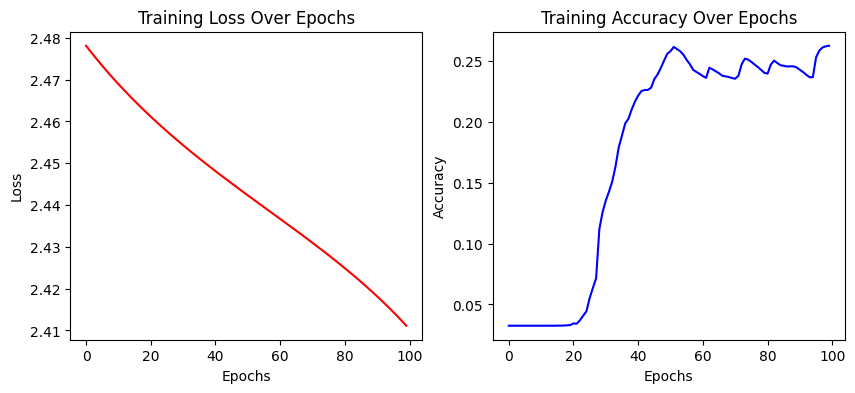

In [ ]:
train_model(model_2layer, X_train, y_train, epochs=100, lr=0.1)

Test Loss: 2.4112
Test Accuracy: 25.0705
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 8


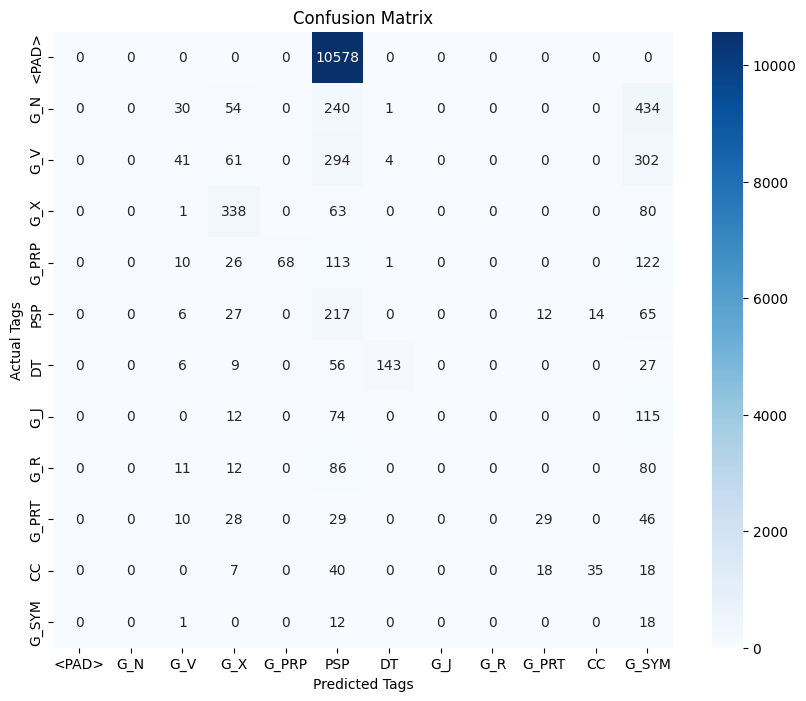

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.00      0.00      0.00       759
         G_V       0.35      0.06      0.10       702
         G_X       0.59      0.70      0.64       482
       G_PRP       1.00      0.20      0.33       340
         PSP       0.02      0.64      0.04       341
          DT       0.96      0.59      0.73       241
         G_J       0.00      0.00      0.00       201
         G_R       0.00      0.00      0.00       189
       G_PRT       0.49      0.20      0.29       142
          CC       0.71      0.30      0.42       118
       G_SYM       0.01      0.58      0.03        31

    accuracy                           0.06     14124
   macro avg       0.34      0.27      0.21     14124
weighted avg       0.09      0.06      0.05     14124



In [ ]:
test_model(model_2layer, X_test, y_test, idx2tag)

# **Training and testing Bidirectional RNN**

Epoch 0: Loss = 2.4793, Accuracy = 4.8366
Epoch 10: Loss = 2.3930, Accuracy = 25.2700
Epoch 20: Loss = 2.3070, Accuracy = 30.4850
Epoch 30: Loss = 2.2172, Accuracy = 32.0674
Epoch 40: Loss = 2.1260, Accuracy = 32.9893
Epoch 50: Loss = 2.0388, Accuracy = 33.6017
Epoch 60: Loss = 1.9594, Accuracy = 34.3447
Epoch 70: Loss = 1.8883, Accuracy = 35.0533
Epoch 80: Loss = 1.8249, Accuracy = 35.8239
Epoch 90: Loss = 1.7685, Accuracy = 36.2711
Epoch 100: Loss = 1.7184, Accuracy = 37.1448
Epoch 110: Loss = 1.6738, Accuracy = 38.1906
Epoch 120: Loss = 1.6341, Accuracy = 39.2638
Epoch 130: Loss = 1.5983, Accuracy = 40.1376
Epoch 140: Loss = 1.5657, Accuracy = 41.0320
Epoch 150: Loss = 1.5359, Accuracy = 41.8438
Epoch 160: Loss = 1.5085, Accuracy = 42.7589
Epoch 170: Loss = 1.4831, Accuracy = 43.5638
Epoch 180: Loss = 1.4595, Accuracy = 44.6302
Epoch 190: Loss = 1.4376, Accuracy = 45.5521
Epoch 200: Loss = 1.4172, Accuracy = 46.4534
Epoch 210: Loss = 1.3983, Accuracy = 47.1827
Epoch 220: Loss = 1.38

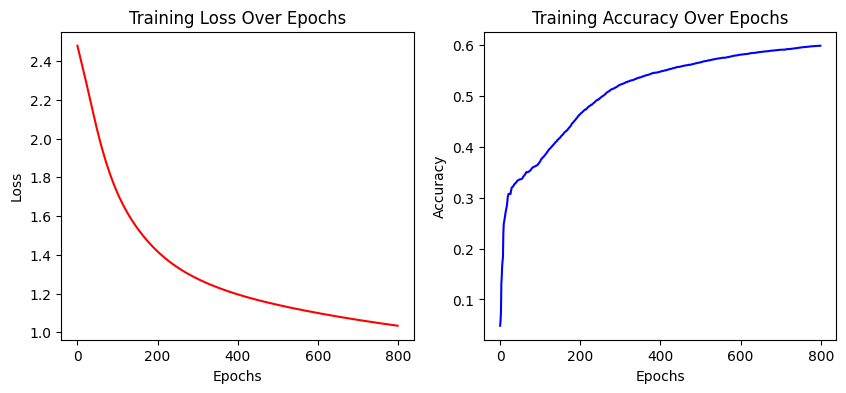

In [ ]:
train_model(model_bidir, X_train, y_train, epochs=800, lr=0.1)

Test Loss: 1.1561
Test Accuracy: 61.1393
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 11


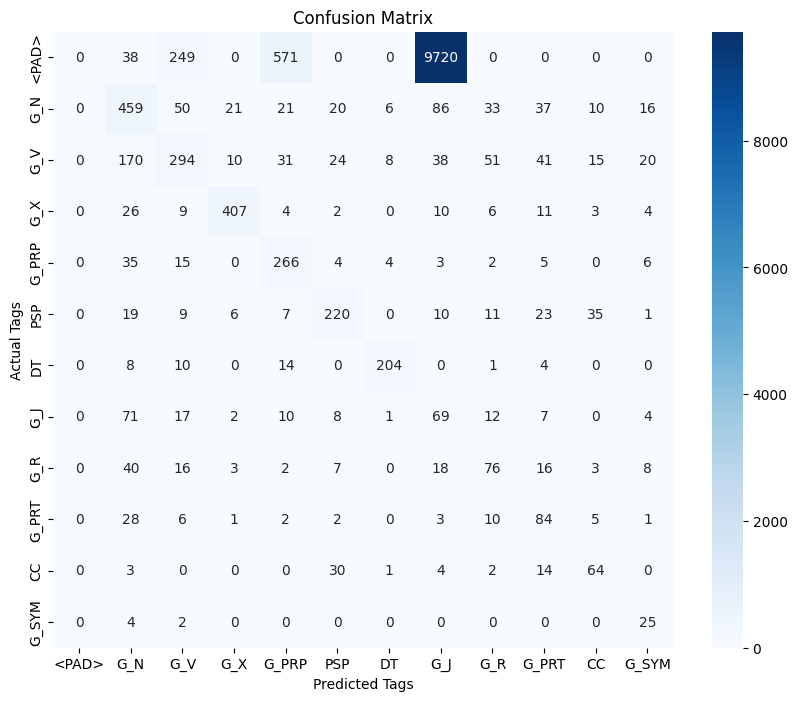

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.51      0.60      0.55       759
         G_V       0.43      0.42      0.43       702
         G_X       0.90      0.84      0.87       482
       G_PRP       0.29      0.78      0.42       340
         PSP       0.69      0.65      0.67       341
          DT       0.91      0.85      0.88       241
         G_J       0.01      0.34      0.01       201
         G_R       0.37      0.40      0.39       189
       G_PRT       0.35      0.59      0.44       142
          CC       0.47      0.54      0.51       118
       G_SYM       0.29      0.81      0.43        31

    accuracy                           0.15     14124
   macro avg       0.44      0.57      0.47     14124
weighted avg       0.13      0.15      0.14     14124



In [ ]:
test_model(model_bidir, X_test, y_test, idx2tag)

# **Fasttext - 200 vectors**

In [ ]:
new_embedding_dim = 200
path = "/content/drive/MyDrive/QML-Research/Data/hi_Fasttext_vectors/wordVectors200.txt"
fv_200 = create_fasttext_vectors(path, new_embedding_dim)
em_200 = np.zeros((len(word2idx), new_embedding_dim))

for word, idx in word2idx.items():
  if word in fv_200:
    em_200[idx] = fv_200[word]
  else:
    em_200[idx] = np.random.normal(scale = 0.6, size = (new_embedding_dim, ))

em_200 = torch.tensor(em_200, dtype = torch.float32)

In [ ]:
em_200.shape

torch.Size([4155, 200])

In [ ]:
vocab_size = len(word2idx)
embedding_dims = 200
hidden_dims = 64
target_size = len(tag2idx)

In [ ]:
rnn_200 = manualRNN(vocab_size, embedding_dims, hidden_dims, target_size)
rnn_200.embedding_layer = nn.Embedding.from_pretrained(em_200, freeze = False)

Epoch 0: Loss = 2.4948, Accuracy = 5.5384
Epoch 10: Loss = 2.3639, Accuracy = 25.4008
Epoch 20: Loss = 2.2405, Accuracy = 28.8820
Epoch 30: Loss = 2.1237, Accuracy = 31.9023
Epoch 40: Loss = 2.0178, Accuracy = 33.0788
Epoch 50: Loss = 1.9245, Accuracy = 34.6818
Epoch 60: Loss = 1.8426, Accuracy = 36.0716
Epoch 70: Loss = 1.7706, Accuracy = 37.2480
Epoch 80: Loss = 1.7071, Accuracy = 38.5965
Epoch 90: Loss = 1.6507, Accuracy = 39.9725
Epoch 100: Loss = 1.6004, Accuracy = 41.1834
Epoch 110: Loss = 1.5550, Accuracy = 42.3942
Epoch 120: Loss = 1.5137, Accuracy = 43.4813
Epoch 130: Loss = 1.4760, Accuracy = 44.7609
Epoch 140: Loss = 1.4414, Accuracy = 45.8342
Epoch 150: Loss = 1.4097, Accuracy = 46.7767
Epoch 160: Loss = 1.3806, Accuracy = 47.7331
Epoch 170: Loss = 1.3538, Accuracy = 48.4830
Epoch 180: Loss = 1.3292, Accuracy = 49.4462
Epoch 190: Loss = 1.3066, Accuracy = 50.1686
Epoch 200: Loss = 1.2858, Accuracy = 50.8015
Epoch 210: Loss = 1.2666, Accuracy = 51.5514
Epoch 220: Loss = 1.24

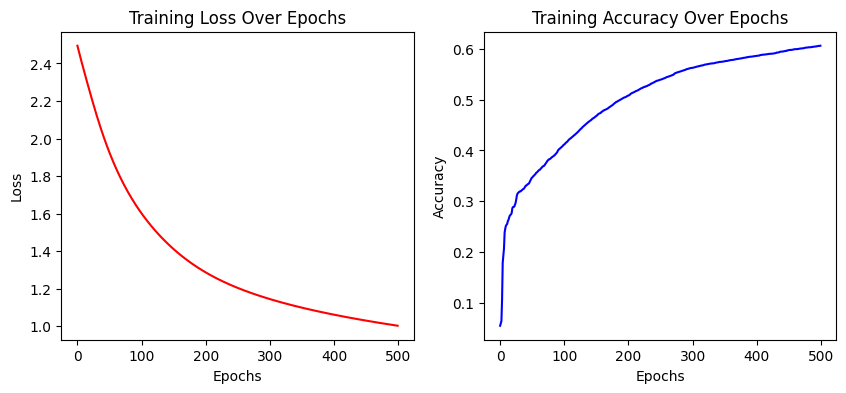

In [ ]:
train_model(rnn_200, X_train, y_train, epochs=500, lr=0.1)

Test Loss: 1.1082
Test Accuracy: 58.2346
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 11


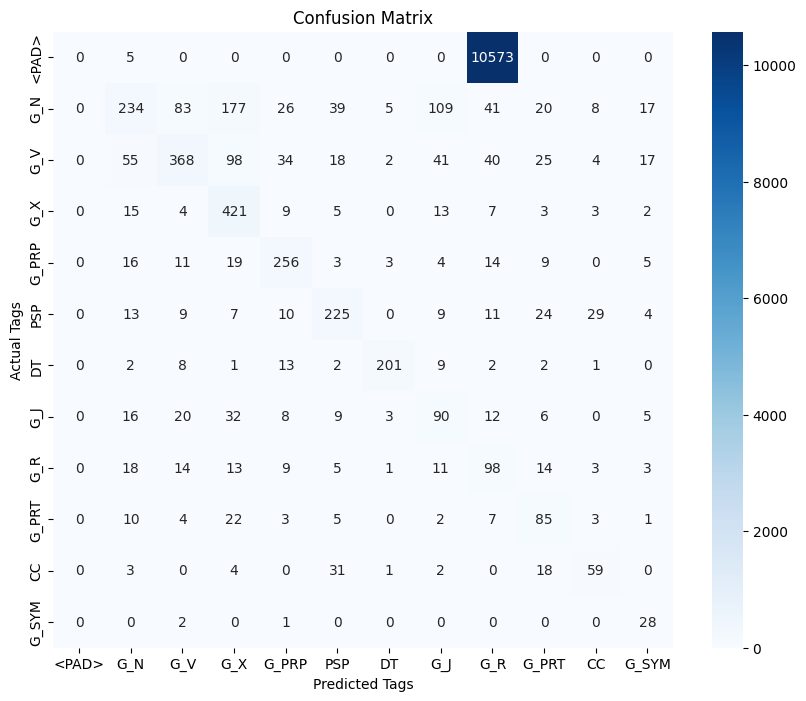

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.60      0.31      0.41       759
         G_V       0.70      0.52      0.60       702
         G_X       0.53      0.87      0.66       482
       G_PRP       0.69      0.75      0.72       340
         PSP       0.66      0.66      0.66       341
          DT       0.93      0.83      0.88       241
         G_J       0.31      0.45      0.37       201
         G_R       0.01      0.52      0.02       189
       G_PRT       0.41      0.60      0.49       142
          CC       0.54      0.50      0.52       118
       G_SYM       0.34      0.90      0.50        31

    accuracy                           0.15     14124
   macro avg       0.48      0.58      0.48     14124
weighted avg       0.15      0.15      0.14     14124



In [ ]:
test_model(rnn_200, X_test, y_test, idx2tag)

In [ ]:
bidir_200 = BidirectionalRNN(vocab_size, embedding_dims, hidden_dims, target_size)
bidir_200.embedding_layer = nn.Embedding.from_pretrained(em_200, freeze = False)

Epoch 0: Loss = 2.4979, Accuracy = 10.4988
Epoch 10: Loss = 2.3584, Accuracy = 32.1981
Epoch 20: Loss = 2.2257, Accuracy = 32.1087
Epoch 30: Loss = 2.1010, Accuracy = 32.5284
Epoch 40: Loss = 1.9918, Accuracy = 33.1063
Epoch 50: Loss = 1.8993, Accuracy = 34.3447
Epoch 60: Loss = 1.8206, Accuracy = 35.3010
Epoch 70: Loss = 1.7526, Accuracy = 36.8490
Epoch 80: Loss = 1.6927, Accuracy = 38.5346
Epoch 90: Loss = 1.6394, Accuracy = 39.6216
Epoch 100: Loss = 1.5910, Accuracy = 41.2040
Epoch 110: Loss = 1.5468, Accuracy = 42.7657
Epoch 120: Loss = 1.5061, Accuracy = 43.7564
Epoch 130: Loss = 1.4683, Accuracy = 44.8572
Epoch 140: Loss = 1.4332, Accuracy = 45.9030
Epoch 150: Loss = 1.4006, Accuracy = 46.8868
Epoch 160: Loss = 1.3704, Accuracy = 47.8707
Epoch 170: Loss = 1.3423, Accuracy = 48.8682
Epoch 180: Loss = 1.3161, Accuracy = 49.8246
Epoch 190: Loss = 1.2918, Accuracy = 50.8084
Epoch 200: Loss = 1.2692, Accuracy = 51.5170
Epoch 210: Loss = 1.2481, Accuracy = 52.2050
Epoch 220: Loss = 1.2

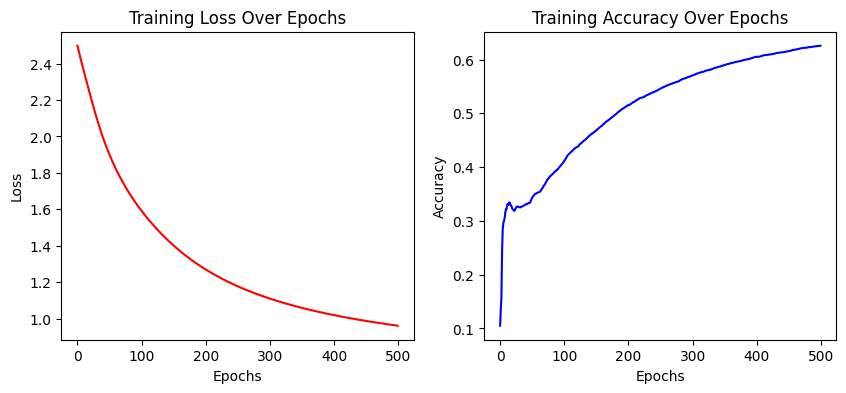

In [ ]:
train_model(bidir_200, X_train, y_train, epochs=500, lr=0.1)

Test Loss: 1.1359
Test Accuracy: 63.5928
Number of unique tags in y_true: 12
Number of unique tags in y_pred: 11


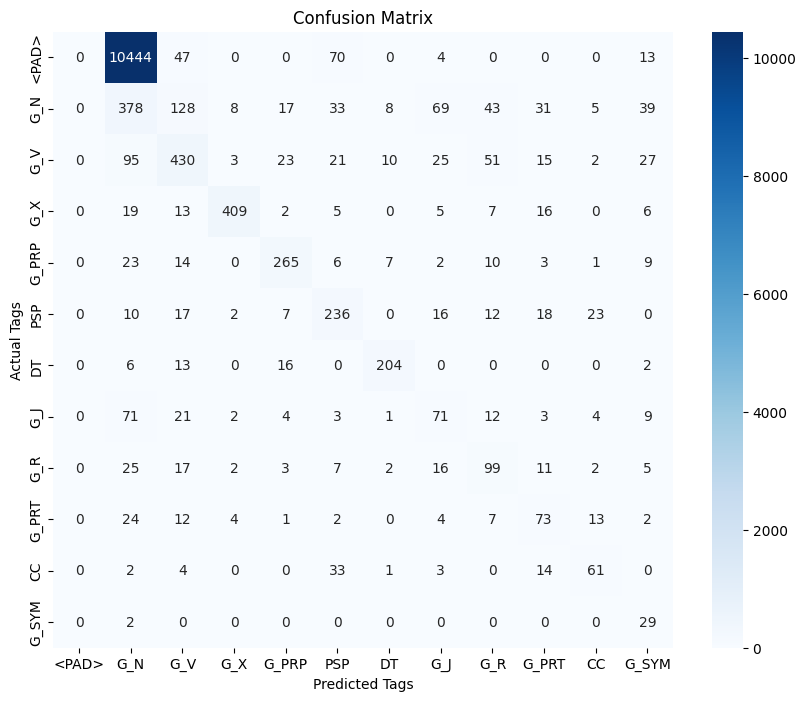

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00     10578
         G_N       0.03      0.50      0.06       759
         G_V       0.60      0.61      0.61       702
         G_X       0.95      0.85      0.90       482
       G_PRP       0.78      0.78      0.78       340
         PSP       0.57      0.69      0.62       341
          DT       0.88      0.85      0.86       241
         G_J       0.33      0.35      0.34       201
         G_R       0.41      0.52      0.46       189
       G_PRT       0.40      0.51      0.45       142
          CC       0.55      0.52      0.53       118
       G_SYM       0.21      0.94      0.34        31

    accuracy                           0.16     14124
   macro avg       0.48      0.59      0.50     14124
weighted avg       0.13      0.16      0.13     14124



In [ ]:
test_model(bidir_200, X_test, y_test, idx2tag)